In [2]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [3]:
import main

from main import delta_2_eta0
from main import Gamma_2_eta
from main import eta0_2_delta
from main import eta_2_Gamma

np.random.seed(0)
random.seed(0)

# Initialize Parameters

In [4]:
# parameters for model
K = [2,4]
jump_every = 1

features = [{},
            {'diveDuration'     : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None},
             'maxDepth'         : {'f'           : 'normal',
                                   'lower_bound' : np.array([-np.infty,-np.infty,np.log(5),np.log(5)]),
                                   'upper_bound' : np.array([np.log(20),np.log(20),np.infty,np.infty])},
             'avg_bot_htv'      : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None}}]#,
             #'avg_bot_abs_roll' : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None},
             #'max_bot_jp'       : {'f'           : 'normal',
             #                      'lower_bound' : None,
             #                      'upper_bound' : None}}]
             #'broadDiveType'    : {'f':'bern'}}],
             #'foraging'         : {'f':'bern'},
             #'scales'           : {'f':'bern'},
             #'click.train'      : {'f':'bern'},
             #'whales'           : {'f':'bern'}}]

# optimization parameters 
methods = ["BFGS"]#,"CG","Nelder-Mead","L-BFGS-B"]
num_epochs = 1000
tol = 1e-8
grad_tol = 1e-8

# Load in Whale Data

In [5]:
# load in data
df = pd.read_csv("../dat/Final_Data_new.csv")

# only take whale I107
whales = ["I107"]#,"I145"]
df = df[df["ID"].isin(whales)]

# convert times
df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# force dives to be at least 2 seconds long
df = df[df["diveDuration"] > np.log(2.0)]

# replace -inf 
df["max_bot_jp"][df["max_bot_jp"] == -np.infty] = np.NAN

df["broadDiveType"] = np.NAN #3  # unknown
df.loc[df["maxDepth"] > np.log(20),"broadDiveType"] = 1  # deep
df.loc[df["maxDepth"] < np.log(5),"broadDiveType"] = 0  # shallow
# populate a data object
data = []
for row in df.iterrows():
    data.append({"diveDuration"     : row[1]["diveDuration"],
                 "maxDepth"         : row[1]["maxDepth"],
                 "avg_bot_htv"      : row[1]["avg_bot_htv"]})#,
                 #"broadDiveType"    : row[1]["broadDiveType"]})#,
                 #"avg_bot_abs_roll" : row[1]["avg_bot_abs_roll"],
                 #"max_bot_jp"       : row[1]["max_bot_jp"]})#,
                 #"foraging"         : row[1]["foraging"],
                 #"scales"           : row[1]["scales"],
                 #"click.train"      : row[1]["click.train"],
                 #"whales"           : row[1]["whales"]})

In [6]:
raw_df = pd.read_csv("../dat/Final_rawData_new.csv", 
                      usecols = ["Time","p","head","pitch","roll","divenum"],
                      low_memory = True)

In [7]:
raw_df["Elevation"] = -raw_df["p"]
raw_df["Time"] = pd.to_datetime(raw_df["Time"])

#dive_inds = raw_df["divenum"].isin(df["divenum"].unique())
#raw_df = raw_df[dive_inds]

raw_df
raw_df = raw_df[raw_df["Time"] > min(df["stime"])]
raw_df = raw_df[raw_df["Time"] < max(df["etime"])]

raw_df = raw_df.reset_index(drop=True)

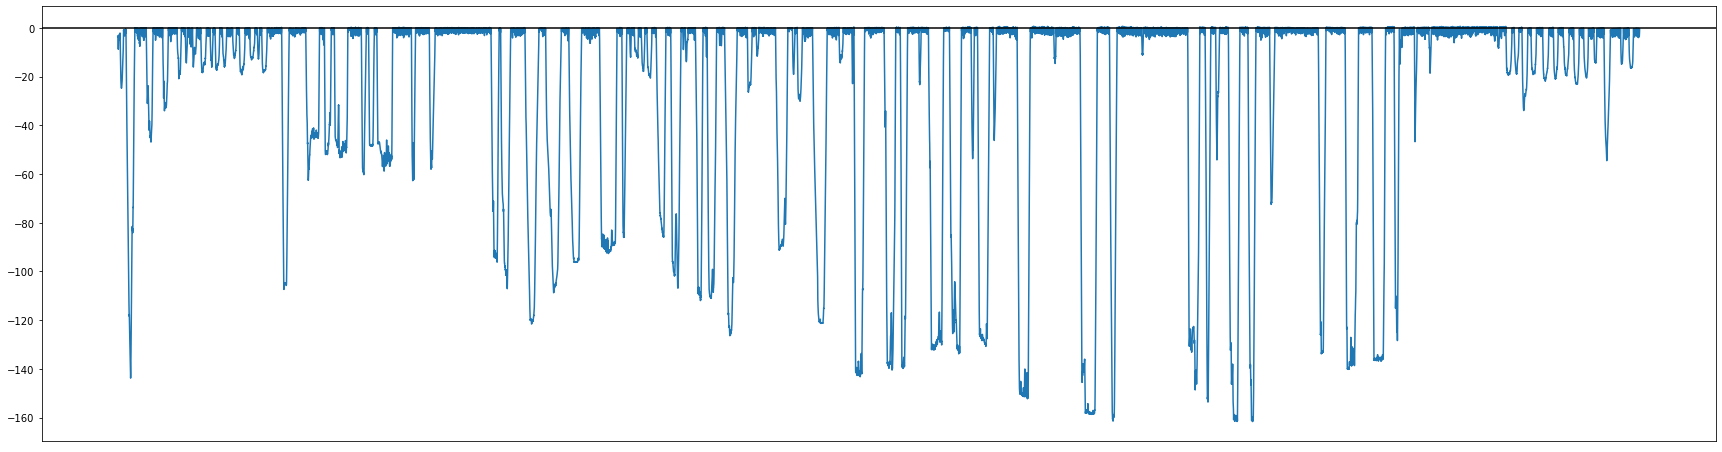

In [8]:
plt.figure(figsize=(30,8))
plt.plot(raw_df.iloc[::50]["Time"],
         raw_df.iloc[::50]["Elevation"])
plt.xticks([])
plt.axhline(0,color='k')
plt.show()

# Train the HMM

In [8]:
# initialize optims
optims = {}
times = {}

In [9]:
importlib.reload(main)
from numpy import array

for exp in range(5):
    for method in methods:
        print(method,exp)
        optims[(method,exp)] = main.optimizor(data,features,K)
        optims[(method,exp)].jump_every = jump_every

        
        # initize parameters
        if exp == 0:
            optims[(method,exp)].theta = [{},
                                         [{'diveDuration': {'mu': array([1.854306, 2.72080265, 4.52929456,5.65852037]),
                                            'log_sig': array([-0.73837844, -0.79061645, -0.60660279, -0.98119266])},
                                           'maxDepth': {'mu': array([0.53511479, 0.977712, 2.80630464, 4.64787012]),
                                            'log_sig': array([-1.42110742, -1.26116306, -0.46629956, -0.92586801])},
                                           'avg_bot_htv': {'mu': array([-2.0848472, -1.67673607, -1.75932838, -0.97148355]),
                                            'log_sig': array([-0.84274729, -0.40263998, -0.41513375, -0.39629952])}},#,
                                           #'avg_bot_abs_roll': {'mu': array([-2.37135868, -2.00836048, -1.66830651, -0.71058847]),
                                           # 'log_sig': array([0.17516048, 0.32487209, 0.06873597, 0.24031772])},
                                           #'max_bot_jp': {'mu': array([1.10350294, 2.27959847, 1.90533877, 3.3076004]),
                                           # 'log_sig': array([-0.21604693, 0.05545164, 0.23320295, 0.13744996])}},
                                          {'diveDuration': {'mu': array([1.854306, 2.72080265, 4.52929456,5.65852037]),
                                            'log_sig': array([-0.73837844, -0.79061645, -0.60660279, -0.98119266])},
                                           'maxDepth': {'mu': array([0.53511479, 0.977712, 2.80630464, 4.64787012]),
                                            'log_sig': array([-1.42110742, -1.26116306, -0.46629956, -0.92586801])},
                                           'avg_bot_htv': {'mu': array([-2.0848472, -1.67673607, -1.75932838, -0.97148355]),
                                            'log_sig': array([-0.84274729, -0.40263998, -0.41513375, -0.39629952])}}]]#,
                                           #'avg_bot_abs_roll': {'mu': array([-2.37135868, -2.00836048, -1.66830651, -0.71058847]),
                                           # 'log_sig': array([0.17516048, 0.32487209, 0.06873597, 0.24031772])},
                                           #'max_bot_jp': {'mu': array([1.10350294, 2.27959847, 1.90533877, 3.3076004]),
                                           # 'log_sig': array([-0.21604693, 0.05545164, 0.23320295, 0.13744996])}}]]

            '''
            optims[(method,exp)].theta = [{},
                                       [{'diveDuration': {'mu': array([2.44579841, 4.57474679, 5.58909496]),
                                          'log_sig': array([-0.48494121, -0.62560195, -0.83579361])},
                                         'maxDepth': {'mu': array([0.83827409, 2.83220899, 4.62002681]),
                                          'log_sig': array([-1.06817535, -0.73211672, -0.96012969])},
                                         'avg_bot_htv': {'mu': array([-1.78707371, -1.77230154, -0.98216739]),
                                          'log_sig': array([-0.44595179, -0.42763421, -0.41364151])},
                                         'avg_bot_abs_roll': {'mu': array([-2.10086378, -1.57589996, -0.67009179]),
                                          'log_sig': array([0.29613075, 0.09076756, 0.26332979])},
                                         'max_bot_jp': {'mu': array([1.96233616, 1.92165666, 3.57603349]),
                                          'log_sig': array([0.11742883, 0.20457382, 0.12237257])}},
                                        {'diveDuration': {'mu': array([2.44579841, 4.57474679, 5.58909496]),
                                          'log_sig': array([-0.48494121, -0.62560195, -0.83579361])},
                                         'maxDepth': {'mu': array([0.83827409, 2.83220899, 4.62002681]),
                                          'log_sig': array([-1.06817535, -0.73211672, -0.96012969])},
                                         'avg_bot_htv': {'mu': array([-1.78707371, -1.77230154, -0.98216739]),
                                          'log_sig': array([-0.44595179, -0.42763421, -0.41364151])},
                                         'avg_bot_abs_roll': {'mu': array([-2.10086378, -1.57589996, -0.67009179]),
                                          'log_sig': array([0.29613075, 0.09076756, 0.26332979])},
                                         'max_bot_jp': {'mu': array([1.96233616, 1.92165666, 3.57603349]),
                                          'log_sig': array([0.11742883, 0.20457382, 0.12237257])}}]]
            '''               
            Gamma = [np.array([[0.99,0.01],
                               [0.01,0.99]]),
                     [np.array([[0.7, 0.1, 0.15, 0.05],
                                [0.1, 0.7, 0.15, 0.05],
                                [0.1, 0.8, 0.05, 0.05],
                                [0.8, 0.1, 0.05, 0.05]]),
                      np.array([[0.7, 0.1, 0.05, 0.15],
                                [0.1, 0.7, 0.05, 0.15],
                                [0.1, 0.8, 0.05, 0.05],
                                [0.8, 0.1, 0.05, 0.05]])]]

            delta = [array([0.5, 0.5]),
                     [array([0.01, 0.08, 0.9, 0.01]),
                      array([0.08, 0.01, 0.01, 0.9])]]
            '''
            Gamma = [array([[0.93254844, 0.06745156],
                            [0.1233364 , 0.8766636 ]]),
                     [array([[0.94895646, 0.05104354],
                             [0.98379104, 0.01620896]]),
                      array([[9.40232095e-01, 5.97679051e-02],
                             [9.99194884e-01, 8.05115532e-04]])]]

            delta = [array([0.91081562, 0.08918438]),
                     [array([0.05986769, 0.94013231]),
                      array([0.0998123, 0.9001877])]]
            
            '''
            optims[(method,exp)].eta0 = delta_2_eta0(delta)
            optims[(method,exp)].eta = Gamma_2_eta(Gamma)
            
            print(optims[(method,exp)].theta)
        
        
        #optims[(method,exp)].theta[1][0]['broadDiveType']['logit_p'][0] = -10.0
        #optims[(method,exp)].theta[1][0]['broadDiveType']['logit_p'][1] = 10.0
        #optims[(method,exp)].theta[1][0]['broadDiveType']['logit_p'][2] = 10.0
        #optims[(method,exp)].theta[1][1]['broadDiveType']['logit_p'][0] = -10.0
        #optims[(method,exp)].theta[1][1]['broadDiveType']['logit_p'][1] = 10.0
        #optims[(method,exp)].theta[1][1]['broadDiveType']['logit_p'][2] = 10.0
        
        optims[(method,exp)].train_HHMM(num_epochs=num_epochs,
                                        method=method)

BFGS 0
[{}, [{'diveDuration': {'mu': array([1.854306  , 2.72080265, 4.52929456, 5.65852037]), 'log_sig': array([-0.73837844, -0.79061645, -0.60660279, -0.98119266])}, 'maxDepth': {'mu': array([0.53511479, 0.977712  , 2.80630464, 4.64787012]), 'log_sig': array([-1.42110742, -1.26116306, -0.46629956, -0.92586801])}, 'avg_bot_htv': {'mu': array([-2.0848472 , -1.67673607, -1.75932838, -0.97148355]), 'log_sig': array([-0.84274729, -0.40263998, -0.41513375, -0.39629952])}}, {'diveDuration': {'mu': array([1.854306  , 2.72080265, 4.52929456, 5.65852037]), 'log_sig': array([-0.73837844, -0.79061645, -0.60660279, -0.98119266])}, 'maxDepth': {'mu': array([0.53511479, 0.977712  , 2.80630464, 4.64787012]), 'log_sig': array([-1.42110742, -1.26116306, -0.46629956, -0.92586801])}, 'avg_bot_htv': {'mu': array([-2.0848472 , -1.67673607, -1.75932838, -0.97148355]), 'log_sig': array([-0.84274729, -0.40263998, -0.41513375, -0.39629952])}}]]
[1.854306, 2.72080265, 4.52929456, 5.65852037, -0.73837844, -0.790

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


-2.2694393816095397
[-2.41241329e-01 -5.57236611e-01 -5.23853822e-04  1.14908208e-03
  8.30411061e-02  8.86210006e-02 -2.94740377e-03 -5.12081954e-04
  7.18179743e-01  1.47418854e-01  2.63014888e-03 -2.56274302e-03
 -2.61154923e-01 -1.20844281e-02  1.84016216e-03  5.21588150e-03
 -2.81229631e-02  4.97393681e-02 -3.78646174e-03 -1.15683252e-03
  3.35006218e-03  1.74210659e-02  2.17218837e-03  1.57107457e-03
  2.22582579e-03  3.61139877e-03 -6.70790954e-03  3.97837457e-03
  2.10583231e-03  1.93814794e-02  1.81568086e-02  8.90155580e-03
 -1.56644819e-03 -5.21315032e-04  9.67587263e-04 -1.64558735e-03
  7.62439687e-04  4.33130483e-04 -7.92187296e-03  8.13685362e-03
  2.06533299e-02  1.48414197e-02  1.17731710e-02  3.91073403e-02
  7.01982941e-05 -3.14367857e-04  1.83983280e-05 -3.12892433e-03
  1.26499067e-03  7.37705893e-04  3.81194515e-04  6.10532388e-05
 -7.62825673e-05  7.59767364e-06  7.76455551e-09 -5.62794251e-07
  4.92913252e-07]

-2.834718894952328
[ 1.50092024e-01  1.66108847e+00

-2.053791448722319
[-1.27537085e-03 -2.20293865e-02  2.78392677e-04  7.30737243e-04
 -8.67468966e-03 -1.25786384e-03 -1.92216638e-03 -1.21846377e-03
  2.97082821e-02 -5.51296201e-02  2.11768415e-03  1.09902129e-05
  3.82752719e-03 -5.81328846e-03  1.89875641e-03  3.06505383e-03
  1.05093570e-02  1.00936891e-02 -1.80021288e-03 -5.44355256e-04
  2.33117909e-03  3.93733219e-03  1.06414975e-03  1.27981449e-03
  1.75065154e-03  4.01044039e-03 -6.78146968e-03  2.44542500e-03
  1.88419820e-03  1.30605693e-02  1.17655330e-02  7.75542252e-03
 -3.00133155e-03  9.31038845e-04  9.94096939e-04 -1.39171242e-03
  6.44336534e-04  3.69481512e-04 -5.71408436e-03  8.58183183e-03
  1.89161777e-02  8.37691069e-03  1.14785088e-02  3.36145520e-02
 -5.92627307e-04  4.48837134e-04 -5.67454875e-05 -3.77579299e-03
  1.84874146e-03  7.23807555e-04  3.80595656e-04  6.09945330e-05
 -7.62143671e-05  7.59270813e-06  9.36139421e-09 -6.69138277e-07
  5.84885725e-07]

-2.048559167586501
[-2.66318204e-05 -4.45280949e-03 

-1.9893821279038344
[ 1.20092650e-02 -7.41446818e-03 -1.20639532e-03  3.49506090e-03
  3.36517411e-03  1.62406189e-03  1.29170191e-03  2.73345144e-03
 -3.67640859e-03  2.26585835e-02  2.45747472e-03  5.06637539e-04
 -1.60782248e-02 -1.80542797e-02 -6.84825254e-04 -2.34554646e-04
 -1.29371298e-03  3.00680645e-04 -1.49724379e-03 -4.06552811e-04
 -5.37704484e-03 -1.68801914e-03  5.87630574e-04 -1.03710178e-03
  4.65940518e-04  2.50719616e-03 -1.88031774e-03  8.81578320e-04
  1.45591606e-03  2.71232919e-03 -6.72377952e-03  1.76253702e-03
 -2.86050803e-03  8.85131355e-04  7.89026175e-04 -1.24257836e-03
  5.79404704e-04  3.26059151e-04  5.64358315e-03  2.97542611e-03
 -3.30235764e-03  9.93237062e-04  4.24236280e-03 -1.67713776e-04
 -6.82501244e-04  5.04635019e-04 -2.15941728e-05 -2.49029676e-03
  1.42861530e-03  1.32709306e-04  3.75274489e-04  6.04228081e-05
 -7.56012440e-05  7.58458034e-06  2.49147346e-09 -2.27994418e-07
  2.05571142e-07]

-1.9882644657167639
[ 7.56000229e-03 -6.12781592e-0

-1.9800485557974086
[ 3.65515864e-03 -3.94489897e-03  3.74420256e-03 -4.53827245e-03
  3.89352345e-04 -2.57824235e-04 -4.48794476e-03 -5.72437436e-03
  7.49957028e-04  9.82964298e-03 -2.49109590e-03 -1.90932366e-03
 -8.74265876e-03 -6.47606286e-03  1.82644344e-03  2.15019433e-03
 -5.31415816e-04  8.77457661e-05  2.95929583e-03  6.52837307e-04
 -2.46374071e-03 -6.29166601e-04 -1.21636331e-03  2.33866399e-03
  3.76394798e-04  1.40913896e-03 -3.93915423e-04  7.33167697e-04
  1.23519692e-03  6.62707348e-04  1.37323104e-03  7.39621639e-05
 -2.71889681e-03  6.31920058e-04  7.60807010e-04 -9.97919484e-04
  4.61580575e-04  2.58646019e-04 -2.32375808e-03  9.18172455e-04
 -2.07343459e-03 -4.31908873e-04  9.49444195e-04 -1.17368607e-03
 -2.05917971e-04  2.86954234e-05 -1.35340789e-04 -1.61783093e-03
  9.69657190e-04 -8.27722108e-05  3.66910915e-04  5.95521149e-05
 -7.46073923e-05  7.51696042e-06  1.11251733e-09 -8.79636309e-08
  7.79509650e-08]

-1.9796249283850689
[ 6.54288893e-04 -3.21132332e-0

-1.9777651068598936
[-4.01431130e-04 -1.49212538e-03  3.88176919e-05 -4.95072626e-03
 -1.28950016e-03 -1.33722992e-04  2.64461994e-03  2.43175247e-03
  2.39329726e-05  4.39078714e-03  3.09511308e-03 -1.44342221e-03
 -3.50186960e-03 -1.79177281e-03  7.21416832e-04 -1.40538529e-03
 -4.61361259e-04 -9.68492139e-05 -1.89856691e-03 -3.95039817e-04
 -1.13155269e-03 -2.44010230e-04  1.45199844e-03 -1.21871683e-03
  3.77315898e-04  1.03591764e-03 -3.03101659e-06  3.77295668e-04
  1.12613463e-03  3.89885721e-04  2.34676602e-03 -1.51509138e-04
 -1.88027277e-03 -6.10051776e-05  6.65399338e-04 -8.65254997e-04
  3.96558761e-04  2.23098661e-04 -2.56830685e-03  3.29110384e-04
  1.94734581e-04 -5.94002248e-04  2.58531333e-04 -1.06176042e-03
 -1.31301985e-04  6.70583173e-05 -1.50387644e-04 -1.21843012e-03
  7.39309047e-04 -1.63738770e-04  3.60509401e-04  5.88898460e-05
 -7.38606334e-05  7.47545300e-06  8.74876391e-10 -7.95043410e-08
  7.16304446e-08]

-1.9774855858281135
[-2.18276649e-03 -1.28634286e-0

-1.975889010361524
[-2.01943007e-04 -4.06313753e-04 -3.05608144e-03 -1.74093856e-03
 -4.38591244e-04 -1.70561240e-04 -1.57346167e-03 -4.07154021e-04
  8.34029743e-04  1.09436124e-03  7.26908170e-05  1.29260644e-03
 -1.31446297e-03 -2.13086651e-04 -6.89901712e-04  5.56965975e-04
  4.62935485e-05 -1.31239198e-05 -4.72784301e-04  1.40684522e-04
  5.48538887e-04 -1.28027880e-05 -9.40187575e-04  4.06463319e-04
  3.36831284e-04  5.08618217e-04  3.77963888e-04 -1.21863179e-04
  8.40709757e-04  1.41610371e-04 -7.68832461e-04 -2.70277309e-04
  4.28463495e-05 -1.55444800e-03  3.90048354e-04 -6.94913553e-04
  3.03350788e-04  1.81932638e-04  4.59570145e-04 -3.40021289e-04
  2.23893262e-03 -5.02965398e-04 -4.84595802e-04 -6.74818949e-04
 -1.14080457e-04 -2.17075028e-05 -1.33700935e-04 -7.02053641e-04
  4.79106274e-04 -2.81747482e-04  3.47644266e-04  5.75696624e-05
 -7.23548475e-05  7.37670893e-06  1.03295297e-09 -8.74059630e-08
  7.81093739e-08]

-1.9758305970355725
[-9.42405683e-04  6.06441853e-05

-1.9748590690956935
[-3.44034347e-04 -1.10251873e-03  1.65521081e-03 -1.00469312e-03
 -1.05973270e-03 -5.00585120e-04  2.20507736e-03 -9.16451785e-04
  3.13901444e-03  2.37358008e-03 -6.43134856e-04  6.16906535e-03
 -3.81367450e-03 -3.13573237e-04  1.86928174e-03 -3.93079377e-04
  4.14065705e-04 -3.07450626e-05  1.23316619e-03 -6.47044023e-05
  2.78815469e-03  9.14474428e-06  1.22073515e-03 -6.16513940e-05
  2.19638596e-04  1.40005872e-04  8.78161684e-05 -3.12815732e-04
  6.84801238e-04  3.96907875e-05  4.40980544e-05 -1.92307076e-04
  3.23863642e-04 -1.22563096e-03  7.82006614e-05 -5.31082537e-04
  2.26479943e-04  1.37402043e-04  7.41507623e-04 -5.73713238e-04
  3.19518507e-05  1.22439199e-03 -7.91387230e-04  1.46139687e-04
 -1.25704858e-04  2.38182692e-05 -1.06797968e-04 -3.47949941e-04
  3.23390699e-04 -3.67335429e-04  3.30161277e-04  5.57855080e-05
 -7.03220696e-05  7.24710225e-06  6.40951351e-10 -6.00336200e-08
  5.42650487e-08]

-1.9747224154332328
[-8.44212332e-04 -3.47256862e-0

-1.9741029026727555
[-4.56711090e-04 -7.03076268e-04  8.58738855e-04 -1.70632160e-04
 -6.94524739e-04 -3.43071670e-04 -7.77848073e-04  5.67995663e-04
  1.68378991e-03  1.54968730e-03 -4.05464102e-04  4.53025867e-04
 -2.12309868e-03 -7.50100937e-05 -1.13285975e-03  1.51277433e-04
  3.63119790e-04 -3.09462727e-05 -2.06649134e-03  5.30057113e-05
  2.38314888e-03  6.22130882e-05 -1.21797883e-03  5.42561507e-05
  1.00809375e-04 -1.23042250e-04 -8.02916678e-05 -2.50840843e-04
  4.75957700e-04 -5.00594868e-05  6.44023785e-04 -1.54878545e-04
  1.44461723e-04 -5.97286118e-04 -1.53462022e-04 -4.04092172e-04
  1.63288289e-04  1.05184096e-04  1.77150217e-04 -5.11114454e-04
 -1.29900202e-03  1.16032824e-03 -5.55188851e-04  6.66863646e-04
 -3.15358062e-05 -1.92842346e-04 -8.24616843e-05 -8.75663425e-05
  2.03942095e-04 -4.26265595e-04  3.10427118e-04  5.37916364e-05
 -6.80404016e-05  7.09518008e-06  6.58806688e-10 -5.97125122e-08
  5.37832411e-08]

-1.974063704769959
[-2.98735702e-04 -4.10644889e-05

-1.973605114560275
[-9.96933924e-04 -9.40409440e-04 -4.97122402e-04  6.29884790e-05
 -1.02990195e-03 -3.58771730e-04  3.77149119e-04 -2.28138651e-04
  1.75504237e-03  2.86992125e-03  5.89468548e-04 -1.09543185e-04
 -2.84201957e-03 -3.42755833e-04 -7.70777472e-04  7.56201899e-04
  5.46199913e-04 -1.40789658e-04  8.13285894e-04 -1.25146321e-04
  4.36840855e-03  4.18416664e-05  6.38583460e-04  1.41106427e-04
  3.61383263e-06 -2.86879413e-04  3.27327681e-05 -2.01088029e-04
  3.72182467e-04 -1.74055108e-04 -3.13167744e-04 -5.77059882e-05
 -2.61647400e-04  1.10463522e-04 -2.86903435e-04 -3.17898311e-04
  1.23194268e-04  8.24588426e-05 -1.50103453e-04 -2.82266212e-04
 -4.33351184e-04 -7.01670477e-04 -3.57713067e-04  9.03147435e-04
 -4.29633242e-06 -1.66006259e-04 -7.51686718e-05  5.92887690e-05
  1.45282631e-04 -4.57610080e-04  2.90012328e-04  5.17259611e-05
 -6.56716614e-05  6.93594929e-06  4.77561038e-10 -4.29576700e-08
  3.86596117e-08]

-1.9735419041999847
[-1.00964325e-03 -8.59452998e-04

-1.9732428946519922
[ 3.09245837e-04  1.80708108e-04  3.69311245e-04  5.22653637e-05
 -2.80964906e-04  2.06295676e-05  4.17524652e-04  4.50602569e-04
  8.09222148e-04 -1.14301919e-03  1.54048353e-03  9.53463202e-05
 -1.69825605e-04  5.52992020e-04  1.22831440e-03 -7.13557151e-04
 -2.08715871e-04  6.50730432e-05  1.28066367e-03  3.67816603e-04
 -2.07907524e-03 -2.87886375e-06 -3.37388238e-03  1.23958594e-04
 -9.62363186e-05 -3.76310419e-04 -1.68568713e-05 -5.09943118e-05
  3.01810652e-04 -2.37483552e-04 -2.87090763e-04  5.30926192e-05
 -2.91389056e-04  3.16551973e-04 -3.69902837e-04 -2.39384606e-04
  8.97174102e-05  6.11425373e-05  8.65523594e-05 -5.32354788e-05
  5.91749567e-05 -5.96104790e-04 -1.74320572e-04  3.22347983e-04
  1.59308428e-05 -2.25864267e-04 -7.89749556e-05  1.50360174e-04
  1.07150956e-04 -4.67032810e-04  2.64585342e-04  4.91279702e-05
 -6.26836049e-05  6.73165912e-06  3.39134936e-10 -3.20645333e-08
  2.90123116e-08]

-1.9731930471822368
[-3.25406666e-04 -1.72612687e-0

-1.9729174437980148
[ 1.03429231e-04  1.49431360e-04  1.61231363e-06 -1.23342293e-04
 -5.07347738e-04  1.26815602e-05  1.20061500e-04 -1.35217300e-04
  8.32210696e-04 -5.22308561e-04  2.34341872e-04 -5.47530773e-05
 -4.82984255e-04  4.40492169e-04 -9.84843667e-05 -1.59575411e-04
 -1.40385211e-04  2.74998805e-05  2.28037242e-04  8.46061532e-05
 -1.40429146e-03 -7.60232339e-06 -2.13707500e-04  1.14547086e-04
 -1.78288544e-04 -4.12500996e-04 -1.31489099e-04  1.40925909e-04
  2.15089113e-04 -2.53769837e-04  2.06305435e-04  1.07764485e-04
 -5.35193388e-05  2.35739810e-04 -4.19294577e-04 -1.79329324e-04
  6.37454115e-05  4.55012980e-05  2.06151108e-04  1.85714189e-04
  1.85447923e-04  2.22736057e-04  2.46585791e-04 -4.09022343e-04
 -4.82316829e-06 -1.65842611e-04 -1.01160915e-04  1.99202768e-04
  7.90389924e-05 -4.58152469e-04  2.38479861e-04  4.64366962e-05
 -5.95751665e-05  6.51289619e-06  2.84885518e-10 -2.65034143e-08
  2.39394377e-08]

-1.9728966367053804
[ 3.35896674e-05  1.80328293e-0

-1.9724781776868363
[ 7.78614679e-04 -2.83558239e-04 -1.89185718e-04  4.01923468e-04
  3.26601289e-03 -2.01658487e-04 -1.32811059e-04  5.29250192e-04
 -3.09141105e-03 -5.20640381e-04 -9.01171281e-04 -1.46405243e-04
  3.29937273e-03 -1.55533938e-03  9.39356470e-06  9.37086673e-04
  3.96799865e-04  6.23730264e-05 -6.94805114e-04  1.03902840e-03
  2.35454920e-03  5.73024392e-05  1.85788759e-03  2.99217150e-04
 -1.09821453e-04 -5.15538996e-05 -8.29971372e-05  9.11014935e-05
  1.42581828e-04  6.84276743e-05 -4.41714007e-04  1.09529816e-04
  5.31286025e-04 -4.16627452e-04 -3.17684440e-04 -1.33909678e-04
  4.51867745e-05  3.35940234e-05 -9.55019362e-04  4.53073571e-04
  1.86408512e-04  3.95384406e-04  7.13557588e-04 -1.15064690e-04
 -6.21100151e-05 -2.93130501e-05 -1.33697676e-04  2.54981181e-06
  7.50970379e-05 -2.70807113e-04  2.00174767e-04  4.21677188e-05
 -5.46148472e-05  6.15079542e-06  2.61261592e-10 -2.37008651e-08
  2.13495036e-08]

-1.9723594960658501
[ 6.37732291e-04 -1.68924431e-0

-1.9719995485792694
[ 1.05733425e-04 -3.86716827e-05  4.42572453e-05  1.72819556e-04
  4.18302003e-04 -2.61806840e-05 -2.28412764e-04 -1.12098202e-03
 -3.77590233e-04 -1.16962283e-04  3.81105272e-04  8.27737653e-05
  4.38990409e-04 -1.64516775e-04 -5.37775405e-04 -1.23365130e-03
  2.97312000e-05  2.10647484e-05 -1.08656116e-04 -1.87985845e-03
  2.63555613e-04  4.81098142e-06  3.93040032e-05 -3.58123782e-04
 -1.71949210e-04  7.97151526e-05  1.90861417e-04  4.35879951e-06
  6.67801340e-05  1.87434958e-04 -2.39742055e-04  5.23352685e-05
  9.65966388e-04 -7.66171612e-04 -3.39851118e-04 -6.48346052e-05
  1.92579135e-05  1.56121208e-05 -6.81381507e-04  4.17501231e-04
 -3.57090559e-04 -2.98975685e-04  6.66590394e-04  8.32348661e-05
 -8.42071874e-05 -2.90901842e-05 -1.11075814e-04 -1.34288183e-04
  4.01611871e-05 -5.49233065e-05  1.40192755e-04  3.53559276e-05
 -4.66284073e-05  5.53920305e-06  1.48770406e-10 -1.41805234e-08
  1.28415846e-08]

-1.971970937095448
[ 4.61927272e-04 -7.38262417e-05

-1.9715848416866093
[-5.60256897e-04  8.72808865e-07  1.67224389e-05 -8.28926193e-05
 -1.07263853e-03  1.15093102e-04 -3.13665747e-05  3.51023353e-05
  3.79881047e-04  8.37046422e-04 -5.56535847e-05  5.39306296e-05
 -9.67281625e-04  2.42931342e-04  1.45124394e-04  1.08248745e-04
 -6.40179560e-05 -7.89382129e-05 -6.22451220e-06 -4.94073002e-04
  2.32542097e-04 -1.75718099e-05 -2.48976149e-04 -2.26421622e-04
 -2.59862980e-04  3.01366724e-05  4.42752003e-04 -2.44010410e-05
  2.72043471e-05  1.09113777e-04  6.20394188e-04 -1.70609064e-05
  5.29099322e-04 -1.83119312e-04 -4.10230770e-04 -2.79116439e-05
  6.97632829e-06  6.32070932e-06  6.07862937e-04  1.96714234e-04
 -2.75574419e-04 -6.12511463e-04  3.27663637e-04  7.69419768e-05
 -1.08603610e-04  1.52568296e-05 -9.63269803e-05 -2.65634450e-04
  1.64668204e-05  1.49638473e-04  8.99701329e-05  2.88477981e-05
 -3.88917260e-05  4.90355262e-06  8.18179352e-11 -7.65186458e-09
  6.91549968e-09]

-1.9715281343780522
[-5.74705507e-04 -1.19293193e-0

-1.971430837154441
[ 1.26852725e-04 -7.44567886e-06 -2.78353171e-05 -3.09985801e-05
  2.38548944e-04 -2.63498927e-05  9.68907372e-05  4.70847129e-04
 -7.27056139e-05 -1.72996143e-04 -1.80867682e-04 -4.53103048e-05
  1.96762219e-04 -6.56709520e-05  9.51366890e-05 -1.27533984e-05
  1.70985686e-05  1.67308334e-05  5.75635106e-05 -3.90049422e-04
 -6.22944264e-05  4.62899151e-06  6.67729829e-05  1.11330911e-03
 -2.10078803e-04  9.54488168e-05  4.45783565e-04 -9.32821630e-05
  2.24033741e-05  6.49562519e-05  1.40317312e-05 -1.21118579e-04
  7.94662888e-06  3.16138439e-04 -3.82285806e-04 -2.36380710e-05
  5.68688378e-06  5.27081724e-06  7.05404273e-05 -5.85405307e-05
  8.03949043e-05  1.16142460e-04 -5.79338987e-05  8.94736250e-06
 -1.12744146e-04  3.47531484e-05 -9.76110362e-05 -3.63409997e-04
  1.39191229e-05  2.56256113e-04  7.93780373e-05  2.71731050e-05
 -3.68785716e-05  4.72897920e-06  6.83823465e-11 -6.37106351e-09
  5.75561935e-09]

-1.9714284853458768
[ 9.99929370e-05 -9.06176585e-07

-1.971325950697782
[ 3.71768175e-04 -8.02964935e-05 -2.10806505e-05  2.87385805e-05
  1.00594795e-03 -7.37541510e-05 -4.55321494e-05 -1.40929782e-04
 -7.10838073e-04 -2.46596898e-04  2.81709607e-06 -4.96877197e-05
  8.75762079e-04 -4.82731055e-04 -1.27979550e-04  1.44339925e-05
  1.48715054e-04  3.37575229e-05 -9.48777922e-05  2.86301642e-04
  6.16137697e-04  2.94576833e-05  2.47359325e-04 -1.83318999e-04
 -2.24946068e-04  3.82449911e-05  1.50379877e-04 -5.19464227e-05
  1.46201113e-05  2.15760940e-05 -1.68680756e-04 -5.79024955e-05
  8.15938669e-05  2.87005352e-04 -4.07609081e-04 -1.56121832e-05
  3.41545715e-06  3.34848396e-06 -2.10751274e-04 -9.56826049e-05
  1.16922999e-04  2.27902400e-04 -9.19061324e-05  4.23952784e-05
 -1.15962037e-04  3.13720216e-05 -8.27364118e-05 -3.83771217e-04
  8.53992092e-06  3.02530964e-04  6.25221824e-05  2.44392515e-05
 -3.35733140e-05  4.43540151e-06  4.72279640e-11 -4.40873433e-09
  3.98368036e-09]

-1.9712832215290284
[ 6.22015298e-04 -1.26485063e-04

-1.9711437403197303
[ 2.61829901e-04 -3.86454804e-05 -2.37331660e-05 -1.12109960e-05
  5.68512953e-04 -5.10867390e-05  2.57449084e-05  1.13046382e-04
 -3.07888074e-04 -2.39591969e-04 -6.69376797e-05 -4.17439883e-05
  4.74296575e-04 -2.44004524e-04  3.32045169e-06  1.95545105e-05
  7.21824481e-05  2.64590687e-05 -9.74901672e-06  3.17808226e-05
  2.14640223e-04  1.14407312e-05  1.20353383e-04  2.86278054e-04
 -7.21003251e-05  7.52863455e-05 -1.04383092e-03  1.38348367e-04
  9.99388768e-06  4.79126734e-05  1.03508151e-04  4.55651618e-05
  2.87715760e-04  2.64533513e-06 -3.16681491e-04 -1.09225233e-05
  2.19238941e-06  2.25628610e-06  3.90999114e-05 -1.65004973e-04
  2.94569184e-06 -2.66011205e-04 -2.33181405e-04 -9.19457486e-05
 -1.15698057e-04  2.06074888e-05 -5.67485328e-05 -3.19120995e-04
  5.33330324e-06  2.58356393e-04  4.80561121e-05  2.15097742e-05
 -2.99932595e-05  4.10179890e-06  3.37218530e-11 -3.14264068e-09
  2.83914223e-09]

-1.9711437394337001
[ 2.61989062e-04 -3.86697218e-0

-1.9711437392495663
[ 2.62022176e-04 -3.86747651e-05 -2.37468330e-05 -1.12135889e-05
  5.68953934e-04 -5.11246575e-05  2.57537102e-05  1.13095634e-04
 -3.08146126e-04 -2.39749423e-04 -6.69743172e-05 -4.17725226e-05
  4.74665700e-04 -2.44199519e-04  3.30939733e-06  1.95652261e-05
  7.22386011e-05  2.64793026e-05 -9.76396032e-06  3.18314795e-05
  2.14831642e-04  1.14506582e-05  1.20448022e-04  2.86431593e-04
 -7.21135212e-05  7.52774643e-05 -1.04383480e-03  1.38352484e-04
  9.99304923e-06  4.79095128e-05  1.03537583e-04  4.55758928e-05
  2.87740782e-04  2.63646231e-06 -3.16693645e-04 -1.09216489e-05
  2.19217002e-06  2.25608652e-06  3.91171107e-05 -1.64999436e-04
  2.95008139e-06 -2.66037904e-04 -2.33165394e-04 -9.19322591e-05
 -1.15699163e-04  2.06102185e-05 -5.67475726e-05 -3.19137709e-04
  5.33283219e-06  2.58375887e-04  4.80539329e-05  2.15093686e-05
 -2.99927623e-05  4.10175214e-06  3.37196018e-11 -3.14242980e-09
  2.83895161e-09]

-1.9711437392495663
[ 2.62022176e-04 -3.86747651e-0

-1.971143739249552
[ 2.62022176e-04 -3.86747651e-05 -2.37468330e-05 -1.12135889e-05
  5.68953934e-04 -5.11246575e-05  2.57537102e-05  1.13095634e-04
 -3.08146126e-04 -2.39749423e-04 -6.69743172e-05 -4.17725226e-05
  4.74665700e-04 -2.44199519e-04  3.30939733e-06  1.95652261e-05
  7.22386011e-05  2.64793026e-05 -9.76396032e-06  3.18314795e-05
  2.14831642e-04  1.14506582e-05  1.20448022e-04  2.86431593e-04
 -7.21135212e-05  7.52774643e-05 -1.04383480e-03  1.38352484e-04
  9.99304924e-06  4.79095128e-05  1.03537583e-04  4.55758928e-05
  2.87740782e-04  2.63646231e-06 -3.16693645e-04 -1.09216489e-05
  2.19217002e-06  2.25608652e-06  3.91171107e-05 -1.64999436e-04
  2.95008139e-06 -2.66037904e-04 -2.33165394e-04 -9.19322591e-05
 -1.15699163e-04  2.06102185e-05 -5.67475726e-05 -3.19137709e-04
  5.33283219e-06  2.58375887e-04  4.80539329e-05  2.15093686e-05
 -2.99927623e-05  4.10175214e-06  3.37196018e-11 -3.14242980e-09
  2.83895161e-09]

-1.971143739249552
[ 2.62022176e-04 -3.86747651e-05 

-1.971143739249551
[ 2.62022176e-04 -3.86747651e-05 -2.37468330e-05 -1.12135889e-05
  5.68953934e-04 -5.11246575e-05  2.57537102e-05  1.13095634e-04
 -3.08146126e-04 -2.39749423e-04 -6.69743172e-05 -4.17725226e-05
  4.74665700e-04 -2.44199519e-04  3.30939733e-06  1.95652261e-05
  7.22386011e-05  2.64793026e-05 -9.76396032e-06  3.18314795e-05
  2.14831642e-04  1.14506582e-05  1.20448022e-04  2.86431593e-04
 -7.21135212e-05  7.52774643e-05 -1.04383480e-03  1.38352484e-04
  9.99304924e-06  4.79095128e-05  1.03537583e-04  4.55758928e-05
  2.87740782e-04  2.63646231e-06 -3.16693645e-04 -1.09216489e-05
  2.19217002e-06  2.25608652e-06  3.91171107e-05 -1.64999436e-04
  2.95008139e-06 -2.66037904e-04 -2.33165394e-04 -9.19322591e-05
 -1.15699163e-04  2.06102185e-05 -5.67475726e-05 -3.19137709e-04
  5.33283219e-06  2.58375887e-04  4.80539329e-05  2.15093686e-05
 -2.99927623e-05  4.10175214e-06  3.37196018e-11 -3.14242980e-09
  2.83895161e-09]

-1.971143739249551
[ 2.62022176e-04 -3.86747651e-05 

-1.971143739249551
[ 2.62022176e-04 -3.86747651e-05 -2.37468330e-05 -1.12135889e-05
  5.68953934e-04 -5.11246575e-05  2.57537102e-05  1.13095634e-04
 -3.08146126e-04 -2.39749423e-04 -6.69743172e-05 -4.17725226e-05
  4.74665700e-04 -2.44199519e-04  3.30939733e-06  1.95652261e-05
  7.22386011e-05  2.64793026e-05 -9.76396032e-06  3.18314795e-05
  2.14831642e-04  1.14506582e-05  1.20448022e-04  2.86431593e-04
 -7.21135212e-05  7.52774643e-05 -1.04383480e-03  1.38352484e-04
  9.99304924e-06  4.79095128e-05  1.03537583e-04  4.55758928e-05
  2.87740782e-04  2.63646231e-06 -3.16693645e-04 -1.09216489e-05
  2.19217002e-06  2.25608652e-06  3.91171107e-05 -1.64999436e-04
  2.95008139e-06 -2.66037904e-04 -2.33165394e-04 -9.19322591e-05
 -1.15699163e-04  2.06102185e-05 -5.67475726e-05 -3.19137709e-04
  5.33283219e-06  2.58375887e-04  4.80539329e-05  2.15093686e-05
 -2.99927623e-05  4.10175214e-06  3.37196018e-11 -3.14242980e-09
  2.83895161e-09]

-1.9711437392496487
[ 2.62022176e-04 -3.86747651e-05

-1.971143739249551
[ 2.62022176e-04 -3.86747651e-05 -2.37468330e-05 -1.12135889e-05
  5.68953934e-04 -5.11246575e-05  2.57537102e-05  1.13095634e-04
 -3.08146126e-04 -2.39749423e-04 -6.69743172e-05 -4.17725226e-05
  4.74665700e-04 -2.44199519e-04  3.30939733e-06  1.95652261e-05
  7.22386011e-05  2.64793026e-05 -9.76396032e-06  3.18314795e-05
  2.14831642e-04  1.14506582e-05  1.20448022e-04  2.86431593e-04
 -7.21135212e-05  7.52774643e-05 -1.04383480e-03  1.38352484e-04
  9.99304924e-06  4.79095128e-05  1.03537583e-04  4.55758928e-05
  2.87740782e-04  2.63646231e-06 -3.16693645e-04 -1.09216489e-05
  2.19217002e-06  2.25608652e-06  3.91171107e-05 -1.64999436e-04
  2.95008139e-06 -2.66037904e-04 -2.33165394e-04 -9.19322591e-05
 -1.15699163e-04  2.06102185e-05 -5.67475726e-05 -3.19137709e-04
  5.33283219e-06  2.58375887e-04  4.80539329e-05  2.15093686e-05
 -2.99927623e-05  4.10175214e-06  3.37196018e-11 -3.14242980e-09
  2.83895161e-09]

-1.971143739249551
[ 2.62022176e-04 -3.86747651e-05 

-1.9711480890879793
[ 4.86902985e-06  1.33551291e-06 -5.07568934e-06 -7.75731476e-06
 -2.04193441e-05 -4.53286774e-07  1.37134398e-05  4.72873426e-05
  3.71876565e-05 -2.78017120e-05 -1.78072844e-05 -3.54831587e-06
 -1.86133922e-05  1.73521207e-05  1.79055708e-05  5.14662476e-06
 -2.58768256e-06 -8.32054740e-07  1.05198613e-05 -3.62780705e-05
 -4.08276655e-05 -1.56451585e-06 -6.34316779e-06  8.06818661e-05
 -5.44276964e-05  8.71193948e-05 -1.03865234e-03  1.32864366e-04
  1.11779295e-05  5.21578857e-05  6.43197351e-05  3.13092685e-05
  2.54161810e-04  1.40121102e-05 -3.00115441e-04 -1.21556508e-05
  2.50560550e-06  2.53898597e-06  1.61190573e-05 -1.72385835e-04
 -2.86315838e-06 -2.30343665e-04 -2.54440629e-04 -1.09831752e-04
 -1.14232580e-04  1.69287837e-05 -5.80182567e-05 -2.97251849e-04
  6.00036920e-06  2.32650838e-04  5.10475841e-05  2.20576931e-05
 -3.06642925e-05  4.16462762e-06  3.68641982e-11 -3.43707500e-09
  3.10529532e-09]

-1.9711445270674284
[ 1.77243701e-04 -2.56707039e-0

-1.971143739388714
[ 2.61997158e-04 -3.86709548e-05 -2.37450548e-05 -1.12132515e-05
  5.68896556e-04 -5.11197238e-05  2.57525649e-05  1.13089226e-04
 -3.08112549e-04 -2.39728936e-04 -6.69695501e-05 -4.17688099e-05
  4.74617671e-04 -2.44174148e-04  3.31083567e-06  1.95638318e-05
  7.22312947e-05  2.64766699e-05 -9.76201596e-06  3.18248884e-05
  2.14806736e-04  1.14493666e-05  1.20435708e-04  2.86411615e-04
 -7.21118042e-05  7.52786199e-05 -1.04383429e-03  1.38351948e-04
  9.99315832e-06  4.79099241e-05  1.03533754e-04  4.55744965e-05
  2.87737526e-04  2.63761682e-06 -3.16692064e-04 -1.09217626e-05
  2.19219857e-06  2.25611249e-06  3.91148729e-05 -1.65000156e-04
  2.94951024e-06 -2.66034430e-04 -2.33167477e-04 -9.19340143e-05
 -1.15699019e-04  2.06098634e-05 -5.67476975e-05 -3.19135534e-04
  5.33289348e-06  2.58373351e-04  4.80542165e-05  2.15094213e-05
 -2.99928270e-05  4.10175823e-06  3.37198947e-11 -3.14245724e-09
  2.83897641e-09]

-1.971143739300618
[ 2.62012992e-04 -3.86733663e-05 

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


-5.130257353497962
[-1.55221082e+00  6.16787018e-01 -2.21178138e-04 -2.92288387e-03
 -8.97226124e-01 -2.23208365e-01  2.35947029e-03  6.24421863e-02
  2.78164812e-01 -2.59824028e-02 -7.42551849e-03 -2.09884984e-01
  9.65967977e-02  1.75295329e-01 -1.60277438e-02 -1.28509365e+00
 -1.61156027e-01  2.42987000e-01 -1.22761935e-03 -3.54849491e-02
  3.31048157e-01 -2.25205902e-01 -6.94633285e-04  3.21388752e-03
  1.93970279e-02 -6.44188271e-03  5.12906578e-02  9.99884203e-03
  1.40124247e-02 -2.02639113e-03  1.66791358e-02  1.42822482e-02
 -5.87823919e-04 -1.17461085e-05  6.45993786e-05 -2.53506570e-03
  2.89044626e-05  6.83766532e-04  3.64418330e-03  2.28238679e-03
  7.32957968e-03 -1.23654171e-04  1.03981406e-03  3.02382231e-04
 -5.95551891e-05  6.88705657e-06  8.19175870e-06 -1.28826664e-03
  2.85311458e-04  2.32098040e-04 -2.66431810e-04  4.27399892e-06
  7.13820524e-06 -2.32761885e-05  4.29827430e-05  6.80725089e-05
 -5.09706837e-04]

-4.00981709733988
[-1.21336910e-01  2.45833713e-01 -

-2.99139875661902
[ 7.84748853e-02  5.34992726e-02 -1.87793248e-04 -8.61833421e-03
  7.40456619e-02  4.17992474e-02  2.14375446e-03  5.66882808e-02
 -1.71248131e-02  2.36958797e-02 -2.91225600e-03  6.12869588e-04
  5.49474665e-02  5.86504531e-02 -5.57871371e-03  1.80324307e-02
 -5.06856484e-02 -2.08219202e-02  2.55657532e-03 -1.86458094e-02
  6.91441522e-02 -7.74232142e-02 -2.93831517e-04  1.40770925e-02
  2.00388501e-02 -7.48083639e-03  5.65241694e-02  1.40226916e-02
  2.11602566e-02 -6.53567973e-03  1.06248041e-02  8.78872497e-03
 -5.60949746e-04  2.60523104e-05  5.83219807e-05 -2.95994063e-03
  2.34110748e-05  6.57040872e-04  3.45644061e-03  2.10824468e-03
  6.43226350e-03 -1.31724134e-04  7.29893352e-04  1.47070150e-04
 -5.68869522e-05  1.11708685e-05  7.19085707e-06 -1.21892268e-03
  2.38647577e-04  1.97658518e-04 -2.69213006e-04  3.76951079e-06
  7.76420014e-06 -2.19976422e-05  4.31018168e-05  7.07758084e-05
 -5.13771271e-04]

-2.9411205749130356
[ 6.90209400e-02  2.01478517e-01 

-2.5834085039210155
[ 6.43906519e-02 -2.02274425e-01 -3.47774289e-04 -5.23294874e-02
 -2.16475693e-02  1.10650395e-02  4.15701349e-03 -6.75051213e-02
  3.92749716e-01 -1.56478685e-01 -1.87430087e-03 -2.07010128e-04
  3.91855762e-02  4.77795404e-02 -3.17800535e-03  1.12824477e-02
  7.26173454e-02  1.06287062e-01 -6.19827960e-03  3.57882270e-02
  4.54167280e-02  1.82125243e-01 -4.80368196e-03 -2.73549216e-02
  6.97995662e-02 -5.24463441e-03 -6.19446663e-03  1.55580007e-02
  1.91327286e-02  3.62211048e-02  1.97333197e-02  1.58059906e-02
 -8.12265880e-04 -5.85658762e-04  1.13706455e-04 -4.53472916e-03
 -1.88894335e-03  1.49450352e-03 -3.07525597e-05  8.30507398e-04
  3.15015380e-04 -2.34873452e-05  8.36837847e-04 -7.38844445e-05
 -4.82162031e-05 -1.88780941e-05  3.66663161e-06 -6.87881151e-04
 -4.17133553e-04  2.53213904e-04 -2.70400987e-04  3.36740519e-06
  6.26430975e-06 -1.89803933e-05  4.30212502e-05  6.94809114e-05
 -5.12121965e-04]

-2.4683375767980142
[-2.02238569e-02 -2.35316942e-0

-2.2498548244280085
[-7.21139131e-02 -2.68411784e-01 -4.30407385e-04  1.16556504e-02
 -4.19468116e-02 -7.97449256e-02  3.44078004e-03  2.87792390e-02
  1.26887658e-01  3.27880370e-01 -2.94125128e-03 -4.79337852e-03
 -3.99566933e-02  1.50702126e-02 -4.62476037e-03 -2.17165644e-02
  2.98773112e-02 -7.40779964e-02  3.84427636e-03 -1.73355429e-02
 -1.07452358e-02 -1.15080852e-01 -3.74078780e-04  1.12163906e-02
  5.50342689e-03 -9.49809728e-04 -3.65079278e-03  8.32140857e-03
  3.52511120e-03  2.13088893e-02  2.40415483e-02  8.65508566e-03
 -8.01209386e-04 -1.22308951e-03  7.50637647e-05 -1.17964978e-02
 -1.21585363e-02  4.60852298e-03  2.75123384e-04  2.41304067e-04
 -1.47254674e-03  2.05518500e-06  2.15459054e-04 -1.96051623e-04
 -1.14242556e-05 -1.09567336e-05 -7.70591327e-06 -2.86602465e-04
 -5.51337577e-04  1.60562458e-04 -2.66847489e-04  3.70951079e-06
  7.35585727e-06 -2.13648312e-05  4.26585397e-05  6.94239042e-05
 -5.08824902e-04]

-2.234686887492641
[-6.92118664e-02 -1.64288197e-01

-2.1668524120856465
[-2.61437098e-03 -3.60756185e-02 -5.98772981e-04 -5.17097332e-03
  1.20561147e-02 -1.47935767e-02  2.49412175e-03 -9.41130319e-03
  7.15352561e-02  4.42189652e-02 -1.15695044e-03 -9.68672896e-05
 -1.28041989e-02  5.86462353e-03 -1.48898075e-03  1.22857319e-02
  1.04131861e-02 -2.20335577e-02  7.36792319e-04  5.51478863e-03
  4.74347719e-04 -2.73239679e-02 -3.12816704e-04 -4.28721403e-03
 -6.99738591e-03  3.97560757e-04  8.00267405e-03  3.91097501e-03
 -4.97585558e-03 -3.77857148e-03  7.01594695e-03 -1.34001844e-02
 -1.15464295e-03 -7.13140849e-04 -3.41762831e-05 -2.06871911e-02
 -1.02764909e-02  4.75093236e-03  1.51205212e-04  1.13568486e-04
 -9.20193476e-04  1.33588850e-06  8.64066892e-05 -1.05093506e-04
 -8.40671241e-06 -3.31811139e-06 -6.41378114e-06 -1.20704104e-04
 -2.68405529e-04  6.60915042e-05 -2.56245972e-04  4.88820618e-06
  7.43988379e-06 -2.59035519e-05  4.16886362e-05  6.27072502e-05
 -4.93221059e-04]

-2.159816227936577
[-1.07625156e-02 -1.27485744e-02

-2.1037427152609904
[-2.05163470e-03 -5.57274080e-03 -5.76133010e-04 -4.90405621e-04
  1.12200996e-02 -2.04532953e-03 -3.58730472e-04  4.04568151e-03
  9.01478723e-03  5.53154028e-03 -5.58034783e-05 -2.18047838e-03
 -4.55979321e-03  4.95874548e-04  2.90314916e-06 -9.19521262e-04
  5.46785913e-04 -3.36432617e-03 -1.80691014e-03 -1.13430244e-05
 -3.22269263e-03 -4.38654212e-03 -5.06946872e-04  2.24881411e-03
  5.66684525e-04  1.25301119e-04 -6.89623925e-03  1.65954532e-03
 -4.47867794e-03 -4.36581930e-03  7.76722154e-04  4.85157805e-03
 -3.11132588e-04 -1.82940429e-04  3.28767754e-05 -1.37865558e-03
 -2.99233531e-03  5.13665881e-04 -1.21377593e-04  5.39740771e-05
 -1.20393650e-04 -5.18958553e-06  4.09084167e-05 -8.21067162e-06
 -7.18851527e-06 -2.94832852e-06  9.07370723e-07 -1.72406865e-05
 -6.12186775e-05  2.78442592e-05 -1.89696923e-04  1.41230564e-05
 -1.00437081e-05 -4.33383532e-05  3.70157760e-05 -4.12927326e-06
 -3.80812860e-04]

-2.1032193787093636
[-5.67879790e-04  4.68976094e-0

-2.096210141185769
[-5.99334490e-03 -2.67326446e-03 -7.69409964e-04  1.58282308e-03
  1.72235791e-03 -1.13295136e-03 -2.61085875e-04 -2.27817838e-03
  7.48729358e-03 -5.10132969e-04 -1.80220047e-05 -1.99295531e-03
 -6.99291145e-03 -1.60949022e-03 -1.23586480e-05  1.90761543e-03
  1.70871297e-03 -3.50855839e-03 -3.32376018e-03 -8.84488252e-04
 -6.93590633e-03 -1.41753944e-03 -5.70378592e-04 -8.23116074e-04
  3.82101608e-03  5.16600003e-05  4.45014422e-03  1.11821428e-03
  2.59480799e-03 -4.92946790e-03  5.04087527e-04  2.45316801e-03
 -3.84299902e-04 -7.37316558e-05 -8.32749742e-05 -3.71118130e-05
 -1.45664211e-03  2.09479805e-04 -1.42343147e-04  5.54290415e-05
 -6.59065829e-05 -5.43042997e-06  3.30676180e-05 -6.77669917e-06
 -2.84183987e-06 -5.60463826e-07 -4.71864773e-06 -1.05755805e-05
 -2.42801916e-05  4.10265749e-05 -2.06011519e-04  1.07240067e-05
  5.78570407e-06 -4.63682083e-05  3.72751244e-05  3.36375388e-05
 -4.23095271e-04]

-2.0957381489535094
[-5.98714489e-03  4.72645649e-03

-2.0851767272955315
[ 1.26776701e-02 -5.84140253e-03 -2.09160041e-03 -3.56163332e-03
 -1.60165887e-03 -3.00444229e-03 -5.04374047e-04  9.13316951e-03
 -2.10390438e-02  8.60944030e-03  5.41914735e-04 -5.75338902e-03
  2.31124261e-02 -7.39066150e-03  1.51996709e-03 -8.19859870e-03
 -2.26524581e-04  2.56718954e-03 -6.37863596e-03  9.92217287e-03
  6.26433703e-03 -3.99726086e-03 -4.61490776e-04  6.84507187e-03
  1.62101125e-03 -6.18018266e-05  3.74445955e-04  2.62722239e-04
  7.93886950e-03 -4.24332416e-03  8.10776117e-05 -7.27982584e-03
 -2.48594828e-04  3.17942794e-05 -2.99362575e-04  1.42608020e-03
 -1.47695627e-03  8.67207757e-06 -8.16497866e-05  1.88106189e-05
  1.03077146e-05 -2.44688427e-07 -9.68211387e-08 -5.17150162e-06
  1.23997757e-05  1.76429775e-06 -1.63400383e-05 -1.42150315e-05
 -2.09861984e-05  1.20836775e-05 -2.15711572e-04  6.80248472e-06
  1.41155435e-05 -3.99338450e-05  3.57281803e-05  5.86098295e-05
 -4.37095572e-04]

-2.0820487686282427
[ 2.42840500e-03 -4.85552685e-0

-2.0758540680314432
[ 6.02075405e-03  2.55056334e-04 -2.27477410e-03  7.45436223e-04
  6.29811016e-03 -4.19254110e-04 -1.03696287e-03  5.48836669e-03
 -5.64583552e-03 -1.70984803e-03  5.43747796e-04 -1.61923900e-03
  6.55736998e-03 -5.54911936e-03  1.65569382e-03  1.31971479e-02
  6.05041859e-04 -6.77865964e-04  6.98015640e-03 -9.24045444e-03
 -1.71233423e-04  2.02490838e-03  4.17593088e-04 -2.40993070e-03
 -1.19493849e-04  6.27184677e-05  5.42379388e-04  3.08630366e-05
  1.86908220e-03 -1.24645070e-03  1.33100594e-05  9.62500788e-04
 -3.54090286e-04  1.53565224e-04  8.14972211e-06  1.78114165e-03
 -1.62948481e-03  1.44611339e-07 -2.69965809e-05  5.92904056e-06
 -9.49852343e-06  1.01938839e-06 -4.04877574e-06 -8.27264897e-06
  6.52247446e-06  2.07989534e-06 -4.66197604e-06 -8.70104899e-06
  2.15990864e-06  1.06594634e-05 -2.10839645e-04  5.24499578e-06
  1.09793578e-05 -3.09378409e-05  3.32733022e-05  5.47334747e-05
 -4.12060993e-04]

-2.074789090321886
[ 5.85033957e-03 -1.99374420e-03

-2.069666981936523
[-2.87250846e-03  8.65937410e-04 -1.86026636e-03 -1.62660411e-03
 -2.11106382e-03  5.31480924e-04  1.01089958e-04 -3.20945202e-03
 -4.95974060e-03 -2.53505092e-03  6.21141592e-04 -5.53822769e-03
 -6.28698105e-03  2.58565229e-03  1.84738860e-03 -1.62547145e-03
 -2.29175137e-03  9.48007291e-04  5.92049957e-03  4.30786181e-03
  6.43844798e-03  2.49853923e-03  3.28715049e-04  1.87156012e-04
 -4.86510214e-04  6.81382133e-05  1.41485435e-03 -6.41012454e-06
  1.22053781e-03  4.00880360e-04 -1.55047619e-07  2.96495389e-03
 -1.60596364e-04  1.80307132e-04 -1.24384165e-04  1.64612948e-03
 -1.59636928e-03 -1.30679345e-07 -3.52630070e-05  3.98209892e-06
  7.49855072e-06  2.08044163e-06 -1.44382634e-05 -3.78841987e-06
  9.95184422e-06  3.19160027e-06 -1.22747387e-05 -8.56302113e-06
 -1.11050138e-05  6.09733019e-06 -2.06154257e-04  4.55675823e-06
  9.54605179e-06 -2.69128515e-05  3.16177118e-05  5.19909394e-05
 -3.94451959e-04]

-2.069252511366602
[-2.54520161e-03 -1.39686940e-04 

-2.0670612546231446
[ 6.24492241e-04 -8.18985062e-04 -1.94488615e-03  4.65501385e-04
  3.36993355e-04 -1.76270387e-04  1.06709195e-03 -9.94055941e-04
 -4.09322093e-03 -1.37032561e-03  7.87617514e-04 -1.30153589e-04
 -8.92760657e-04  5.05463950e-04  2.02535044e-03  6.12242277e-04
 -1.14421863e-03  7.48586852e-04 -1.32516646e-03 -4.02696520e-04
  4.21685650e-03  1.29065519e-03  1.00194219e-03  1.94806598e-03
 -5.61948767e-04  4.82640194e-05  4.28055009e-04 -6.36409673e-05
 -5.53561549e-05  7.78988322e-04 -7.87546836e-06  3.86227082e-04
 -1.09910018e-04  1.69476432e-04 -3.33702259e-04 -4.65867280e-04
  4.48606891e-04 -7.22340193e-08 -6.12636091e-05  2.53365218e-06
  3.59596724e-05  3.29275907e-06 -3.23826502e-05  4.62165401e-06
  1.71809580e-05  4.27496440e-06 -2.49763972e-05 -1.32274825e-05
 -3.86052495e-05  2.78693574e-06 -2.05679976e-04  4.49598882e-06
  9.28270307e-06 -2.64170841e-05  3.14776871e-05  5.14448554e-05
 -3.92579100e-04]

-2.0669663415097728
[ 7.19494635e-04 -1.08487908e-0

-2.063834916678659
[-6.86785545e-05  1.00285121e-03  1.93737768e-04 -1.52384868e-04
 -6.32258322e-05  1.37903221e-04  3.36777499e-03  3.95259768e-04
 -8.93594606e-04  2.28749687e-04 -1.38809800e-04  8.17994344e-04
 -5.58190810e-04  1.42101942e-04  3.96674093e-04 -3.90113714e-04
 -1.02125544e-04  3.86830327e-04  7.66424177e-04  3.11852816e-04
 -5.80247965e-05  5.56699331e-04 -2.28392349e-03 -9.78400317e-04
 -2.68888326e-04 -6.20665828e-05 -6.04668352e-04  2.15262960e-05
  1.24077509e-03 -7.40855276e-04 -1.34529843e-05 -1.58744962e-04
  1.26645660e-04 -3.34005646e-04 -5.54065140e-04  4.50163603e-04
 -4.96470880e-04 -1.70358638e-07 -1.03925471e-04  2.58176884e-06
  5.16712140e-05  4.04594599e-06 -4.13157301e-05  7.57278918e-06
  2.52402280e-05 -1.97614737e-05 -2.75700290e-05 -1.41859292e-05
 -3.43170431e-05 -4.46499403e-06 -1.98508846e-04  3.97208260e-06
  8.29818062e-06 -2.34487215e-05  2.95447565e-05  4.81051257e-05
 -3.71123600e-04]

-2.0637941979697842
[ 2.01969007e-04 -1.76400085e-04

-2.061122963801029
[-1.58337227e-03  5.63784864e-03  2.29931772e-03 -2.24277856e-03
 -1.22701812e-03  8.65679063e-04  9.62674548e-04  5.75362558e-04
  2.93798199e-03  2.16703868e-03  8.99140347e-04 -2.83914459e-03
 -1.62592622e-03  3.10255178e-04  2.15628827e-03  4.00538900e-04
  1.41621011e-03  6.77888349e-04 -1.85068872e-03 -6.85728197e-04
 -6.47600289e-03  1.19633547e-03  6.72945130e-04 -3.74544106e-05
 -9.72546709e-04 -5.86965018e-05  8.96249936e-05 -1.30458781e-04
  1.02201819e-05  7.31464499e-04 -1.62676878e-05 -7.14368257e-04
 -1.51407408e-05 -5.20088593e-04 -6.44321624e-04 -2.27779311e-05
 -8.88045747e-06 -2.50786534e-08 -1.28835797e-04 -3.04000220e-06
  9.54785899e-05  5.73801373e-06 -5.64322775e-05  1.44979473e-05
  2.20068730e-05 -3.68433681e-05 -2.79998485e-05 -1.57689954e-05
 -4.29121797e-05 -5.00355018e-06 -1.92791908e-04  3.34820218e-06
  6.98490970e-06 -1.97703930e-05  2.77372601e-05  4.49716991e-05
 -3.50894598e-04]

-2.0609767552703384
[-1.08190953e-03  3.13752137e-03

-2.059563437381159
[ 4.63101878e-05  1.41947109e-03 -5.03307962e-04  2.03463985e-03
  3.30012801e-04  3.25346163e-04 -2.09276763e-04  7.94068698e-04
  3.46394150e-03  1.06505484e-03 -9.66896107e-04 -6.73057447e-05
  8.61940773e-05  3.51112535e-04  4.02001799e-04  3.11239570e-04
  9.44944634e-04 -6.16204127e-05 -5.37812651e-04  1.20602731e-03
 -3.07003605e-03 -2.96018721e-04 -3.23102373e-04 -8.73774235e-04
 -3.59928175e-04 -3.64388875e-05  8.02050297e-05 -1.18787928e-04
 -1.57328766e-04  1.24649795e-04 -1.94040380e-05  1.82663517e-04
 -1.12729244e-04 -4.71636861e-04 -6.42159508e-04 -1.28647244e-05
 -2.48399215e-05  1.04946418e-07 -1.67355188e-04  2.91380699e-06
  1.11072486e-04  7.12479017e-06 -6.66067043e-05  1.85095264e-05
  2.11412159e-05 -4.61179929e-05 -2.54070458e-05 -1.82403270e-05
 -5.23042292e-05 -4.06787834e-06 -1.89793583e-04  3.09014758e-06
  6.44667723e-06 -1.82506272e-05  2.68811999e-05  4.34384892e-05
 -3.41089002e-04]

-2.0594918318755187
[-2.17199510e-04  5.36405753e-04

-2.0586909023154223
[ 1.41749999e-03  2.69951622e-03  5.79060553e-05  3.23947598e-03
  1.82656951e-03  5.18387142e-04 -4.55456365e-04 -1.04302694e-04
 -5.45743630e-03 -3.40262065e-03  3.66081592e-04 -7.07891814e-04
  1.99971564e-04 -1.19707841e-03  3.53036155e-04 -9.00022024e-04
 -2.86212904e-04  1.38795896e-03  1.04301380e-03 -1.87855063e-03
  5.25104758e-03  2.57287064e-03  4.33514285e-04  1.03694931e-03
  2.36155246e-05 -6.54511945e-05 -7.41105748e-06 -1.11171240e-04
  1.43607827e-03 -3.31330457e-04 -2.10861549e-05 -9.48227969e-04
 -5.04894004e-05 -8.18504387e-04 -5.54085193e-04 -8.51889106e-04
  8.15690727e-04  1.51663714e-07 -2.15304490e-04  2.68589863e-06
  1.57149960e-04  7.21173432e-06 -6.71681061e-05  2.00121718e-05
  2.51191716e-05 -6.84607825e-05 -1.93560890e-05 -2.06664909e-05
 -5.87168120e-05 -3.97286881e-06 -1.82426546e-04  2.51926160e-06
  5.24881249e-06 -1.48810833e-05  2.48426756e-05  3.98880361e-05
 -3.17620155e-04]

-2.058439660742738
[ 8.14385797e-04  1.72250215e-03

-2.058193609189953
[-4.60489441e-04 -6.23237238e-04 -7.49561642e-05  8.35902313e-05
 -2.83565885e-05 -3.97191097e-04 -3.60671410e-06  3.70986296e-04
 -1.75687572e-03 -7.01072412e-04  1.01642339e-03  2.12227904e-04
 -7.77519183e-04 -7.54634342e-05 -5.85994464e-04  2.61630499e-04
 -6.07474406e-04  3.22418521e-04  1.08211749e-04  3.60173329e-04
  1.36251298e-03  4.24219242e-04  2.85945845e-04  3.82931377e-06
  8.15265273e-05 -3.95906233e-05  2.23208988e-04 -1.26287269e-04
 -4.55011849e-04  1.94941773e-04 -2.41318882e-05 -4.04264361e-05
  6.85095601e-06 -9.68514430e-04 -4.85071972e-04  7.05813993e-04
 -7.41748964e-04  2.01139505e-07 -2.34054452e-04  3.43871109e-06
  1.67255742e-04  6.75063725e-06 -6.06135408e-05  1.94822159e-05
  2.58596265e-05 -7.71138844e-05 -1.44222778e-05 -2.05872953e-05
 -6.43384241e-05 -3.95417276e-06 -1.76188380e-04  2.17747346e-06
  4.53103033e-06 -1.28618066e-05  2.32755637e-05  3.71699931e-05
 -2.99311275e-04]

-2.058193189993736
[-1.82462525e-04 -2.43072212e-04 

-2.0581213170740575
[ 1.13835318e-03  1.19555560e-03 -3.46468901e-04 -9.10656494e-05
  1.32001628e-04  8.13937805e-04  2.75225924e-04 -6.58525371e-04
  3.67354723e-03  1.40224686e-03  5.65122195e-04 -2.84709515e-04
  1.75704937e-03  1.94549394e-04 -6.00342765e-04 -3.92581231e-04
  1.24533314e-03 -6.51010762e-04 -6.50659923e-04 -6.61380313e-04
 -2.72349012e-03 -9.11842763e-04 -1.22634114e-04  3.87649333e-06
 -2.80367361e-05 -1.12367269e-05  2.96341293e-04 -1.40063422e-04
 -4.99659814e-04  3.76954479e-04 -2.76161218e-05 -6.34167643e-04
  2.17240003e-05 -1.03070614e-03 -4.53806854e-04  6.80660831e-04
 -7.16064520e-04  1.94309163e-07 -2.52053299e-04  4.17928412e-06
  1.80937744e-04  7.15799536e-06 -6.15012541e-05  2.11238926e-05
  2.77833408e-05 -8.68653574e-05 -1.21719699e-05 -2.07512400e-05
 -6.41341562e-05 -4.30044546e-06 -1.73806340e-04  2.05158236e-06
  4.26764310e-06 -1.21187905e-05  2.26891391e-05  3.61703396e-05
 -2.92429033e-04]

-2.058060633346293
[ 1.57258168e-03  1.64759589e-03

-2.058042995440372
[ 2.66475745e-03 -1.72825846e-02 -1.21302655e-02  4.55401841e-03
 -1.28309353e-03 -1.02887849e-02 -1.03130599e-02 -6.64713465e-03
  1.19221402e-02 -3.51968397e-02  5.26003671e-03 -3.59796416e-04
  7.06436858e-03 -3.11607012e-02  2.79869300e-03 -1.25859787e-03
  3.03117973e-03  8.83645682e-04 -8.80648773e-03 -6.17029661e-04
  1.25024671e-03 -7.39610670e-03 -3.63041771e-04  4.77295611e-03
  9.80649300e-04  1.66870253e-03  2.65953571e-04 -2.85074814e-04
 -2.75717670e-03  2.60136631e-03 -6.38673112e-05 -5.23855508e-03
 -6.33398852e-05 -2.83036145e-04  4.40462821e-04  8.51611647e-04
 -8.60533256e-04  4.83275703e-08 -8.82066567e-04 -5.97451898e-06
  4.16476895e-04  1.93074185e-05  2.26684547e-06  8.27744114e-05
 -1.25988161e-05 -4.81427277e-05  1.79923177e-05 -1.61201624e-05
 -4.63189771e-05 -4.81488853e-05 -8.22248844e-05  1.50682291e-07
  3.09241074e-07 -8.92414588e-07  5.32217674e-06  7.84916903e-06
 -7.59107850e-05]

-2.053781195181154
[ 5.52680426e-03  5.67830417e-03 

-2.0503675509398764
[-3.16762023e-04  1.90174534e-04  3.91017681e-04  4.08965545e-04
 -2.76117939e-04  1.00991291e-04  4.68161084e-06  3.07405268e-04
 -5.78753315e-04  3.86626664e-04 -2.10061829e-04  3.05812779e-04
 -4.37629162e-04  7.42465100e-04  1.62215017e-03 -1.80339687e-04
 -2.47170433e-04  5.17934555e-07  8.23298780e-04 -7.09197050e-05
  6.31301153e-04  3.23496510e-04 -2.30271903e-04  1.79883366e-04
  1.91908912e-03  2.40708327e-03  2.60701073e-04 -3.25070748e-04
 -1.44248124e-03 -5.60835609e-04 -6.03483592e-05 -9.77913423e-04
 -3.10426447e-05 -2.06506712e-04  3.93340774e-04 -3.48908156e-05
  2.65860059e-05  4.84352915e-08 -8.12733176e-04 -1.60977214e-05
  3.72640023e-04  1.53890867e-05 -2.97444703e-05  8.79004049e-05
  5.80680573e-05 -2.06754089e-04  4.57195162e-05 -7.41213415e-06
  1.17566163e-05 -1.30442714e-04 -6.58912601e-05  7.67580635e-08
  1.55786230e-07 -4.53647722e-07  3.44894608e-06  4.97746449e-06
 -5.04980484e-05]

-2.0502886312613007
[ 2.77306808e-05  4.46317077e-0

-2.050288631305416
[ 2.77310668e-05  4.46317399e-04 -6.46140375e-05  3.68688193e-04
 -1.87092853e-04  4.80407054e-04 -1.48141624e-04  2.53611492e-04
  1.54542301e-03  8.07633462e-04 -4.48287731e-04  9.61466160e-05
  2.82561040e-04  8.79856668e-04  1.40118623e-03 -3.36366562e-04
  6.49656962e-04 -6.94665725e-04  9.18009382e-04 -3.99091328e-04
  3.99432955e-05 -9.37749562e-05  2.12353749e-04  2.37385265e-04
  2.03458688e-03  2.43851922e-03  2.57983642e-04 -3.22957340e-04
 -1.37467202e-03 -6.34457766e-04 -5.90409779e-05 -1.09160585e-03
 -3.05267532e-05 -1.77635502e-04  3.56560668e-04  8.46365671e-05
 -9.26633540e-05  4.67392309e-08 -8.05309529e-04 -1.86076831e-05
  3.65524803e-04  1.56876245e-05 -3.12364573e-05  8.86992278e-05
  5.57844136e-05 -1.94956368e-04  4.50723716e-05 -7.07552630e-06
  1.63049851e-05 -1.36576523e-04 -6.43570797e-05  7.16614421e-08
  1.45634754e-07 -4.23801789e-07  3.29308226e-06  4.74366474e-06
 -4.83519409e-05]

-2.050288631267013
[ 2.77307308e-05  4.46317119e-04 

-2.0502886312612403
[ 2.77306809e-05  4.46317077e-04 -6.46136619e-05  3.68688103e-04
 -1.87092987e-04  4.80406702e-04 -1.48141547e-04  2.53611568e-04
  1.54542114e-03  8.07632832e-04 -4.48287662e-04  9.61467951e-05
  2.82560337e-04  8.79856374e-04  1.40118634e-03 -3.36366419e-04
  6.49656149e-04 -6.94665077e-04  9.18009304e-04 -3.99091048e-04
  3.99438951e-05 -9.37745851e-05  2.12353330e-04  2.37385243e-04
  2.03458686e-03  2.43851921e-03  2.57983644e-04 -3.22957338e-04
 -1.37467209e-03 -6.34457730e-04 -5.90409789e-05 -1.09160576e-03
 -3.05267528e-05 -1.77635530e-04  3.56560699e-04  8.46364841e-05
 -9.26632712e-05  4.67392324e-08 -8.05309536e-04 -1.86076815e-05
  3.65524807e-04  1.56876243e-05 -3.12364562e-05  8.86992276e-05
  5.57844161e-05 -1.94956378e-04  4.50723721e-05 -7.07552661e-06
  1.63049815e-05 -1.36576518e-04 -6.43570804e-05  7.16614445e-08
  1.45634759e-07 -4.23801803e-07  3.29308233e-06  4.74366486e-06
 -4.83519420e-05]

-2.0502886312612403
[ 2.77306809e-05  4.46317077e-0

-2.0502886312612403
[ 2.77306809e-05  4.46317077e-04 -6.46136619e-05  3.68688103e-04
 -1.87092987e-04  4.80406702e-04 -1.48141547e-04  2.53611568e-04
  1.54542114e-03  8.07632832e-04 -4.48287662e-04  9.61467951e-05
  2.82560337e-04  8.79856374e-04  1.40118634e-03 -3.36366419e-04
  6.49656149e-04 -6.94665077e-04  9.18009304e-04 -3.99091048e-04
  3.99438951e-05 -9.37745851e-05  2.12353330e-04  2.37385243e-04
  2.03458686e-03  2.43851921e-03  2.57983644e-04 -3.22957338e-04
 -1.37467209e-03 -6.34457730e-04 -5.90409789e-05 -1.09160576e-03
 -3.05267528e-05 -1.77635530e-04  3.56560699e-04  8.46364841e-05
 -9.26632712e-05  4.67392324e-08 -8.05309536e-04 -1.86076815e-05
  3.65524807e-04  1.56876243e-05 -3.12364562e-05  8.86992276e-05
  5.57844161e-05 -1.94956378e-04  4.50723721e-05 -7.07552661e-06
  1.63049815e-05 -1.36576518e-04 -6.43570804e-05  7.16614445e-08
  1.45634759e-07 -4.23801803e-07  3.29308233e-06  4.74366486e-06
 -4.83519420e-05]

-2.0502886312612407
[ 2.77306809e-05  4.46317077e-0

-2.0502886312612403
[ 2.77306809e-05  4.46317077e-04 -6.46136619e-05  3.68688103e-04
 -1.87092987e-04  4.80406702e-04 -1.48141547e-04  2.53611568e-04
  1.54542114e-03  8.07632832e-04 -4.48287662e-04  9.61467951e-05
  2.82560337e-04  8.79856374e-04  1.40118634e-03 -3.36366419e-04
  6.49656149e-04 -6.94665077e-04  9.18009304e-04 -3.99091048e-04
  3.99438951e-05 -9.37745851e-05  2.12353330e-04  2.37385243e-04
  2.03458686e-03  2.43851921e-03  2.57983644e-04 -3.22957338e-04
 -1.37467209e-03 -6.34457730e-04 -5.90409789e-05 -1.09160576e-03
 -3.05267528e-05 -1.77635530e-04  3.56560699e-04  8.46364841e-05
 -9.26632712e-05  4.67392324e-08 -8.05309536e-04 -1.86076815e-05
  3.65524807e-04  1.56876243e-05 -3.12364562e-05  8.86992276e-05
  5.57844161e-05 -1.94956378e-04  4.50723721e-05 -7.07552661e-06
  1.63049815e-05 -1.36576518e-04 -6.43570804e-05  7.16614445e-08
  1.45634759e-07 -4.23801803e-07  3.29308233e-06  4.74366486e-06
 -4.83519420e-05]

-2.0502886312612407
[ 2.77306809e-05  4.46317077e-0

-2.0503939579275507
[ 6.87519579e-04  9.85274698e-04 -7.09473770e-04  5.33731685e-04
  4.28237569e-05  1.08388263e-03 -2.85249600e-04  1.13202541e-04
  4.74870501e-03  1.87459826e-03 -5.65194334e-04 -2.09715023e-04
  1.49337837e-03  1.37675363e-03  1.19854863e-03 -5.87419123e-04
  2.05448495e-03 -1.80926828e-03  1.04012169e-03 -8.85472589e-04
 -9.97756780e-04 -7.34797123e-04  9.05900923e-04  2.73733921e-04
  2.08047605e-03  2.46212410e-03  2.51965217e-04 -3.26185270e-04
 -1.24462677e-03 -6.98528414e-04 -5.73468337e-05 -1.23517728e-03
 -3.10874647e-05 -1.31127685e-04  3.02948184e-04  2.28447661e-04
 -2.36169959e-04  4.41732951e-08 -7.92589785e-04 -2.13815963e-05
  3.58241080e-04  1.60764528e-05 -3.31305296e-05  8.91430007e-05
  5.15784346e-05 -1.77742156e-04  4.41830564e-05 -6.53269369e-06
  2.25870122e-05 -1.44988005e-04 -6.30123493e-05  6.75409249e-08
  1.37443013e-07 -3.99686870e-07  3.16101076e-06  4.54642693e-06
 -4.65291542e-05]

-2.0503141687112403
[ 2.27317804e-04  6.11638573e-0

-2.0502886323814726
[ 2.77404850e-05  4.46325248e-04 -6.46232035e-05  3.68690394e-04
 -1.87089594e-04  4.80415634e-04 -1.48143514e-04  2.53609632e-04
  1.54546858e-03  8.07648841e-04 -4.48289415e-04  9.61422446e-05
  2.82578194e-04  8.79863849e-04  1.40118336e-03 -3.36370052e-04
  6.49676806e-04 -6.94681524e-04  9.18011281e-04 -3.99098175e-04
  3.99286641e-05 -9.37840144e-05  2.12363968e-04  2.37385805e-04
  2.03458754e-03  2.43851958e-03  2.57983593e-04 -3.22957387e-04
 -1.37467025e-03 -6.34458657e-04 -5.90409540e-05 -1.09160790e-03
 -3.05267630e-05 -1.77634830e-04  3.56559900e-04  8.46385932e-05
 -9.26653757e-05  4.67391931e-08 -8.05309361e-04 -1.86077225e-05
  3.65524704e-04  1.56876297e-05 -3.12364824e-05  8.86992344e-05
  5.57843526e-05 -1.94956125e-04  4.50723594e-05 -7.07551870e-06
  1.63050739e-05 -1.36576642e-04 -6.43570604e-05  7.16613816e-08
  1.45634635e-07 -4.23801436e-07  3.29308035e-06  4.74366189e-06
 -4.83519146e-05]

-2.0502886315873075
[ 2.77335340e-05  4.46319455e-0

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


-4.987952785980156
[ 8.22052440e-01  1.12326524e+00 -1.03781596e-03 -2.20728134e-02
 -5.04801364e-01 -9.77878598e-01  8.89557567e-03  1.16101736e-02
  3.50473522e-01 -7.03591330e-02  5.74639223e-04 -1.29346657e-01
 -1.00581776e-01  3.83445199e-01  9.64149265e-03 -6.66956931e-01
 -1.48886088e-01 -1.94577513e-01 -7.23502929e-02 -2.63838382e-02
 -1.53255720e-01  2.08097144e-01 -3.45454940e-02  1.17389453e-02
 -2.43537412e-02  8.71521018e-02  8.05590350e-03  6.16331219e-02
  4.36550311e-02 -2.17057898e-02  4.53315907e-02  2.79754133e-02
 -5.62870176e-03 -8.31287913e-04  1.10330781e-03 -1.30295946e-02
 -6.35735508e-03  8.70197398e-03 -1.55034518e-03  6.32551715e-04
  3.35452444e-03  1.12502220e-02  3.67691910e-02  5.63803402e-02
 -1.76770727e-05 -3.57828467e-04  1.07378557e-04 -5.32821217e-05
 -6.46653554e-03  2.47358658e-03 -1.97198429e-04  7.89186782e-05
  1.90734462e-04 -3.30415026e-04  2.22116010e-04  2.51671846e-05
 -2.50982047e-04]

-4.005524093502612
[ 2.63162773e-01  1.50840702e-01 

-2.540302811387536
[-8.20955033e-03  5.22272393e-04 -3.75073273e-04 -3.10506784e-02
  7.36723757e-02  2.31742372e-01  6.11716068e-03  2.32799867e-02
 -1.82693407e-01  4.49964745e-01  4.52458501e-04  3.51722757e-03
  2.71348689e-02 -1.35419117e-02  6.75373237e-03  3.75755423e-02
  8.56326088e-03 -2.21063404e-02 -2.97563202e-03 -3.05024611e-02
  7.86118155e-03  9.65420263e-03 -1.57792889e-03  2.64273813e-02
 -1.36975601e-02  5.69093590e-02  4.21318743e-03  3.67673002e-02
  1.98137146e-02 -1.53192447e-02  3.07819968e-02  1.57779393e-02
 -3.16719633e-03 -1.35523874e-04  5.13126425e-04 -2.98483637e-02
 -5.89257577e-04  1.31058616e-02 -3.08887637e-03  9.36371716e-04
  3.75005495e-03  1.15151935e-02  3.27239078e-02  4.23112944e-02
 -2.43201615e-05 -8.87296638e-04  2.60275936e-04 -2.09756597e-03
 -6.20876832e-03  2.95821261e-03 -1.00530872e-04  9.63690840e-05
  2.28231856e-04 -3.98865143e-04  1.56830360e-04  1.73364595e-05
 -1.76783783e-04]

-2.504960982390571
[ 1.24599205e-02 -7.29849945e-01 

-2.2092733361562003
[-3.48056348e-02  1.55937831e-02 -5.79994102e-04  2.02334273e-02
  1.79721990e-02  2.63923577e-03  1.06666395e-02 -2.03610398e-02
 -3.25461074e-02  1.41475702e-02  9.68406402e-04 -8.07886291e-03
 -5.82144469e-02 -1.34703166e-02  1.21070546e-02 -3.50847836e-02
  2.07468800e-03  1.39551233e-02  7.30706314e-03  3.10266916e-02
  4.92245116e-03  1.69676792e-02 -5.71168178e-03 -2.07352618e-02
 -3.30923958e-04  5.15284427e-03  4.36310560e-03  8.76384429e-03
  5.96070884e-03 -3.55365643e-03  7.43948603e-03  1.91350121e-03
 -3.32435040e-03 -1.46620855e-04  6.30012082e-04 -1.37080903e-02
 -6.99405918e-04  5.04868680e-03 -6.03496907e-03  1.49395515e-03
  4.31335522e-03  1.29176054e-02  1.61554374e-02  1.26351107e-02
 -1.08510778e-04 -3.79407835e-03  1.11646004e-03 -3.22883473e-03
 -1.05680868e-02  4.53672133e-03  4.67345661e-05  1.22681679e-04
  2.87229485e-04 -5.04800247e-04  5.76071203e-05  6.27728855e-06
 -6.48503445e-05]

-2.1945920334241342
[-2.43707724e-02 -2.12451198e-0

-2.134397392778586
[-1.40312213e-02 -3.30168174e-03 -6.07584490e-04 -6.14892378e-03
  2.27845733e-02 -1.53214590e-02  6.14042693e-03  4.81010046e-03
 -4.42978600e-03 -3.11151767e-02  6.99632641e-04 -1.75841439e-03
 -2.66921439e-02 -9.96100131e-03  6.55639574e-03  2.35131008e-03
  2.02437040e-03 -3.58488926e-04 -7.23354980e-03 -5.30712805e-03
 -5.65761613e-03  5.55630070e-03 -1.64697586e-03  6.28608013e-03
  5.55118676e-03 -1.28620980e-02 -1.09583118e-03  2.42586818e-03
 -2.80367764e-03  2.25776432e-03  2.17932771e-03 -1.62100269e-03
 -2.32373319e-03 -1.93829716e-04  3.88655433e-04 -3.60769572e-03
 -9.14433499e-04  1.35287283e-03 -4.95334795e-03  1.49658174e-03
  1.61649659e-03 -1.72509137e-04  7.74281384e-04 -4.94394577e-03
 -1.34297333e-04 -3.57562532e-03  1.01811033e-03 -3.42020167e-03
 -7.57496082e-03  3.02062489e-03  9.16223875e-05  1.29804227e-04
  2.75589145e-04 -5.06745375e-04  2.72292205e-05  2.61849127e-06
 -3.03070688e-05]

-2.13148807929487
[-1.10908503e-02 -5.99438923e-03 -

-2.104790301686527
[-3.54420204e-03 -2.46408635e-03  5.44464688e-03  3.22386313e-04
  1.53255289e-02 -4.94501311e-03 -1.33186623e-03  3.43359111e-04
 -1.71969097e-03 -1.24297315e-02 -1.71567580e-03 -9.00049475e-04
 -4.20447472e-03 -4.33460777e-03 -7.21022050e-03  8.11057133e-03
  2.56334885e-03  3.39924958e-04  5.93707587e-03  4.11842516e-03
 -4.00416131e-03  1.79254286e-03 -5.29236585e-03 -5.52003232e-03
 -6.58955484e-03 -1.55454453e-03 -8.03833614e-04  1.40165832e-03
 -1.24363938e-03  1.13740604e-03  8.58329068e-04  1.96219536e-03
 -3.49244118e-03 -1.10942035e-03  5.47280941e-04 -1.86621756e-03
 -2.49939589e-04  7.25044470e-04 -3.54568481e-03  4.04680605e-04
  4.65247620e-04 -2.59833278e-04 -2.77346156e-03 -2.31209237e-04
 -1.05042322e-04 -5.00753345e-03  1.29147907e-03 -1.73965307e-03
 -2.82764934e-03  1.05487674e-03  7.40850745e-05  1.25139797e-04
  1.13185562e-05 -2.35502565e-04  3.82401971e-05 -5.23360983e-06
 -3.36538432e-05]

-2.1036374904784707
[-5.27164011e-03 -6.19336864e-03

-2.0919622051546987
[-2.11427777e-03 -2.38759396e-03 -1.86590867e-03 -1.13751067e-03
  3.05230104e-02 -1.42027756e-02 -9.66640964e-03 -1.90052881e-03
 -9.32873696e-03 -1.09850697e-02  3.89004162e-04 -4.47794178e-03
  4.02701597e-03 -1.01506110e-02  4.11062340e-03 -3.53539992e-03
  8.54567649e-03  6.10060401e-03 -7.80310491e-03  3.24381207e-03
  7.38634188e-03  1.52476410e-03  1.82045017e-03 -2.63721663e-03
 -5.42951943e-04  1.57956248e-03  2.40644251e-04  5.90130176e-04
 -1.74248518e-04  5.11094624e-04  4.90079558e-04  1.71918911e-03
 -1.74242920e-03 -1.06096894e-03 -4.58824411e-04 -9.45548424e-04
 -2.48722000e-05  1.96354976e-04 -1.52214533e-03  1.60896059e-04
 -4.79312814e-04 -1.69629520e-03 -1.47753277e-03 -1.17512587e-03
 -5.39806271e-06 -2.37403381e-03  5.13836569e-04 -8.52002017e-04
 -8.92927419e-04  2.88660584e-04  4.39645334e-05  1.16549857e-04
  2.43396716e-04 -4.54577137e-04  5.70647582e-05  5.28314009e-06
 -6.33221631e-05]

-2.0886322170529374
[-4.11358578e-03 -5.20384854e-0

-2.074811726163724
[-6.79968765e-04 -1.66879133e-03  3.00133274e-05 -5.18973541e-04
  9.50019278e-03 -3.90503533e-03  6.21263219e-03 -9.39890397e-03
 -3.65295756e-03 -5.48603790e-03 -1.76642041e-03 -8.48115537e-03
  1.32182781e-03 -3.58350494e-03 -6.66117461e-03 -7.68276338e-04
  1.67118925e-03  1.82289360e-03 -8.02131749e-04 -4.50675403e-03
  1.39133509e-03 -3.23486922e-04  6.00906018e-03 -4.93521917e-04
  1.40939982e-03  3.06221547e-03 -6.86804446e-05 -3.79127889e-04
  1.89936666e-03  4.95179202e-04  3.75417692e-05  1.48485057e-03
 -2.35102984e-04 -1.25235486e-03 -1.16761839e-03 -6.32677469e-04
  2.65108251e-05 -2.52379807e-06 -2.62813804e-04 -1.61058438e-04
 -4.18317177e-04 -1.45427209e-03 -9.66543496e-04 -2.28092108e-03
 -4.12572852e-05 -9.48315101e-04  2.15832445e-04 -2.81435797e-04
 -4.02935437e-04  4.83878765e-05  2.91366202e-05  1.09442236e-04
  2.47767758e-04 -4.49246239e-04  6.51687773e-05  7.45673907e-06
 -7.37537060e-05]

-2.0742367983128696
[-7.47974668e-04 -1.36064833e-03

-2.0601861679018576
[-4.49617965e-05 -2.66835449e-03 -1.00946521e-02  8.86314271e-03
  1.12448238e-02 -2.98805047e-03  2.53567699e-04  4.02271393e-03
 -5.43880976e-03 -5.88033103e-03 -2.92026323e-04 -1.16076264e-02
  2.57055125e-03 -6.10169201e-03 -2.58521480e-04 -3.49219696e-03
  1.49492182e-03  2.14149371e-03  9.34623840e-03  6.07735038e-03
  1.35387799e-05 -3.79149243e-04 -1.95029318e-03  5.62776140e-03
  1.32897688e-03  1.42521118e-03 -1.09147528e-03 -4.21950510e-04
  4.61398796e-04  8.09832544e-04 -3.40179107e-06  1.08260093e-03
  7.16608876e-04 -1.12052035e-03 -1.19731211e-03 -2.72096520e-04
  5.68058432e-06 -3.30586341e-06  9.27924183e-05 -7.76564269e-05
 -4.51718455e-04 -1.34954074e-03 -6.62952574e-04 -3.32986859e-03
 -1.94622126e-05 -3.31069562e-04  8.50220522e-05 -1.62822197e-04
 -1.66440970e-04  1.76198300e-05  3.12994338e-05  1.05314718e-04
  2.36820263e-04 -4.33538356e-04  6.22498991e-05  7.42973681e-06
 -7.07723994e-05]

-2.0582321288986414
[-3.33210170e-04 -2.38628488e-0

-2.051722336634988
[-7.27559024e-04 -8.43368906e-04 -1.87613544e-03 -5.76324726e-04
  2.98618885e-03 -8.91321040e-04 -7.55884708e-04 -4.89319675e-03
 -2.04281410e-03 -2.95530251e-03 -2.93199322e-04  9.26022785e-04
  3.56010227e-04 -1.12481764e-03  1.62577806e-03  7.59222988e-04
  5.85620037e-04  3.55034366e-06 -9.23870702e-04 -4.92075982e-04
 -5.54626089e-04  5.46337573e-05 -2.46953787e-03  4.18439305e-03
  5.86605708e-04  4.74515243e-04 -3.61538490e-05 -5.93651960e-04
  1.12956449e-03  9.51368818e-04 -2.26454870e-04  1.57020974e-03
 -1.07638440e-04 -1.43119135e-03 -9.86180739e-04 -3.97223607e-04
  3.85192385e-05 -1.61676232e-05 -3.70184622e-07 -5.00148246e-04
 -1.70252331e-05 -7.57371849e-04 -3.18136624e-03  1.97096013e-03
 -1.54318908e-05 -9.40845463e-04  1.80557198e-04 -5.87521634e-04
  2.14937507e-04  1.90078142e-05  3.83498523e-05  1.06097558e-04
  2.25666172e-04 -4.24016524e-04  5.76040174e-05  6.21405134e-06
 -6.48317628e-05]

-2.0514887343528043
[ 9.30293122e-05  8.30716040e-05

-2.048432200177292
[-1.64140195e-03  2.63955177e-04  1.04215620e-02  3.98078126e-03
  1.27762335e-02 -7.24239721e-03  1.38021701e-02  1.77011833e-02
 -6.75300438e-03 -1.15380567e-02 -1.99096932e-03  5.62035069e-03
  4.65860023e-05 -4.69045963e-03 -2.41775944e-03  5.58780211e-03
  1.84031886e-03  9.67775815e-04 -4.49807404e-03 -8.80620008e-03
  6.48574328e-04 -3.41367548e-04  1.03231020e-02 -3.39856858e-03
  2.89811104e-03 -9.60407795e-04  1.79770106e-03 -1.32816400e-03
  6.64612190e-04  8.04536197e-04 -7.37354780e-04  1.51550861e-03
 -2.59070063e-03 -7.48810202e-04 -2.15470444e-04 -3.84145358e-04
  4.92863176e-05 -4.21410262e-05  3.37443431e-05 -1.01820515e-03
  8.63465821e-04  1.74412730e-03 -8.50490129e-03  9.18939736e-03
 -5.94050066e-05 -1.77418149e-03  2.93258781e-04 -9.85672855e-04
  8.34383890e-04 -8.02117329e-06  7.24387808e-05  1.05632326e-04
 -3.37407644e-04  1.36739411e-04  3.41277566e-05 -3.13837815e-05
 -3.35593846e-06]

-2.047218676665756
[-3.04189830e-03 -1.53384546e-03 

-2.0271198395533045
[ 2.63903840e-04 -4.88366299e-04  1.29848605e-03 -4.63514825e-03
  5.67373830e-03 -2.22701636e-03 -7.40658290e-03 -8.85542492e-04
  3.86289346e-03 -7.51915234e-03 -1.77742218e-03 -1.85371811e-03
 -3.50652925e-04 -7.23794190e-04 -1.41024154e-04 -1.80589918e-03
  1.54344048e-03  4.01709137e-04  1.41901997e-03  5.95845990e-04
  7.88784953e-04  2.00670745e-04  2.87761331e-03 -4.78454057e-03
  2.67768090e-03 -2.03621334e-03  2.71931103e-04 -1.71959300e-03
 -9.88483679e-04  1.52410051e-03 -5.19012207e-04  8.63617685e-04
 -2.17294417e-03 -3.05951530e-04 -8.29369282e-05 -3.02189473e-04
  8.40208339e-05 -3.93238663e-05  3.23111326e-04 -9.84722777e-04
  9.97787557e-04  1.91972836e-03  9.15940511e-04  4.17648980e-03
 -1.63378327e-04 -1.33101180e-03  2.20846004e-04 -6.80407005e-04
  6.63361819e-04 -2.62613356e-05  7.80378347e-05  1.00837694e-04
 -4.98741629e-04  3.04175797e-04  2.92921212e-05 -4.20727651e-05
  1.22469606e-05]

-2.0266344127424127
[-9.02910181e-05 -6.30332743e-0

-2.0209363500589372
[-6.91063628e-04 -2.28390653e-03  3.15252967e-04 -4.14959643e-03
  7.54573331e-03 -4.15268286e-03  5.62037478e-04  2.17223583e-03
  6.26840391e-03 -1.55249768e-02 -1.89111357e-03 -1.49216262e-03
 -3.01292871e-03 -2.67743333e-04  2.13488617e-03 -2.47066847e-03
  2.22279661e-03 -9.18699783e-04 -2.45190901e-03 -1.12587724e-03
  3.46619542e-04 -5.37956978e-04  2.41175321e-03  4.50229680e-03
 -2.20033357e-03  3.23225971e-03 -4.77424614e-03 -2.16895221e-03
 -2.54681803e-03  3.68187425e-03 -2.67400749e-05  1.11221566e-03
 -5.95689512e-04 -2.93593909e-04 -1.89707481e-04 -1.39018442e-04
  4.06593619e-05 -2.18428354e-05  5.68006456e-04 -5.35416586e-04
  3.39238560e-04 -1.43306541e-04  2.44618124e-03  6.75484408e-04
 -6.82578053e-05 -5.12500650e-04  7.72942336e-05 -2.75448675e-04
  2.73906259e-04 -1.07781351e-05  6.96864643e-05  9.17800740e-05
 -4.99202348e-04  3.17478765e-04  3.23441945e-05 -4.71050688e-05
  1.41584781e-05]

-2.020228940563477
[-2.27853126e-04 -1.53469027e-03

-2.0161386623270734
[ 2.11060856e-03  3.03297686e-03  3.63619462e-03  2.48928479e-03
 -1.44506195e-02  6.92838397e-03  1.72236668e-03  1.34556155e-04
 -5.01901232e-03  2.37099553e-02 -3.76081593e-03  7.65336316e-04
  4.76771984e-03  4.89173627e-03  5.28167097e-03  5.06992304e-03
 -2.95757970e-03  1.17924018e-03  2.64751038e-03  3.77873249e-03
  9.82167186e-05  1.24062547e-03 -1.35906431e-03 -3.48307041e-03
 -1.55500131e-03  2.05196098e-04 -7.04667877e-03 -2.52577787e-03
 -3.80707960e-03 -3.21609616e-04 -4.15620001e-04 -5.39070702e-04
  8.25921749e-04 -5.18395206e-04 -1.63253896e-04 -3.82619211e-05
  1.17447832e-05 -4.99002575e-06  5.43340691e-04 -1.33395934e-04
  4.30833325e-05 -6.82568519e-04  1.68664956e-03  1.71880386e-05
 -1.85277099e-05 -6.52617756e-05  1.15799790e-05 -8.69368029e-05
  9.11887104e-05 -8.01247559e-06  6.47342826e-05  7.76342246e-05
 -5.01661281e-04  3.39893489e-04  3.12607067e-05 -4.63627514e-05
  1.44944811e-05]

-2.0136988493797134
[ 1.21223179e-03  2.10032782e-0

-2.006594104808061
[ 1.66330127e-03  4.70351232e-03  6.63853138e-03  2.94976803e-03
 -7.01357006e-03  4.10930774e-03 -8.18563070e-04 -1.79205584e-03
 -6.41411224e-03  2.13639699e-02 -4.68775147e-03 -7.94542143e-04
  4.16655744e-03  2.98714026e-03  3.29923152e-05  1.66691404e-03
 -8.17882294e-04  1.37493805e-03  3.85500608e-03 -2.11763425e-04
  4.91602733e-04  1.39497355e-03 -2.06996531e-03 -2.64294774e-04
  2.93341275e-03 -2.88755202e-03  1.69622321e-03 -2.66447016e-03
 -9.78576249e-04 -2.72202020e-03 -2.46462589e-04 -1.09608785e-03
  7.34092781e-04 -5.68924278e-04 -2.83305573e-04 -4.49456724e-05
  1.47016890e-05 -1.03679406e-05  7.31802035e-04 -2.06301192e-04
  7.33678712e-05 -5.17170465e-04 -9.57169806e-04  1.98707540e-05
 -2.19351918e-05 -1.19767193e-04  1.49411139e-05 -8.64422241e-05
  9.20446359e-05 -1.06716742e-05  8.53692796e-05  8.03194507e-05
 -4.99527219e-04  3.31858973e-04  1.82837293e-05 -2.72202687e-05
  8.58068308e-06]

-2.0054277637242883
[ 7.27491900e-04  2.28432005e-03

-2.001306962928535
[ 4.67227244e-04  9.68422221e-04 -2.12604438e-03 -8.67082803e-04
 -1.72086435e-03  4.24574326e-04  2.07438800e-04  1.70586698e-03
  2.61406015e-04  3.15515457e-03  1.02071861e-03 -3.69850291e-04
  1.71262135e-05  2.42294195e-03 -5.53646360e-03 -8.22775306e-05
 -2.89846703e-04  1.79115350e-04 -4.68993840e-03  4.19873668e-04
  1.57444718e-04  1.94947584e-04 -3.73277655e-03 -2.05278348e-03
  1.72968584e-03  1.45073553e-03 -1.68881896e-03 -3.79430877e-03
 -1.29642034e-04  1.96030182e-03  2.97230881e-03 -3.87239682e-04
  9.10242179e-04 -1.90252308e-03  1.02542792e-05 -7.91330094e-05
  3.37343055e-05 -6.31276802e-05  4.48863780e-04 -1.52455380e-04
  1.40845452e-04  3.99014923e-04  2.73819730e-03  3.84939374e-05
 -5.70254992e-05 -2.20012468e-04  2.98980387e-05 -6.00825402e-05
  6.26155612e-05 -1.43260366e-05  8.37713011e-05  8.33347931e-05
 -4.81953115e-04  3.09884197e-04  1.98355764e-05 -2.93325802e-05
  9.11455493e-06]

-2.000970543585759
[ 2.80766194e-04  1.00460449e-03 

-1.9944724017797149
[ 8.45566841e-05 -2.41642558e-04 -4.11406422e-04 -2.40786804e-04
  2.51268619e-04  5.21912015e-05  1.35992053e-04 -6.34455203e-04
  6.18675663e-05 -3.74329739e-04  7.81207710e-04  2.11402217e-05
  7.58003068e-07 -2.05385691e-04  4.33853099e-04 -1.75242838e-04
  5.75229125e-05 -5.78575998e-05  5.47673533e-04 -5.96784163e-04
 -7.97299469e-05  5.18697598e-05  9.68084435e-04  1.01708798e-04
 -3.54738142e-04  6.78431576e-04  6.18400276e-04 -7.63635798e-06
 -2.35505914e-03 -7.68303486e-04  7.85857416e-04 -2.10374814e-03
 -2.83955426e-06 -3.15223903e-03  1.06418271e-03  1.38677960e-05
  5.75130430e-05 -2.45087440e-04 -8.95283149e-05 -1.55321615e-04
  1.72403701e-04  1.20993911e-03 -1.07374588e-03  2.28717772e-05
 -2.95016437e-04 -7.71148394e-05  4.31977995e-05 -4.88334982e-05
  5.35081360e-05 -1.19459013e-05  9.11108477e-05  8.22052207e-05
 -4.48113410e-04  2.76831627e-04  1.41708782e-05 -2.10215493e-05
  6.57574971e-06]

-1.9944183143705787
[-4.06083154e-05 -1.62107050e-0

-1.9915531845145025
[-1.17538360e-04 -1.44796334e-04  3.63663216e-04  1.77979063e-04
  1.03422011e-04 -5.68586237e-05 -2.33163467e-04  1.19497268e-04
 -1.12559780e-04  8.42552166e-05 -2.34638306e-04 -2.37940292e-04
  8.46773646e-05  9.43944708e-05 -1.09514501e-04  5.75397328e-05
 -7.71207770e-06  1.82029110e-04 -2.36909677e-04 -1.18711425e-05
  1.08592163e-04  1.49529159e-05 -5.14755583e-04  2.71904102e-05
  5.71355684e-04 -2.70399736e-04 -1.80745205e-03  1.05635445e-03
  1.82880827e-03 -2.41152449e-04 -1.84188970e-03 -9.46110782e-04
 -2.71945176e-04 -1.27069090e-03  1.54780073e-04  1.85235812e-04
  4.69875150e-05 -3.82851827e-04 -1.90894134e-04 -5.79966716e-05
  1.18584950e-04  8.17370002e-04  2.07114498e-04  1.21122622e-05
 -4.52471758e-04  1.43714160e-04  3.47596597e-05 -2.70892280e-05
  3.24521070e-05 -1.19492223e-05  1.00732340e-04  7.88309144e-05
 -4.23982104e-04  2.56985278e-04  6.53760642e-06 -9.71702413e-06
  3.05144237e-06]

-1.991524645704271
[ 1.27383996e-04 -1.11961308e-04

-1.99004451017586
[-1.99039766e-04 -9.63430745e-05  2.16449441e-04  2.43751381e-05
 -7.27236995e-05  3.50295697e-04  1.85666004e-04  1.75509194e-04
 -5.48415558e-04  2.27725702e-04  4.84922088e-04 -2.48099174e-04
 -6.77303152e-05  5.47087455e-04  1.15462775e-04  3.97142471e-04
 -1.22233751e-04 -1.10567290e-04 -3.91952625e-04  4.07772939e-04
  5.79524928e-05 -4.80048451e-05 -6.33416304e-04  6.45255501e-05
 -2.86821095e-04  9.59240907e-04  8.43854621e-04 -1.21613871e-04
 -7.99405243e-04  4.15004535e-04 -1.76291719e-03  5.97323727e-04
 -8.20144933e-04  3.70507337e-04 -3.45052542e-04  2.25548146e-04
  4.12600576e-05 -4.02882288e-04 -2.32989453e-04 -2.26732910e-05
  6.31921440e-05  5.90155045e-04  2.32637747e-04  6.83809869e-06
 -5.34030699e-04  2.78041473e-04  2.79280888e-05 -1.02850933e-05
  1.83882219e-05 -1.16068935e-05  9.64245731e-05  7.28298122e-05
 -3.85383323e-04  2.28063874e-04  6.99154994e-06 -1.04193462e-05
  3.28992174e-06]

-1.9900042929454624
[-2.87600819e-04 -4.52254683e-05 

-1.9891081380707434
[ 2.06840829e-04 -2.23049806e-04 -4.04534289e-04  1.90931035e-05
 -1.64838146e-04 -4.89816417e-05  5.45973527e-04 -3.70456958e-04
  1.27297251e-04 -1.09317290e-03 -4.91094092e-05 -3.87881889e-05
  1.52590036e-04 -1.18910792e-03 -2.77610655e-04 -3.18079114e-04
  1.53127737e-04 -2.78129288e-04  5.83332507e-05 -7.80741408e-04
 -2.02303436e-04 -3.82877666e-05 -6.73188485e-07 -3.25173933e-04
  4.37865995e-04  1.75116928e-04 -6.20911544e-04  1.81666592e-05
 -6.64454625e-04 -8.87196602e-04  1.03937018e-03  4.39875733e-05
 -6.79947980e-04  7.57919324e-04 -5.35775145e-04  3.22020013e-04
  3.92053721e-05 -4.92337111e-04 -2.75775521e-04 -7.12443803e-06
  5.35581422e-05  4.38842007e-04 -7.84603565e-04  3.66269773e-06
 -6.30829603e-04  3.75068965e-04  2.77829096e-05 -6.96096061e-06
  1.44897835e-05 -9.62007875e-06  9.90678188e-05  6.72528306e-05
 -3.46663154e-04  1.98745880e-04  3.30808791e-06 -4.94581677e-06
  1.57205726e-06]

-1.989073107282721
[ 7.56895912e-06 -4.05099238e-05

-1.9880583930259885
[ 1.13126789e-04  9.19877755e-04  5.28663952e-04  6.41678450e-04
 -1.14378281e-03  5.53378735e-04 -4.82866103e-04  1.75980844e-04
 -4.67048251e-04  3.17376569e-03 -4.37763432e-04  1.30154135e-04
  9.50525491e-05  1.74140347e-03  5.02384755e-04  6.21176640e-04
 -7.78086139e-04  3.02549197e-04  2.49743659e-04  3.32100194e-04
  2.45329617e-04 -8.62733361e-05 -3.29325690e-04  4.22014841e-05
  1.64448137e-04 -2.05851745e-04  9.37376661e-04  9.63179006e-04
  9.35259515e-04  1.78333582e-03  8.36158927e-04 -5.40950592e-04
  3.48217961e-04  5.58811863e-05 -5.95945162e-04  4.66950877e-04
  4.02236872e-05 -6.51998075e-04 -3.38215870e-04  4.01723305e-05
  5.05914914e-05  2.24395883e-04  8.94532948e-04  1.36514865e-06
 -7.55488842e-04  4.33208226e-04  3.48655576e-05 -2.33809043e-06
  4.07886738e-06 -2.48538658e-06  9.58737709e-05  5.37432144e-05
 -2.62424339e-04  1.39539689e-04  7.48922658e-07 -1.12384735e-06
  3.59883627e-07]

-1.9879168723253269
[ 1.48689826e-04  3.01813820e-0

-1.9869698713378081
[-1.90361512e-04  4.51183144e-04  7.07001394e-04  1.13611100e-03
 -1.89069133e-03  1.19884239e-03 -1.38321401e-04  9.32106238e-05
 -1.58812237e-03  3.50236281e-03 -9.14193602e-05  6.35121703e-04
  2.37132199e-04  1.78594615e-03  6.04170745e-04  6.80198803e-04
 -1.10405000e-03  9.37063526e-05  4.29397384e-04  6.23303488e-05
  1.95293441e-04 -2.05384289e-04 -8.00461977e-05 -2.03345478e-04
 -8.07521721e-04 -3.36256292e-05  8.82508173e-04  7.92781107e-04
  8.02100633e-04  9.23554724e-04  4.02561704e-04  1.65437526e-03
  1.59518452e-03 -1.21327894e-03 -3.99735205e-04  4.27022563e-04
  5.21094997e-05 -6.82957214e-04 -3.29684800e-04  8.74439258e-05
  4.78792203e-05  1.02928278e-04  1.56733867e-03  7.31517387e-07
 -8.04530682e-04  3.15576855e-04  5.30114372e-05 -1.15265559e-06
  1.37610105e-06 -5.62894896e-07  8.75022593e-05  3.81644886e-05
 -1.74668388e-04  8.33451931e-05  3.48911259e-07 -5.24306972e-07
  1.68337887e-07]

-1.9865240943498292
[ 4.91489626e-05  6.36478153e-0

-1.9860103277825651
[-2.85327629e-05 -1.37397453e-04 -1.39417579e-04 -9.89638180e-05
  1.51714298e-04 -3.42708077e-05  1.83341673e-04  5.43023879e-05
  2.32784272e-06 -3.23989763e-04  2.38817999e-04  1.11435248e-04
  2.39305994e-05 -2.08646403e-04  5.48044444e-05 -8.65800727e-05
  1.17890246e-04 -3.19301241e-05 -2.22173514e-05 -1.44623911e-05
  2.15165544e-05  2.60510369e-06  3.28312142e-04  3.11500591e-05
 -4.75637540e-04 -4.63452521e-04 -8.87701420e-06 -4.08898913e-04
  9.51098152e-05 -7.27579947e-04 -2.56809128e-06  1.26271792e-03
  6.95873859e-04 -6.66041724e-04 -1.68181068e-05  2.04179922e-04
  7.00066689e-05 -5.92317573e-04 -3.85105039e-04  3.04755679e-04
  1.17780013e-04  4.68423505e-05  3.49327371e-04  2.58744109e-07
 -9.57938641e-04 -1.66752137e-04  1.32506594e-04 -6.21610213e-06
  4.67022398e-06  1.56676732e-07  7.89206833e-05  2.38152591e-05
 -1.01102127e-04  4.11945041e-05  2.96014250e-08 -4.41491687e-08
  1.39433106e-08]

-1.9860075211400796
[ 6.09481734e-05 -4.68404396e-0

-1.9860006419539677
[-5.40042135e-05 -8.55472714e-05 -1.20887657e-04 -8.83247739e-05
  1.46551722e-04  3.47484708e-06  1.08207217e-04  7.36373346e-05
 -6.05203816e-05 -6.93886560e-05  2.56594585e-04  1.28607733e-04
  1.52725580e-05  1.13349068e-06  9.06424456e-05 -4.52535556e-05
  4.43910048e-05  9.24932155e-06 -2.16484716e-05  4.32059978e-05
 -2.23501703e-06  7.34076953e-06  3.00734162e-04  5.77715310e-05
 -4.86876841e-04 -4.68919676e-04  3.06421915e-05 -4.59621575e-04
  1.81396035e-04 -5.88693177e-04 -4.37523406e-05  1.07803886e-03
  6.36981086e-04 -5.80636094e-04 -3.82032706e-05  1.81149995e-04
  7.03331275e-05 -5.76439860e-04 -3.91452783e-04  3.55638160e-04
  1.30072078e-04  3.99758308e-05  3.64508141e-04  2.12098086e-07
 -9.84219156e-04 -2.12091158e-04  1.41304582e-04 -7.62706427e-06
  5.61825994e-06  2.38461848e-07  7.76501010e-05  2.20904847e-05
 -9.31896940e-05  3.71443565e-05  3.06485134e-08 -4.56475524e-08
  1.43718094e-08]

-1.9859991053215305
[-6.05299000e-05 -8.39921320e-0

-1.985751304921895
[-2.30084314e-04  3.71954429e-05 -2.02733961e-05 -3.88544931e-05
  6.83970244e-06  1.90075972e-04 -2.40602987e-04  1.17943748e-04
 -2.54235558e-04  9.82355606e-04  3.19712076e-04  1.93505265e-04
 -3.00469375e-06  9.60074084e-04  2.73891069e-04  1.50546679e-04
 -3.15363739e-04  2.11390083e-04  1.96276788e-05  2.56603726e-04
 -1.35188318e-04  3.03007595e-05  1.83775440e-04  1.67487688e-04
 -5.52873477e-04 -4.82667487e-04  1.94688477e-04 -7.62272029e-04
  6.14240376e-04  9.67858948e-05 -2.22965601e-04  1.20048807e-04
  2.69850429e-04 -1.06200704e-04 -1.49062892e-04  1.29081029e-05
  7.40807110e-05 -4.54984312e-04 -3.12758706e-04  6.61300022e-04
  2.03980218e-04  1.68337711e-05  3.58255080e-04  9.83298587e-08
 -1.08915315e-03 -4.23582591e-04  1.77434951e-04 -1.89977237e-05
  1.29304516e-05  8.79675305e-07  7.15094373e-05  1.53997059e-05
 -6.34577223e-05  2.27697575e-05  1.03766467e-07 -1.55493359e-07
  4.95831326e-08]

-1.9855251597070742
[-2.80400507e-04  1.56029800e-04

-1.9828213460746
[ 2.30877755e-04  1.63577174e-04 -2.14014364e-04 -3.80215086e-05
 -5.27930968e-05 -2.10029488e-05  1.23056329e-04 -8.51663274e-05
  3.72214511e-04  1.49842780e-04  2.29881138e-04 -8.02256965e-05
  9.01375065e-05 -1.00483781e-04  2.62154901e-04  9.24105479e-05
 -1.33218700e-04  8.14881704e-05  4.21284582e-05 -1.33216837e-04
 -7.78547650e-06 -3.29771720e-05  2.51906020e-04 -3.49364687e-05
 -7.24652968e-04 -1.08174604e-04  1.41062795e-04 -9.17272533e-04
  7.70729966e-04 -6.26163350e-05  3.52270209e-05 -6.18318730e-04
 -6.59530365e-04  3.58080923e-04  2.54562853e-04 -6.69950510e-04
  1.19424109e-04 -5.38857028e-06  5.87836857e-04  2.80628877e-04
  1.18184055e-04  3.36123517e-05 -1.03322051e-04  6.00035451e-07
 -9.17970744e-04 -1.17573108e-04  1.03050255e-04 -2.27836543e-05
  1.86423892e-05  4.44010091e-07  6.92542624e-05  1.68340184e-05
 -7.00233049e-05  2.59728268e-05  1.39523515e-07 -2.09029125e-07
  6.66687909e-08]

-1.9827519402522114
[ 4.52360307e-04  3.52475865e-04 -

-1.9812430982341243
[-2.12284692e-04 -2.99347005e-05  2.63369324e-04  1.29189487e-04
 -4.67398088e-04  1.26185818e-04 -6.84785985e-05 -8.23328856e-05
 -2.39067274e-04  2.84980552e-04  1.43742485e-05 -3.14787503e-05
 -3.77257375e-05  1.71493878e-04 -6.19127204e-05 -2.30726501e-05
  9.76272483e-05 -9.33005797e-05  4.48166356e-05 -1.29571501e-04
  5.78757033e-05  3.06245490e-05 -8.04776077e-05 -9.77726433e-05
  1.20882702e-04 -8.31950865e-05  1.93108012e-05  4.98119112e-04
 -3.01914396e-04 -6.32905405e-06 -3.10545468e-05  7.39705899e-05
  4.09526267e-04  6.48948351e-05 -4.28496788e-04 -3.18874394e-04
  7.06060635e-05 -1.06365876e-04  1.06077905e-03  2.40910958e-04
  9.88344869e-05  1.94632702e-05  2.08870058e-05  4.09241962e-07
 -1.64867903e-04 -4.78725644e-04  5.28912569e-05 -2.57033699e-05
  2.19486325e-05  2.96377539e-07  6.22729610e-05  1.24897441e-05
 -5.22653095e-05  1.82466903e-05  1.02618386e-07 -1.54466219e-07
  4.97462023e-08]

-1.9812417327687342
[-2.28784739e-04 -2.84273193e-0

-1.981241579373349
[-2.30796144e-04 -2.82479248e-05  2.95267690e-04  1.44102408e-04
 -5.45733936e-04  1.52886327e-04 -7.99931245e-05 -9.25745564e-05
 -2.40589599e-04  3.62443657e-04  9.61752811e-06 -2.06523774e-05
 -3.44519318e-05  2.17889725e-04 -5.13778909e-05 -1.76015555e-05
  9.79552668e-05 -9.84082269e-05  6.26393439e-05 -1.41313091e-04
  5.48560348e-05  2.93217810e-05 -7.72176188e-05 -1.05952651e-04
  1.22500247e-04 -8.25010295e-05  3.12694937e-05  5.00975753e-04
 -2.93618813e-04  3.24623509e-07 -2.86731604e-05  8.12207999e-05
  4.13487268e-04  6.37330014e-05 -4.31826140e-04 -3.20576188e-04
  7.04868288e-05 -1.04140670e-04  1.06561760e-03  2.40623240e-04
  9.85749505e-05  1.93242656e-05  3.53741190e-05  4.07500151e-07
 -1.51643786e-04 -4.89977545e-04  5.26548367e-05 -2.56625320e-05
  2.19178853e-05  2.95539268e-07  6.22033528e-05  1.24402907e-05
 -5.20568241e-05  1.81561636e-05  1.02257542e-07 -1.53928690e-07
  4.95767269e-08]

-1.9812415793732783
[-2.30796144e-04 -2.82479248e-05

-1.981241579373279
[-2.30796144e-04 -2.82479248e-05  2.95267690e-04  1.44102408e-04
 -5.45733936e-04  1.52886327e-04 -7.99931246e-05 -9.25745564e-05
 -2.40589599e-04  3.62443657e-04  9.61752809e-06 -2.06523774e-05
 -3.44519318e-05  2.17889725e-04 -5.13778909e-05 -1.76015554e-05
  9.79552668e-05 -9.84082269e-05  6.26393440e-05 -1.41313091e-04
  5.48560348e-05  2.93217810e-05 -7.72176187e-05 -1.05952651e-04
  1.22500247e-04 -8.25010295e-05  3.12694937e-05  5.00975753e-04
 -2.93618813e-04  3.24623536e-07 -2.86731604e-05  8.12208000e-05
  4.13487268e-04  6.37330014e-05 -4.31826140e-04 -3.20576188e-04
  7.04868288e-05 -1.04140670e-04  1.06561760e-03  2.40623240e-04
  9.85749505e-05  1.93242656e-05  3.53741190e-05  4.07500151e-07
 -1.51643785e-04 -4.89977545e-04  5.26548367e-05 -2.56625320e-05
  2.19178853e-05  2.95539268e-07  6.22033528e-05  1.24402907e-05
 -5.20568241e-05  1.81561636e-05  1.02257542e-07 -1.53928690e-07
  4.95767269e-08]

-1.9812415793732783
[-2.30796144e-04 -2.82479248e-05

-1.9812415793732783
[-2.30796144e-04 -2.82479248e-05  2.95267690e-04  1.44102408e-04
 -5.45733936e-04  1.52886327e-04 -7.99931246e-05 -9.25745564e-05
 -2.40589599e-04  3.62443657e-04  9.61752809e-06 -2.06523774e-05
 -3.44519318e-05  2.17889725e-04 -5.13778909e-05 -1.76015554e-05
  9.79552668e-05 -9.84082269e-05  6.26393440e-05 -1.41313091e-04
  5.48560348e-05  2.93217810e-05 -7.72176187e-05 -1.05952651e-04
  1.22500247e-04 -8.25010295e-05  3.12694937e-05  5.00975753e-04
 -2.93618813e-04  3.24623535e-07 -2.86731604e-05  8.12208000e-05
  4.13487268e-04  6.37330014e-05 -4.31826140e-04 -3.20576188e-04
  7.04868288e-05 -1.04140670e-04  1.06561760e-03  2.40623240e-04
  9.85749505e-05  1.93242656e-05  3.53741190e-05  4.07500151e-07
 -1.51643785e-04 -4.89977545e-04  5.26548367e-05 -2.56625320e-05
  2.19178853e-05  2.95539268e-07  6.22033528e-05  1.24402907e-05
 -5.20568241e-05  1.81561636e-05  1.02257542e-07 -1.53928690e-07
  4.95767269e-08]

-1.9812415793732783
[-2.30796144e-04 -2.82479248e-0

-1.9812415793732783
[-2.30796144e-04 -2.82479248e-05  2.95267690e-04  1.44102408e-04
 -5.45733936e-04  1.52886327e-04 -7.99931246e-05 -9.25745564e-05
 -2.40589599e-04  3.62443657e-04  9.61752809e-06 -2.06523774e-05
 -3.44519318e-05  2.17889725e-04 -5.13778909e-05 -1.76015554e-05
  9.79552668e-05 -9.84082269e-05  6.26393440e-05 -1.41313091e-04
  5.48560348e-05  2.93217810e-05 -7.72176187e-05 -1.05952651e-04
  1.22500247e-04 -8.25010295e-05  3.12694937e-05  5.00975753e-04
 -2.93618813e-04  3.24623535e-07 -2.86731604e-05  8.12208000e-05
  4.13487268e-04  6.37330014e-05 -4.31826140e-04 -3.20576188e-04
  7.04868288e-05 -1.04140670e-04  1.06561760e-03  2.40623240e-04
  9.85749505e-05  1.93242656e-05  3.53741190e-05  4.07500151e-07
 -1.51643785e-04 -4.89977545e-04  5.26548367e-05 -2.56625320e-05
  2.19178853e-05  2.95539268e-07  6.22033528e-05  1.24402907e-05
 -5.20568241e-05  1.81561636e-05  1.02257542e-07 -1.53928690e-07
  4.95767269e-08]

-1.9812415793732785
[-2.30796144e-04 -2.82479248e-0

-1.9812415793732783
[-2.30796144e-04 -2.82479248e-05  2.95267690e-04  1.44102408e-04
 -5.45733936e-04  1.52886327e-04 -7.99931246e-05 -9.25745564e-05
 -2.40589599e-04  3.62443657e-04  9.61752809e-06 -2.06523774e-05
 -3.44519318e-05  2.17889725e-04 -5.13778909e-05 -1.76015554e-05
  9.79552668e-05 -9.84082269e-05  6.26393440e-05 -1.41313091e-04
  5.48560348e-05  2.93217810e-05 -7.72176187e-05 -1.05952651e-04
  1.22500247e-04 -8.25010295e-05  3.12694937e-05  5.00975753e-04
 -2.93618813e-04  3.24623535e-07 -2.86731604e-05  8.12208000e-05
  4.13487268e-04  6.37330014e-05 -4.31826140e-04 -3.20576188e-04
  7.04868288e-05 -1.04140670e-04  1.06561760e-03  2.40623240e-04
  9.85749505e-05  1.93242656e-05  3.53741190e-05  4.07500151e-07
 -1.51643785e-04 -4.89977545e-04  5.26548367e-05 -2.56625320e-05
  2.19178853e-05  2.95539268e-07  6.22033528e-05  1.24402907e-05
 -5.20568241e-05  1.81561636e-05  1.02257542e-07 -1.53928690e-07
  4.95767269e-08]

-1.981268716795
[-4.32701136e-05 -4.92075830e-05 -3

-1.981241579574812
[-2.30793478e-04 -2.82481620e-05  2.95263107e-04  1.44100266e-04
 -5.45722683e-04  1.52882498e-04 -7.99914686e-05 -9.25730861e-05
 -2.40589375e-04  3.62432540e-04  9.61821199e-06 -2.06539314e-05
 -3.44524003e-05  2.17883064e-04 -5.13794035e-05 -1.76023408e-05
  9.79552188e-05 -9.84074934e-05  6.26367865e-05 -1.41311405e-04
  5.48564718e-05  2.93219661e-05 -7.72180859e-05 -1.05951477e-04
  1.22500015e-04 -8.25011289e-05  3.12677773e-05  5.00975343e-04
 -2.93620004e-04  3.23667160e-07 -2.86735021e-05  8.12197586e-05
  4.13486701e-04  6.37331686e-05 -4.31825663e-04 -3.20575943e-04
  7.04868459e-05 -1.04140990e-04  1.06561691e-03  2.40623282e-04
  9.85749878e-05  1.93242855e-05  3.53720387e-05  4.07500401e-07
 -1.51645691e-04 -4.89975922e-04  5.26548707e-05 -2.56625379e-05
  2.19178897e-05  2.95539389e-07  6.22033628e-05  1.24402978e-05
 -5.20568540e-05  1.81561766e-05  1.02257594e-07 -1.53928767e-07
  4.95767513e-08]

-1.9812415794244198
[-2.30795468e-04 -2.82479849e-05

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


-6.079662044711218
[-5.31933657e-01 -9.05984406e-03  2.86383717e-03 -7.33402334e-02
  2.31211041e-01  4.43812951e-02  5.33470467e-03 -1.95218001e-01
 -1.37198278e+00 -2.14506234e-02 -9.99932710e-02 -6.17667191e-01
 -6.27897098e-01  9.40394593e-03 -1.54330574e-01 -2.80766239e+00
  5.74971004e-01 -7.50344788e-04 -1.62896031e-02 -1.73511318e-02
 -2.10524867e-01  5.78756369e-02 -1.04577435e-02  2.97804945e-02
  1.64658764e-02 -8.46607493e-03  1.72741527e-01  1.86355245e-02
  1.42348643e-01 -1.81015769e-02  1.48149718e-02  1.84368906e-03
 -4.13707511e-03  2.16973144e-04  8.41351048e-04 -2.65790489e-02
  4.79019069e-03  9.20338263e-03  8.24178494e-04  2.77259928e-02
  1.44984251e-03 -7.00939926e-04  1.50316726e-04  2.82898820e-04
 -5.41320063e-04  3.96320795e-05  1.03427971e-04 -3.71027705e-03
  9.08126549e-04  8.02233113e-04 -2.03777738e-04  2.52454713e-05
 -4.64786589e-05 -3.84424932e-05  7.36167139e-05 -1.76758751e-05
 -2.75135880e-04]

-4.299501005024288
[-3.59620605e-01 -1.47925178e-03 

-2.849503012612849
[ 4.11202000e-02  6.51729721e-03  4.12024733e-03 -7.03094146e-03
  4.49999349e-02  1.38876709e-02  5.74248739e-03  4.77402637e-02
  1.97538876e-01 -2.47004541e-03 -3.78066132e-02  2.79799872e-03
  4.13462301e-02  1.63720464e-02 -3.78607421e-02  3.30903352e-02
 -2.14652332e-02 -2.90750447e-04 -1.45511595e-02 -3.07601394e-02
 -3.06064696e-02  6.39379620e-03 -7.61526449e-03 -7.14698660e-03
  2.38028811e-02 -5.46162715e-03  1.99346709e-02  2.39384916e-02
  2.40241884e-03 -4.39353229e-03  6.20272730e-03  2.75649358e-04
 -4.72182407e-03  3.14115803e-04  7.35028237e-04 -3.51163019e-02
  6.37112423e-03  1.03436252e-02 -5.11526962e-05  2.48694595e-03
 -5.99126405e-04 -2.22414260e-07  1.24615981e-04  2.71990117e-04
 -2.01082883e-04 -3.52809643e-05  4.12555621e-05 -2.21453859e-03
  4.01097878e-04  5.35014022e-04 -3.04457410e-04  1.33938810e-05
  5.31728719e-05 -9.82355989e-05  8.69944668e-05  1.15752346e-04
 -4.62246710e-04]

-2.8094184664563437
[ 1.11290822e-02  8.49570622e-03

-2.4966456350641595
[ 1.27601446e-01 -1.46305380e-01 -8.59400340e-03 -1.32228599e-04
  3.57561191e-03 -1.42777348e-03 -1.10418693e-03  3.12370400e-03
 -1.14876474e-01  9.77450973e-04  1.36470809e-02  2.75816390e-04
 -6.19390308e-02 -1.73910096e-02  3.51506725e-02  3.56358619e-03
 -2.50995053e-02 -1.91309786e-02  1.34476776e-02  1.71811146e-02
 -3.77543625e-02  1.39815892e-01  5.43515814e-03 -4.91131731e-03
 -2.16070837e-02  6.59865276e-03 -5.01192230e-04 -2.93062475e-02
  5.70341960e-04  6.90687480e-03  2.93392181e-02  1.70076056e-02
 -2.01377240e-02 -1.63219845e-02  7.07611533e-03  4.73377299e-05
 -2.88627423e-04  4.35553728e-05 -2.34337018e-04 -1.05085689e-03
  8.85044318e-04 -3.37825343e-04  2.74499282e-04  1.84062102e-03
 -1.62897690e-03 -1.65980171e-03  9.31337120e-04 -2.51520104e-04
 -1.61732247e-04  1.04050494e-04 -2.19574089e-04  2.27050729e-05
 -1.02694774e-04  2.62192755e-05  7.51237328e-05 -4.66130366e-04
  1.65299523e-04]

-2.3955729509762143
[ 1.24026141e-01  1.23258277e-0

-2.1797974582386836
[ 3.32593521e-02  2.83479920e-03  4.02758055e-03 -2.19286509e-02
  6.36034000e-03 -9.81387248e-02  2.96476580e-02 -1.19055319e-03
  1.22135108e-01 -2.40665915e-02 -1.26545616e-03  3.94242474e-03
 -6.18096258e-03  6.08506324e-02  1.58789673e-02  1.57059605e-02
  3.34590277e-02 -1.32796730e-02  1.11704049e-03  4.74939576e-03
  1.30837376e-02  2.37474521e-02  7.48742817e-03  1.01830092e-02
  1.09821677e-02 -7.06492464e-04 -4.25675387e-03  4.44502686e-03
  7.07305865e-03  6.87463159e-03  1.23186710e-02  1.35960254e-02
  1.25548590e-04 -2.17563165e-02  2.94150408e-03 -2.85842639e-03
 -9.32791544e-04  7.72491008e-04 -8.00281809e-04  1.22210216e-03
  4.99579960e-04  1.22291605e-04  3.11298246e-04  2.07706824e-03
  7.91213943e-05 -3.12324927e-03  7.57363548e-04 -5.20345243e-04
 -3.43073381e-04  8.12913354e-05 -7.19989973e-05  3.96685589e-05
 -1.75476873e-04  4.17466413e-05  5.56308269e-05 -3.06597556e-04
  8.36775906e-05]

-2.159097538086205
[ 4.29449009e-03 -1.64345309e-02

-2.078261617886644
[ 6.32732717e-03 -5.30151408e-03  2.91473357e-03  1.87999109e-02
 -3.84226894e-03 -2.80278406e-02 -1.19432900e-02 -6.31764403e-03
  2.36427611e-02 -1.17113318e-02 -1.39353407e-02 -7.20222115e-03
 -5.55187387e-03  1.59384490e-02  6.30435028e-03 -1.15765243e-02
  1.25640814e-02  1.50748852e-03 -1.03009792e-02  2.99603530e-04
  7.96951631e-03  1.34171208e-02 -1.95033097e-04 -2.24885908e-03
  5.55533119e-03 -2.84702369e-03 -3.44634581e-03  8.89078262e-03
 -6.54010936e-03 -1.28721838e-03 -3.69325933e-04  2.44521543e-03
  7.50992228e-03 -1.82184204e-02  1.02143701e-03 -4.95693281e-03
 -1.57893973e-03  1.27421720e-03 -8.97125828e-04  2.46587207e-03
 -3.03434427e-04  2.57037824e-04  3.79876610e-04  8.73770291e-04
  6.67231395e-05 -1.02704486e-03  1.11540940e-04 -7.06979950e-04
 -1.02058665e-03  4.37924447e-04 -2.14556211e-04  2.27795712e-05
 -6.88505783e-05 -8.10447773e-06  7.41290026e-05 -1.45030540e-04
 -1.53233671e-04]

-2.072943923536914
[ 1.80341265e-03 -9.68192265e-03 

-2.0316012216722092
[ 7.87600120e-03 -2.88109459e-03 -1.63659311e-02  4.21875016e-03
 -8.62561086e-03 -1.67860925e-02  2.83762723e-03  4.73310503e-04
  6.54741378e-02 -8.96096034e-03  2.17757520e-03 -6.87598982e-03
  8.72174920e-04  1.90982543e-02 -1.48059368e-02 -4.48137056e-03
  1.20726500e-02  4.68673763e-03  1.12575994e-02  7.07636144e-03
  1.15958470e-02 -4.29334378e-03 -5.22885263e-03  6.69794729e-03
  6.74241127e-04 -1.40393212e-03 -2.37692913e-03  2.09347776e-03
 -6.53252730e-03 -6.05068886e-03 -3.65531536e-03 -1.48276740e-03
  1.59008792e-03 -3.95287630e-03  1.49561167e-04 -3.33757811e-03
 -2.87616023e-03  9.22231622e-04 -7.44947992e-04  1.49385517e-03
 -1.76551521e-04  2.89231243e-04  2.75068630e-04  3.75175641e-04
  6.73542624e-05 -2.44472096e-04 -1.62648675e-04 -4.05168007e-04
 -8.81677572e-04  3.79718936e-04 -3.58076750e-04  5.70732036e-06
  2.43090059e-05 -4.36334143e-05  9.19979065e-05  1.36369146e-04
 -5.09224819e-04]

-2.0288218430885356
[ 6.00599717e-04 -5.06503883e-0

-2.0169616990196535
[ 3.40266405e-03 -1.44465313e-03 -3.09436768e-03  3.05406458e-04
 -4.04192582e-03 -5.15481895e-03 -1.34807207e-04  1.89839556e-03
  2.16772376e-02 -7.08360514e-05  1.87955963e-03  3.25349017e-05
  7.25343360e-03  2.84349441e-04  1.71839126e-03  1.15469487e-02
  7.77343720e-04  2.30802588e-03 -3.19377772e-03 -2.53730307e-03
  4.38023290e-03 -6.40485026e-04  1.27413127e-03 -3.13801318e-03
  7.30428131e-04 -9.56370806e-04 -1.36355909e-03 -1.66476705e-03
  6.29732217e-03 -1.89656588e-03 -4.53965695e-03 -1.82855603e-03
  5.09180689e-04 -1.52611575e-03  4.41826774e-05 -1.15274109e-03
 -3.44613289e-03  3.26169731e-04 -5.08512736e-04  8.91809196e-04
 -1.06661002e-06  1.69385686e-04  1.51852051e-04  2.20521625e-04
  4.83924206e-05 -1.32284194e-04 -1.61417273e-04 -3.94319259e-04
 -3.79102427e-04  2.41614312e-04 -3.65438436e-04  4.21351933e-06
  1.78281444e-05 -3.21067736e-05  9.20439130e-05  1.36522139e-04
 -5.11938933e-04]

-2.0165029110742934
[ 1.52661534e-03 -3.16808212e-0

-2.00543864511187
[ 3.61840457e-03  2.92408282e-03  1.85446552e-03 -4.78685520e-03
 -5.86229714e-03 -3.13770040e-03 -3.45131640e-03 -1.63763113e-03
  2.70001434e-02 -1.21591237e-03 -2.08007947e-03  2.82703324e-04
  7.09697467e-03  7.46434227e-03  3.57466591e-03  1.10462707e-03
  6.02077459e-03  3.36919293e-03  5.06418546e-03  1.61859594e-03
  6.01518441e-03  1.57848120e-03 -2.69243842e-03  7.36669973e-04
  6.21840070e-04 -5.57399307e-04  4.20758258e-04 -2.35528311e-03
 -1.68010302e-03  7.86890213e-03 -4.44714795e-03 -2.28225924e-03
  1.80626802e-04 -6.32541780e-04 -1.57909342e-05  2.52026517e-04
 -3.36191181e-03  1.82824632e-04 -2.26791384e-04  4.56385179e-04
 -3.53896619e-05  6.07427170e-05  6.00804948e-05  5.92391993e-05
  2.75053592e-05 -2.55176812e-05 -1.41136876e-04 -3.45549631e-04
 -1.98125517e-04  1.63227602e-04 -3.57900892e-04  3.69705584e-06
  1.54430682e-05 -2.79835107e-05  8.92312359e-05  1.31889792e-04
 -5.00414208e-04]

-2.0044096122245234
[ 5.84772064e-03  3.78337474e-03 

-1.9998909084125285
[-2.63340474e-03 -1.12730803e-03  3.96439879e-04  3.62120790e-04
  2.63470269e-03  1.01061978e-04  1.46110583e-03 -2.23088336e-03
 -1.60075846e-02 -1.30224459e-03 -1.26068985e-03  1.41916637e-03
 -5.24740045e-03  1.35854159e-03 -9.89790725e-04 -2.11065476e-03
 -2.21311631e-03 -1.26925433e-03  2.06454359e-03  2.79645660e-03
 -2.33670611e-03 -1.05250211e-03  2.30682988e-03 -6.04112902e-03
  1.57448810e-03 -3.40006523e-04  8.71861208e-04 -6.23296304e-04
  1.71964799e-04 -1.26289433e-03  1.47197656e-03 -1.42706298e-03
  1.40504034e-04 -5.06990538e-04 -6.50368397e-05 -1.93588143e-04
 -2.56608512e-03  1.01479052e-04 -1.11888201e-04  3.09308816e-04
 -6.17418477e-05  6.88203578e-06  2.98662010e-05  2.12661108e-05
  1.71386818e-05 -1.07965099e-05 -9.08884506e-05 -2.81963833e-04
 -1.18881753e-04  1.20099899e-04 -3.43904242e-04  4.21566756e-06
  1.78021876e-05 -3.21055325e-05  8.60488019e-05  1.26578891e-04
 -4.85271738e-04]

-1.9996927625285765
[ 3.62484930e-04  7.00984733e-0

-1.9979273289099428
[-4.50908596e-03 -3.18012380e-03 -1.94068829e-04  7.74069843e-04
  6.28391609e-03 -1.40367963e-03 -3.29935460e-03 -6.36068709e-04
 -2.31137298e-02 -2.02819628e-03  6.10300705e-04  2.68050601e-04
 -1.01050486e-02  3.49197495e-03 -7.06421945e-04  7.95654986e-05
 -2.98122345e-03 -2.58990868e-03  1.56089959e-03 -1.22950566e-03
 -3.18934233e-03 -3.83776148e-03 -2.06382273e-03  1.32992540e-03
  4.74495132e-04 -8.13944838e-05 -1.94751257e-04 -1.27655821e-03
 -7.65398004e-05 -1.56067625e-03  3.01907251e-03 -9.64194550e-04
  6.59087533e-05 -2.51651340e-04 -5.71202427e-05  1.51966976e-04
 -1.98662354e-03 -1.06713398e-04 -6.42347768e-05  1.76863805e-04
 -6.41363984e-05 -9.72707746e-07  1.46142178e-05  7.30116049e-06
  1.33621118e-05  1.41331597e-05 -8.98074956e-05 -2.24467173e-04
 -5.48230306e-05  9.02905194e-05 -3.34043319e-04  3.96793559e-06
  1.67702375e-05 -3.02447938e-05  8.28662974e-05  1.21575600e-04
 -4.71304921e-04]

-1.9974544735553632
[-5.45446696e-03 -3.70168321e-0

-1.9958158955223118
[ 5.49574634e-05 -3.61851171e-05 -4.32968556e-06  7.89152550e-04
  7.34588664e-05  6.43053599e-05  9.34079125e-04 -1.77752103e-04
 -3.93877767e-04  3.58576272e-05 -3.30153097e-04 -1.21752660e-03
 -3.86374449e-04  1.45122288e-04  1.94277749e-04 -4.82214270e-04
  1.56154445e-04  1.29552870e-05  7.64448083e-04 -1.12857586e-03
  6.97615202e-06 -4.74650960e-05  1.27212216e-03  4.08535829e-04
 -5.28808639e-04  1.21182744e-04  1.40965592e-04 -1.78518952e-03
 -1.82343081e-04  2.57153964e-04  2.58657432e-04 -5.13791141e-05
  1.73028573e-05 -6.97826516e-05 -3.22178912e-05 -8.40338628e-04
  9.85837777e-05 -3.03750629e-04 -2.80043861e-05  7.32127263e-05
 -5.82867720e-05 -6.15542326e-07  3.40763616e-06 -2.32731939e-07
  1.00847094e-05  3.60349530e-05 -9.18133449e-05 -1.64543066e-04
 -3.80542372e-05  6.06817576e-05 -3.15163721e-04  3.49326822e-06
  1.47717658e-05 -2.66549243e-05  7.66368981e-05  1.11988410e-04
 -4.43257011e-04]

-1.9957943493406345
[-6.03877912e-04 -3.75255577e-0

-1.9954484536861898
[ 1.15996961e-03  6.19418632e-04  2.73201732e-04 -1.00824789e-05
 -1.16101247e-03  2.67689956e-04  9.07841855e-05  6.29646406e-04
  5.57244569e-03  7.18149371e-04 -1.03290384e-04  7.77970586e-04
  2.24120090e-03 -1.09139091e-03  6.23545724e-04 -4.42879656e-05
  6.57147734e-04  5.84113424e-04 -1.12085375e-05 -2.47876652e-04
  5.99477585e-04  6.12405941e-04 -1.19218500e-04  5.16035717e-04
 -3.82746228e-04  1.10817880e-04  1.52881389e-04 -1.87826915e-04
 -1.46434493e-04 -5.29537503e-04 -3.44344808e-04  2.05285271e-04
  1.78717274e-05 -7.54915065e-05 -2.77563270e-05 -8.46611182e-04
  1.49443773e-04 -2.74198099e-04 -3.26858273e-05  7.57656154e-05
 -6.13042763e-05 -4.57223663e-07  3.73742968e-06  1.20315882e-06
  1.04750683e-05  3.95634111e-05 -9.75210658e-05 -1.57150313e-04
 -3.94528524e-05  5.92761535e-05 -3.09382216e-04  3.36322670e-06
  1.42107904e-05 -2.56548071e-05  7.47299486e-05  1.08753548e-04
 -4.34013742e-04]

-1.9954052810652614
[ 1.35015307e-03  7.15418300e-0

-1.9951746731703819
[-8.62015255e-04 -5.19950715e-04 -7.74813813e-05  1.32302261e-04
  8.76376231e-04 -7.09628040e-04 -9.49011776e-04  1.08482894e-03
 -4.84598662e-03 -4.75932072e-04  5.74167157e-04 -7.68220935e-04
 -2.17140715e-03  6.39471529e-04  2.93238285e-05 -6.05971232e-04
 -4.91056078e-04 -4.62299535e-04  3.79933535e-04  1.63814013e-03
 -5.93820708e-04 -9.08969737e-04 -1.87505108e-04 -7.92489330e-04
 -4.89219334e-04  1.39459427e-04  2.94274881e-04  5.39236835e-04
  6.03730633e-04  3.50436175e-04 -7.33151725e-05  3.47246489e-04
  1.16609257e-05 -5.44176257e-05 -1.77880455e-05 -2.56588779e-04
 -1.03417597e-04 -2.87198661e-04 -2.92035206e-05  6.30350718e-05
 -5.97299238e-05 -7.41148160e-07  2.84322644e-06  4.40114692e-07
  9.89631186e-06  4.16209398e-05 -9.63388892e-05 -1.43535357e-04
 -2.89322264e-05  5.37295600e-05 -2.95069126e-04  2.74942418e-06
  1.16072002e-05 -2.09724819e-05  6.94170505e-05  1.00185819e-04
 -4.08460262e-04]

-1.995138724812212
[-3.66290546e-04 -2.45211006e-04

-1.994807983344228
[-2.12256261e-04 -4.76407994e-05 -1.73109483e-04 -2.20252108e-04
  2.15770549e-04 -8.82507374e-06  2.86379546e-04 -2.63337768e-04
 -1.12164841e-03 -1.59774203e-04 -2.62828395e-04 -9.71878722e-05
 -3.70261295e-04  2.85827625e-04  2.32154603e-04 -1.35345502e-05
 -5.82426109e-05 -1.01368873e-04 -2.52960760e-04 -2.84105449e-05
 -1.08088837e-04 -1.51757913e-04 -1.03950628e-04  5.59612721e-05
 -7.98459339e-04  1.72385612e-04  3.15380490e-04  4.46798346e-04
 -1.69754737e-04 -4.55124962e-04 -5.43730324e-05 -2.40417822e-05
  4.62469634e-06 -2.36724442e-05 -9.59769101e-06  6.38123303e-04
 -6.89719041e-04 -2.40656707e-04 -2.34739849e-05  4.68705772e-05
 -6.02418482e-05 -1.19310196e-06  1.24115931e-06 -1.91930802e-07
  8.06607616e-06  3.66002818e-05 -8.15958653e-05 -1.31935179e-04
 -2.23770237e-05  4.42127641e-05 -2.63463789e-04  1.63220762e-06
  6.84906827e-06 -1.24214232e-05  5.77670461e-05  8.19008240e-05
 -3.49916502e-04]

-1.994790668514949
[-3.64078771e-04 -1.44319762e-04 

-1.9929909177415446
[ 3.64307183e-05  4.77003007e-05 -3.02985799e-05 -8.15707648e-04
 -2.60755303e-04  3.34568496e-04 -2.80554269e-04 -5.70002243e-05
  9.49009145e-04  1.33992480e-04 -7.30477484e-04  2.92139253e-04
 -2.01868775e-04 -1.09625453e-05 -3.44552169e-04 -8.94123341e-04
  3.32902759e-04  1.25136771e-04 -4.66517027e-04 -4.19282718e-04
  1.76161519e-04  2.18243905e-04  1.16738170e-03  7.09780176e-04
 -2.52757583e-04  1.98927052e-04 -1.20204848e-03  1.83549579e-04
  4.04970576e-04 -1.36356282e-04  1.45116891e-04 -9.95751303e-04
  1.22726436e-07 -1.44082164e-06 -1.45602066e-07 -1.62700359e-04
  1.82683329e-04 -4.09662311e-05 -4.20244577e-05  2.59733335e-05
 -2.77124956e-05 -3.04024043e-06  1.14226710e-06  1.61869121e-06
  5.96329491e-06  2.73870013e-05 -6.28544279e-05 -9.63260310e-05
  7.74939539e-06  1.92931904e-05 -1.04692887e-04  8.56202409e-08
  3.49556896e-07 -6.45120862e-07  1.24169826e-05  1.57955330e-05
 -8.96465840e-05]

-1.9929879035010132
[-1.15720953e-04 -4.67139240e-0

-1.9928153432515752
[ 3.49936868e-04  2.94414857e-04  5.55001326e-05  8.30710905e-05
 -2.54096154e-05  3.76110683e-04  7.01988705e-04 -2.48063383e-04
  2.20263158e-03  2.00125084e-04 -2.30871804e-04 -2.37108008e-05
  1.67984959e-04 -4.20332868e-04  2.12890969e-04 -3.25255120e-04
  3.55297886e-04  2.22276155e-04 -1.31975671e-06 -5.46764472e-04
  2.45130329e-04  5.52708935e-04 -3.83179047e-04  2.78341764e-04
 -3.45830786e-04  2.20584835e-04 -6.79055568e-04  3.76585899e-04
  4.45040396e-04  1.92598502e-04  2.94503324e-04 -9.34409868e-04
  5.73594276e-08 -7.51468772e-07 -1.03452899e-07 -9.86230414e-05
  1.17697912e-04 -3.25227690e-05 -3.34371780e-05  1.88687460e-05
 -2.80984900e-05 -2.74437313e-06 -2.01256055e-07  9.34348182e-07
  5.25517804e-06  2.64818087e-05 -5.78324081e-05 -8.67745577e-05
  7.46924663e-06  1.56076951e-05 -8.86901972e-05  5.68053200e-08
  2.30922530e-07 -4.27374395e-07  9.38018603e-06  1.17511305e-05
 -6.97549096e-05]

-1.9926799657494525
[ 2.22455014e-04  2.48271809e-0

-1.9919223676734032
[ 2.22621237e-04  3.09627117e-05 -4.04772301e-06  1.23704114e-04
  2.82570596e-05  3.65074508e-05 -4.43079504e-05 -3.05662178e-04
  1.43993507e-03  1.05034139e-04  1.36277320e-04  6.83166197e-05
  8.27207452e-04 -2.74391623e-04  1.15531820e-04  1.10097426e-03
 -7.39560809e-05  6.63747654e-05  2.34195472e-07 -1.31025345e-04
  1.19360557e-04  1.19191949e-04  2.81527893e-04  5.23224000e-05
  7.07628241e-05  2.25842754e-04  6.18467384e-04  3.18577281e-04
 -6.63476600e-04  1.43320836e-04  3.07370775e-04 -5.81680791e-04
  1.17112273e-08 -2.13186695e-07 -1.82200315e-08 -1.47214917e-04
  1.54725824e-04 -1.20093170e-05 -3.72659407e-05  1.42854252e-05
 -1.95795605e-05 -3.51809326e-06  2.81261671e-09  1.47750924e-06
  5.17166627e-06  2.63728567e-05 -5.79892027e-05 -6.97741240e-05
  1.05606061e-05  1.02113072e-05 -5.22574833e-05  1.45156946e-08
  5.82513164e-08 -1.08700191e-07  3.87458720e-06  4.61573078e-06
 -3.15778370e-05]

-1.9918348993384518
[ 2.39809302e-04  5.10056525e-0

-1.9891402936266886
[-2.37122298e-05 -2.68905005e-06  9.22912718e-06 -7.88391770e-05
  4.01432736e-05 -9.35625477e-06 -4.37532521e-05  3.98184256e-05
 -7.39224485e-05  1.99322695e-05 -1.53641012e-05 -3.12814786e-05
 -3.10505286e-04  2.61772582e-06 -1.27702361e-05  7.80002276e-05
 -1.88399249e-06  1.57378388e-05 -1.35052260e-05  8.38377559e-06
  1.49957763e-05  1.69446393e-05  4.68905804e-05  2.92422045e-05
  1.43023389e-04  3.67813695e-04  2.80077419e-05  9.83351314e-06
 -5.29419498e-05 -2.49417169e-05 -2.00107348e-05 -1.45547950e-05
  4.02746865e-12 -3.25158528e-10 -1.97369558e-11 -4.74863696e-06
  5.00890024e-06 -2.90560405e-07 -2.57758107e-05  1.25061840e-06
 -1.26791555e-05 -3.25620607e-06 -7.97849825e-07  6.07990099e-07
  3.41786535e-06  3.02134826e-05 -5.27868913e-05 -1.93551796e-05
  7.00666453e-06  9.95703134e-07 -4.50467303e-06  4.97601879e-11
  1.89176843e-10 -3.66070095e-10  6.98724131e-08  6.74661571e-08
 -9.00472072e-07]

-1.9891084571119677
[-1.17292485e-04 -8.28690040e-0

-1.9891071353886771
[-1.21578328e-04 -8.65402154e-05 -1.73673441e-06 -2.27359258e-04
  6.49522821e-05 -9.60685068e-05 -1.77460172e-04  1.26014244e-04
 -6.78791711e-04 -3.34007314e-06 -3.55403802e-05 -5.99909469e-05
 -7.86601371e-04  6.77734452e-05 -1.42016961e-05  1.66559045e-04
 -1.00516943e-04  1.11309925e-05 -4.11305432e-05  1.38827213e-04
  4.70649663e-06 -4.80743059e-05  1.70057412e-04  4.60309899e-05
  1.50560485e-04  3.68459356e-04  9.30418240e-05  4.52503362e-05
 -1.47894984e-04 -5.21824106e-05  1.67288516e-05 -1.35217562e-04
  3.65862536e-12 -3.02474120e-10 -1.62665033e-11 -6.80438066e-05
  6.82879100e-05 -2.72144667e-07 -2.63940581e-05  1.23203020e-06
 -1.22352506e-05 -3.28089122e-06 -6.26511985e-07  5.72258079e-07
  3.43184539e-06  3.04800330e-05 -5.31796609e-05 -1.91077260e-05
  7.05829034e-06  9.69888334e-07 -4.34691447e-06  4.60810227e-11
  1.75037114e-10 -3.38902823e-10  6.59010565e-08  6.34317670e-08
 -8.55401476e-07]

-1.9891071353886771
[-1.21578328e-04 -8.65402154e-0

-1.9891071353886767
[-1.21578328e-04 -8.65402154e-05 -1.73673441e-06 -2.27359258e-04
  6.49522821e-05 -9.60685068e-05 -1.77460172e-04  1.26014244e-04
 -6.78791711e-04 -3.34007315e-06 -3.55403803e-05 -5.99909469e-05
 -7.86601371e-04  6.77734452e-05 -1.42016961e-05  1.66559045e-04
 -1.00516943e-04  1.11309925e-05 -4.11305432e-05  1.38827213e-04
  4.70649663e-06 -4.80743059e-05  1.70057412e-04  4.60309899e-05
  1.50560485e-04  3.68459356e-04  9.30418240e-05  4.52503362e-05
 -1.47894984e-04 -5.21824106e-05  1.67288516e-05 -1.35217562e-04
  3.65862536e-12 -3.02474120e-10 -1.62665033e-11 -6.80438066e-05
  6.82879100e-05 -2.72144667e-07 -2.63940581e-05  1.23203020e-06
 -1.22352506e-05 -3.28089122e-06 -6.26511985e-07  5.72258079e-07
  3.43184539e-06  3.04800330e-05 -5.31796609e-05 -1.91077260e-05
  7.05829034e-06  9.69888334e-07 -4.34691447e-06  4.60810227e-11
  1.75037114e-10 -3.38902823e-10  6.59010565e-08  6.34317670e-08
 -8.55401476e-07]

-1.9891071353886767
[-1.21578328e-04 -8.65402154e-0

-1.9891071353886767
[-1.21578328e-04 -8.65402154e-05 -1.73673441e-06 -2.27359258e-04
  6.49522821e-05 -9.60685068e-05 -1.77460172e-04  1.26014244e-04
 -6.78791711e-04 -3.34007315e-06 -3.55403803e-05 -5.99909469e-05
 -7.86601371e-04  6.77734452e-05 -1.42016961e-05  1.66559045e-04
 -1.00516943e-04  1.11309925e-05 -4.11305432e-05  1.38827213e-04
  4.70649663e-06 -4.80743059e-05  1.70057412e-04  4.60309899e-05
  1.50560485e-04  3.68459356e-04  9.30418240e-05  4.52503362e-05
 -1.47894984e-04 -5.21824106e-05  1.67288516e-05 -1.35217562e-04
  3.65862536e-12 -3.02474120e-10 -1.62665033e-11 -6.80438066e-05
  6.82879100e-05 -2.72144667e-07 -2.63940581e-05  1.23203020e-06
 -1.22352506e-05 -3.28089122e-06 -6.26511985e-07  5.72258079e-07
  3.43184539e-06  3.04800330e-05 -5.31796609e-05 -1.91077260e-05
  7.05829034e-06  9.69888334e-07 -4.34691447e-06  4.60810227e-11
  1.75037114e-10 -3.38902823e-10  6.59010565e-08  6.34317670e-08
 -8.55401476e-07]

-1.9891071353886771
[-1.21578328e-04 -8.65402154e-0

-1.9891071431697676
[-1.21552983e-04 -8.65185053e-05 -1.73385364e-06 -2.27320703e-04
  6.49460725e-05 -9.60459452e-05 -1.77425360e-04  1.25991674e-04
 -6.78634006e-04 -3.33426726e-06 -3.55351117e-05 -5.99835398e-05
 -7.86477427e-04  6.77564369e-05 -1.42013386e-05  1.66536076e-04
 -1.00491150e-04  1.11320942e-05 -4.11233908e-05  1.38793169e-04
  4.70914268e-06 -4.80574082e-05  1.70025477e-04  4.60266199e-05
  1.50558473e-04  3.68459174e-04  9.30249189e-05  4.52411415e-05
 -1.47870500e-04 -5.21752404e-05  1.67193009e-05 -1.35186713e-04
  3.65871667e-12 -3.02479818e-10 -1.62673376e-11 -6.80272953e-05
  6.82714028e-05 -2.72149313e-07 -2.63938955e-05  1.23203499e-06
 -1.22353675e-05 -3.28088497e-06 -6.26555712e-07  5.72267301e-07
  3.43184188e-06  3.04799650e-05 -5.31795609e-05 -1.91077880e-05
  7.05827640e-06  9.69894936e-07 -4.34695473e-06  4.60819422e-11
  1.75040646e-10 -3.38909612e-10  6.59020585e-08  6.34327832e-08
 -8.55412887e-07]

-1.9891071363983135
[-1.21575039e-04 -8.65373984e-0

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


-6.052993595000422
[ 4.38366097e-03 -9.46819806e-01 -3.75550963e-02 -2.31331332e-01
  2.33118694e-01 -8.44324770e-01 -1.04603396e-01 -8.03397561e-01
 -9.89745269e-01 -4.12773958e-01 -6.43231712e-03 -4.84592496e-02
 -1.95127651e-01  1.85929229e-01 -2.17203395e-02 -1.89063313e-01
  2.97176489e-02  5.56701386e-02 -5.25457643e-01  5.25230796e-02
  2.01299627e-01  4.58071264e-01 -3.06479660e-01 -4.91365817e-02
  1.48038702e-01  2.65842538e-02 -4.00756730e-02  1.73608476e-02
  9.21622705e-03  7.65970933e-02  1.76637766e-02  8.88802205e-02
 -3.98902277e-03 -4.65801514e-03  2.58509767e-03 -6.74886890e-03
 -6.08675190e-03  3.27175337e-03 -3.74186846e-03  2.88488734e-03
  9.41323996e-04  5.92311930e-03  5.70724461e-03  4.31142746e-02
 -2.73566074e-04 -6.94478081e-04  9.03442816e-04 -1.17519866e-03
 -5.16188805e-04  5.49071804e-04  2.67476327e-04  6.48338474e-05
  3.27097328e-05 -1.32402179e-04  5.68389486e-06  1.27396494e-06
 -1.17657083e-05]

-4.860797854526312
[-3.88332380e-04 -1.65341496e-01 

-2.8199202815442197
[-1.90902465e-01 -1.36511839e-01 -1.02556555e-02 -6.58757585e-03
  2.54301591e-02  7.93420999e-02 -1.25078500e-02  4.00864000e-02
  6.21410668e-02 -4.37768112e-03 -2.45708940e-03 -6.36640513e-04
  3.47502334e-02 -2.73825935e-02 -6.91937123e-03  6.87869580e-03
 -1.86913607e-02 -9.21653473e-02 -1.94345183e-02  3.36256975e-02
  1.40053571e-01 -3.07133756e-02 -9.32466563e-03  1.10326185e-02
  6.05559442e-02 -2.65354277e-03  3.85511269e-02  4.16543570e-02
  2.11269965e-02  1.56684734e-02  1.04231663e-02  1.25115542e-02
 -1.05169050e-02  1.54447156e-03  2.91339496e-03 -2.09110203e-02
 -1.13519980e-02  7.63367314e-03 -5.37013130e-04  1.93904155e-03
  3.70919709e-04  2.47431869e-04  9.19767661e-04  3.61981827e-03
 -1.05354456e-04 -1.84789856e-05  9.51810480e-05 -1.43238510e-03
 -4.76427876e-04  6.20493742e-04  2.67916151e-04  6.47924725e-05
  3.27014159e-05 -1.32357260e-04  5.48023961e-06  1.22842641e-06
 -1.13447732e-05]

-2.724250638479175
[-5.90974172e-02 -6.55625998e-02

-2.3881712158534154
[-5.01052377e-02  2.73422492e-02 -6.62541330e-03 -1.65618877e-02
 -7.97898500e-03  1.13713925e-02  3.83320538e-03  1.45658967e-02
 -1.44175182e-01  5.45028576e-01 -1.32802632e-03 -1.07377352e-03
  1.74035075e-02 -8.43593658e-02 -6.57354041e-04  4.83162049e-03
 -9.99857859e-02  4.40115052e-02  3.53169863e-02 -1.46156202e-02
 -1.24880657e-01 -1.11252372e-01 -5.00411545e-03  1.37087236e-02
  1.41001837e-02 -1.37795721e-03 -3.77381690e-02  2.73185439e-03
  4.53699217e-04  5.64498457e-02  1.94442237e-02  3.03880597e-02
 -1.04723647e-02  8.28110563e-04  3.02549910e-03 -2.17134276e-02
 -8.59915612e-03  6.29204647e-03 -3.44900271e-04  7.24493976e-04
  1.51290932e-04 -8.43035541e-05  2.46923432e-04  9.96737307e-04
 -1.77633204e-05 -3.85327573e-05  4.30051248e-05 -7.40625751e-04
 -9.88242015e-05  2.62194976e-04  2.75966345e-04  6.53420172e-05
  3.30038130e-05 -1.33558818e-04  3.61070495e-06  8.09460068e-07
 -7.47519399e-06]

-2.36565628760878
[-2.37599329e-02  6.94022598e-02 

-2.169499150939183
[-2.24456415e-02 -1.12435625e-02 -8.00998327e-03 -2.69351085e-02
  1.06384587e-02  3.78267625e-04  7.55715032e-03  1.24643654e-02
 -2.44821945e-02  7.42219945e-02 -8.62664984e-04 -2.95604253e-03
 -2.12574766e-03 -2.71588810e-02  3.18176363e-03 -2.54304729e-03
 -5.58664530e-02  1.17921777e-02  5.97615789e-03  2.13124224e-03
  2.74163551e-02  1.68211735e-02  7.99309540e-03 -2.80187602e-02
  1.45611117e-03 -8.56111160e-04  7.96029816e-03 -5.48747222e-03
 -2.48397473e-04 -8.59617314e-03  3.45353639e-03 -1.09976436e-02
 -6.29056994e-03 -8.56796114e-04  2.09877833e-03 -3.16048352e-03
 -1.15005092e-02  2.33203251e-03 -4.06935955e-05  1.42448111e-04
  5.01069048e-05 -7.50235260e-05  4.28508803e-05  1.80814511e-04
 -6.65518104e-07 -6.45102210e-05  4.87644455e-05 -1.56055183e-04
 -8.77610667e-05  7.67777973e-05  2.77103632e-04  6.49849276e-05
  3.28232697e-05 -1.32986367e-04  2.68568716e-06  6.00112200e-07
 -5.55881313e-06]

-2.1608411248678947
[-5.52587895e-03  7.14844161e-03

-2.107966913019781
[-7.42360341e-03  4.06962727e-03 -7.45687977e-03  4.91636966e-03
  2.07175467e-02  1.13706505e-03  2.04088224e-03 -5.87859316e-03
 -2.38897876e-02  1.31122627e-02 -9.59807544e-04 -3.10464622e-03
 -1.01713933e-02 -9.87315738e-03 -1.31872479e-04 -5.22612748e-04
 -1.99002754e-02 -4.10128525e-03 -4.56253397e-03 -3.41638969e-03
  1.27202339e-02  1.51535619e-03  4.01371517e-03  1.22573897e-02
  1.38798414e-03 -6.61784107e-04 -4.89172615e-03 -9.86591158e-04
 -3.27547897e-03 -5.80038908e-03  5.46933729e-03 -5.58550455e-03
 -2.68220549e-03 -3.19233826e-04  9.22573421e-04 -1.65173880e-03
 -1.23512789e-02  1.90340654e-03 -2.76029860e-05  1.31256563e-04
  3.79835649e-05 -6.38584154e-05  2.23230393e-05  1.24214363e-04
  5.82734515e-07 -3.75855916e-05  2.78136670e-05 -9.55078993e-05
 -5.19593332e-05  4.60660261e-05  2.61088583e-04  6.32456526e-05
  3.20710609e-05 -1.29676831e-04  5.38455398e-06  1.20745158e-06
 -1.11500733e-05]

-2.1050684060026907
[-2.01373956e-03  1.08218237e-02

-2.0732304548876757
[-3.19714591e-03 -1.57596594e-03 -7.19644067e-03  1.55596776e-02
  1.25282723e-02  1.37181276e-02  7.35161225e-03 -4.75903611e-04
 -8.57978936e-02 -2.00066275e-02 -1.45337839e-03 -2.53280371e-03
  3.29760189e-02  5.20586317e-03 -4.79590651e-04  3.67731711e-03
 -9.38454660e-03 -9.53201741e-03 -6.56174421e-03 -1.23809099e-02
 -3.66386717e-03 -2.50952273e-03 -4.28033982e-03 -1.65311213e-02
  1.73941542e-03 -2.78699413e-04  4.42499723e-03 -1.85396742e-03
  1.15417040e-03 -6.53453169e-04 -7.08507986e-04  1.34088049e-02
 -1.77135289e-03  3.34470667e-04  6.19695388e-04 -3.33141157e-03
 -1.88838035e-03  4.69166079e-04 -8.04863429e-06  4.66436129e-05
  1.42143508e-05 -1.61279543e-05  5.77242813e-06  3.93899763e-05
  3.21720554e-08 -1.71848368e-05  1.34526900e-05 -3.45845302e-05
 -8.18139687e-06  1.39626214e-05  2.69353886e-04  6.28683923e-05
  3.20509125e-05 -1.29442934e-04  2.08066489e-06  4.66905576e-07
 -4.31024144e-06]

-2.0683181468822007
[ 5.57928319e-04  1.17634217e-0

-2.0545503048485996
[-1.39393602e-03 -1.37726020e-03  1.86025442e-03 -3.01669794e-03
  4.30040017e-04  1.29294258e-04  2.23162218e-03 -2.94006133e-03
 -1.92805935e-02 -8.72682727e-03 -1.44789522e-03 -2.78339008e-03
  6.46881518e-03  1.20405327e-03  3.83726924e-04  3.80171345e-03
 -8.74718772e-06 -7.94467584e-04 -3.50810862e-03  7.10779543e-03
 -4.65128838e-03  7.14297673e-04 -9.62987264e-05  3.79381133e-03
  6.86142646e-04 -2.55394425e-04  5.49788415e-04 -3.71897655e-04
  1.16128462e-04 -5.44820080e-04 -8.75481093e-04 -2.63034190e-03
 -1.12470320e-03  5.59270566e-04  2.95715529e-04 -4.30068173e-03
  2.60881753e-03 -1.13453996e-04 -1.16188987e-05  3.58153096e-05
  7.52019826e-06 -8.54649108e-06  1.13298569e-05  1.01447762e-05
 -3.75828126e-07 -8.76136648e-07  1.84274172e-06 -2.58855554e-05
 -6.46794737e-06  7.84031256e-06  2.63529310e-04  6.15520855e-05
  3.15085569e-05 -1.27143846e-04  2.00602529e-06  4.50322902e-07
 -4.15659777e-06]

-2.054084805549231
[-1.25810930e-04  3.21763665e-03

-2.0517829971531465
[ 7.78500333e-03 -9.81699196e-03  9.16398532e-03  2.22003025e-03
 -1.60247598e-02 -6.29023411e-04  7.00312447e-03  2.10433809e-03
  3.48728231e-02  6.18299575e-02 -1.76802831e-03  7.95056181e-04
 -1.07931571e-02 -7.91569932e-03 -1.35785456e-04  1.93514172e-03
 -1.26742862e-02  1.83301700e-03 -5.90755581e-03  6.70584768e-04
 -2.22455679e-03 -8.67987678e-03  1.02182994e-03 -1.23222663e-02
 -5.95610987e-05 -2.19913870e-04 -6.65528176e-03  1.51246478e-03
 -7.89567331e-04  9.94694271e-04 -1.05162104e-03 -2.84836613e-03
 -1.55851143e-03  4.06010968e-04 -1.54083487e-05 -6.61975326e-04
  3.76973149e-04 -2.41623576e-04 -2.58046091e-06  3.47378185e-06
  5.59540449e-06 -4.66247667e-06  1.01865966e-05 -4.64719429e-06
  9.02399274e-06  8.87541040e-06 -3.50535231e-05  3.57881621e-06
 -2.22494565e-06  3.83688607e-05  2.59446345e-04  6.03641214e-05
  3.10313587e-05 -1.25110519e-04  1.53566501e-06  3.44838706e-07
 -3.18259906e-06]

-2.051619757913424
[ 6.50502790e-03 -7.50399289e-03

-2.046713339133541
[-3.30685589e-03 -1.13914179e-03  6.98741041e-04 -2.96870001e-04
 -5.61926808e-03  3.63485979e-03  3.88163376e-03  2.35923119e-04
 -2.68413863e-03  7.06149450e-03 -1.75866581e-03  3.20513634e-03
  7.72729863e-03 -1.31740921e-03  2.48896153e-04 -3.12603310e-03
 -3.87220824e-03  1.30656974e-03  4.34321297e-03 -4.96833317e-04
  6.87215124e-03  2.76191156e-03  1.43424686e-03  1.03554677e-03
 -5.99022583e-05 -1.99078116e-04  1.08566903e-03  1.58080153e-03
 -2.15496162e-04 -3.03451268e-04 -1.04597764e-03  1.33548799e-03
 -1.35729377e-03  3.38695775e-04  1.78978973e-05  1.75331516e-04
 -3.14194199e-04 -2.14162384e-04  2.18439651e-06  3.24873197e-06
  3.76404260e-06 -5.87880072e-06  8.55668330e-06 -2.38811668e-06
  8.47506461e-06  8.38792223e-06 -3.37704402e-05  1.55270566e-05
 -4.61692319e-07  5.05545182e-05  2.56255194e-04  5.96261029e-05
  3.07254252e-05 -1.23818205e-04  1.44486401e-06  3.24489088e-07
 -2.99465297e-06]

-2.0464231226179366
[-3.42501732e-03 -2.39713856e-03

-2.0452676504836393
[-7.46113713e-04 -7.08300731e-04 -5.80173980e-04  8.39992214e-04
 -1.28016405e-03  2.17311460e-04 -1.89517798e-03  9.64237970e-04
  5.20220201e-04  1.52917635e-03 -1.79516892e-03 -1.50354538e-03
  1.54687210e-04 -8.36915565e-04  7.85457297e-04 -1.37839748e-03
 -1.27628593e-03  8.33136550e-04 -2.31196752e-04  3.22032192e-04
  7.26457128e-04  6.23754201e-04 -9.02386370e-05 -4.49832542e-04
 -1.47398805e-04 -1.90623950e-04 -8.10237425e-05  7.68035517e-04
 -1.54511439e-04  3.22935353e-04 -1.00909396e-03 -1.07064438e-04
 -1.23203897e-03  2.88404846e-04  6.70828129e-05 -2.83022479e-06
  4.30755106e-05 -2.35789937e-04 -1.46979238e-06  1.04047289e-05
  1.20543211e-06 -4.81210135e-06  8.71713715e-06 -5.05995770e-06
  5.70350662e-06  6.00446301e-06 -2.38573802e-05  2.74602598e-05
  1.54492365e-06  6.77852269e-05  2.52284130e-04  5.87929965e-05
  3.03742669e-05 -1.22341867e-04  1.45641848e-06  3.27121655e-07
 -3.01882197e-06]

-2.0452299798896747
[-1.55342811e-03 -1.74565311e-0

-2.0412148982960248
[ 1.13607405e-02  1.42200726e-02  3.52190875e-03 -8.14081248e-03
  1.03370337e-02 -3.68477941e-03  2.74357860e-03 -1.12501210e-02
 -1.63902872e-04 -1.80871510e-02  1.69450870e-03 -2.25135385e-03
  7.11745661e-03  3.41505712e-03  1.29666253e-02 -5.49214145e-04
  1.85141468e-02 -7.50138376e-03  1.32064635e-03 -8.82235853e-04
 -4.98530793e-03 -5.16440408e-03 -1.11554233e-02  7.44938470e-04
 -3.67984354e-04 -6.55440455e-05 -2.24625683e-03 -4.19611423e-03
  2.40893448e-03 -2.69037697e-03  5.36317747e-04  1.13829519e-03
 -2.44826522e-04  4.09581883e-05  1.91469816e-05  5.38317499e-03
 -5.06252539e-03 -2.55868669e-04  2.37032018e-06 -6.75263789e-06
  1.99944186e-06 -4.05022570e-06  6.68557638e-06 -1.02993506e-05
  1.05191097e-05  9.46566982e-06 -3.92457121e-05  3.72975025e-05
  3.76079328e-06  6.75161268e-05  2.01318782e-04  4.83027888e-05
  2.58569086e-05 -1.03489321e-04  1.45661513e-06  3.27643411e-07
 -3.02203344e-06]

-2.0404490871301824
[ 1.05952262e-02  1.07501170e-0

-2.0283382814158926
[-7.62860329e-03 -2.66539956e-03  7.69809441e-04  9.49564012e-03
  6.15704412e-03  6.50146398e-03  1.87213228e-03  1.65962268e-02
  2.91110869e-03 -1.38613751e-02  6.30365570e-03  4.12145942e-03
 -4.99463716e-03  7.62694497e-03  7.04465424e-03  6.85809145e-03
 -1.54839134e-03  3.76260173e-03  2.24843146e-03  3.16866178e-03
  4.95810559e-03  4.96658610e-03  6.24572292e-04  8.80585495e-03
 -3.87073557e-04 -6.43422481e-05  3.07496275e-04 -3.76144014e-03
  1.04876493e-03  1.70902650e-03  5.23990585e-04 -1.87145061e-03
 -2.51844158e-04  4.57043903e-05  1.43267751e-06 -1.55361475e-03
  1.55725424e-03 -1.64626054e-04  1.39492023e-05 -4.47781093e-05
  8.75613601e-06 -2.96664170e-06  7.29808264e-06 -9.94695578e-06
  2.76573396e-05  2.39872109e-05 -1.00296981e-04  1.31166838e-05
  5.84725487e-07  3.94930940e-05  2.01465959e-04  4.81636358e-05
  2.57998352e-05 -1.03253245e-04  1.23783426e-06  2.78442225e-07
 -2.56818985e-06]

-2.026295261141281
[-4.82221532e-03  5.14381315e-03

-2.068161783435512
[-1.53850123e-02 -3.66912066e-02 -4.54571024e-04 -9.70237695e-03
 -2.85485111e-02 -2.24419353e-02  1.97803874e-03  3.20434421e-03
 -1.11628732e-02  6.58715681e-02 -2.81784635e-01  2.19283651e-02
 -1.71433966e-02 -1.05989932e-02 -8.71278393e-02 -2.77047695e-02
 -3.71262474e-02  9.74339103e-03 -8.84285404e-04 -1.03593902e-02
 -2.46780682e-02 -5.51171071e-03  1.54902229e-02 -8.67448801e-03
 -6.51910994e-04 -2.39383054e-04 -5.52977760e-03  7.98590204e-03
 -5.20272190e-03 -9.78793023e-04 -1.82789677e-03 -1.20763098e-02
 -2.27598533e-04  6.55477074e-05 -1.29834151e-04  1.40306153e-04
 -4.88740177e-04 -4.66117786e-04 -1.87714557e-06 -6.34253228e-06
  8.94293144e-06 -1.09336300e-05  9.70022861e-06 -1.95822303e-06
  1.24127536e-05  1.16928012e-05 -4.79145218e-05 -7.64063608e-06
 -5.09077774e-06  1.14808807e-05  2.01328743e-04  4.77277577e-05
  2.56133920e-05 -1.02490540e-04  7.44944828e-07  1.67583722e-07
 -1.54564991e-06]

-2.0171126818047425
[-6.15846040e-03 -1.60402828e-02

-2.011204942016796
[-9.27914906e-03 -1.75314861e-02 -3.87864494e-03  7.14918775e-03
 -9.96438115e-03 -5.15235623e-03  1.78516868e-03  7.19448626e-03
 -8.90865217e-03  3.58699963e-02 -2.71494330e-02  1.37227508e-02
 -1.17725893e-02  1.73388160e-04 -1.21714682e-02  4.86464941e-03
 -1.84030764e-02  3.50749783e-03  6.89496292e-03 -8.15808805e-05
 -1.19251940e-02 -3.47295910e-03 -3.68432370e-03 -6.99555803e-03
 -5.45397958e-04 -1.97377390e-04 -2.24951900e-03  3.70770510e-04
 -2.04079982e-03  5.83503106e-04 -3.30944347e-03 -4.51893724e-03
 -3.45392087e-04  7.11802241e-05 -4.19064644e-05  1.06156652e-03
 -1.10722823e-03 -4.70075829e-04  8.68150409e-06 -3.14971567e-05
  8.69241574e-06 -8.18714309e-06  8.17297708e-06 -3.29051624e-06
  2.23152033e-05  1.99965665e-05 -8.29598622e-05 -4.35399775e-06
 -3.15819953e-06  1.36062578e-05  2.01198641e-04  4.78076381e-05
  2.56480586e-05 -1.02629913e-04  8.64183071e-07  1.94403320e-07
 -1.79302576e-06]

-2.007660832792055
[-4.32583266e-03 -9.05412149e-03 

-2.001207327501993
[-8.22358229e-04 -3.97670184e-04  3.76174025e-03 -1.67499409e-03
  2.51879942e-03 -1.11121483e-03  1.04711522e-03  3.30412216e-03
 -3.07139982e-04  2.39952789e-04 -6.63552937e-03 -1.48090423e-04
 -4.45570841e-03 -7.72864578e-04 -6.90865635e-03  3.70330913e-03
 -1.89301858e-03  6.62930120e-04 -6.91236417e-03 -6.04733507e-04
 -1.54890660e-03 -3.40293969e-04 -2.51608913e-03  2.21347745e-03
 -3.70789074e-04 -2.07330391e-04 -4.61506011e-04 -1.79396657e-03
  9.28640965e-04 -1.99660535e-03 -4.02598031e-03  3.63232377e-03
 -5.33755349e-04  1.03252087e-04 -1.54935702e-05  4.84730725e-03
 -4.72439256e-03 -5.82629434e-04  1.26071806e-05 -3.66712998e-05
  8.50998826e-06 -7.98906208e-06  7.37738810e-06 -7.91948971e-07
  2.42682474e-05  2.17608124e-05 -9.03232158e-05 -6.09078795e-06
 -3.08162718e-06  1.01477235e-05  2.04531298e-04  4.84417289e-05
  2.59268932e-05 -1.03788633e-04  8.17282848e-07  1.83825613e-07
 -1.69555661e-06]

-2.000288153367188
[ 9.49493239e-04  2.14513944e-03 

-1.996409075236903
[-7.17262166e-04 -1.06675740e-03 -3.92094104e-04  7.59627829e-04
  1.48953742e-03 -2.43782325e-04  7.65044949e-04 -6.48237693e-04
 -2.37972943e-03  1.07882732e-03  9.36537931e-03 -6.39165298e-04
 -2.06062834e-03  9.02383868e-04  1.79415729e-03  1.32174407e-03
 -1.84626718e-03 -1.57301050e-03  2.72445040e-04  3.97000042e-05
 -1.25960533e-03 -1.30382839e-03  2.96793645e-03  1.00670292e-03
 -1.38578169e-04 -2.15387304e-04  6.50077935e-05 -1.00494727e-03
  1.34657450e-03  1.59547851e-03 -2.24399327e-03  4.98557690e-06
 -5.76475809e-04  1.15982292e-04 -4.71378267e-05  4.92282715e-04
 -4.85129818e-04 -8.13254115e-04  1.12932856e-05 -3.31821955e-05
  1.00952096e-05 -5.82911797e-06  8.61912695e-06  1.93113926e-07
  2.04646313e-05  1.90330567e-05 -7.83754830e-05 -1.46630797e-05
 -3.70091083e-06  3.07215564e-06  2.03214767e-04  4.82184542e-05
  2.58126868e-05 -1.03356296e-04  9.08337261e-07  2.04236140e-07
 -1.88437585e-06]

-1.9961868971175964
[ 3.27023901e-04  2.66451750e-04

-1.995315634243205
[-8.59580140e-04 -7.17866167e-04  1.71939415e-04 -2.95007830e-04
  8.18475618e-04 -7.92950237e-04  8.89449474e-05 -8.44763956e-04
 -3.54689139e-03  5.76294879e-04  1.12355678e-03 -2.67630340e-04
 -1.45831611e-03  7.44512977e-04 -2.16211998e-04 -3.73569559e-04
 -1.65243940e-03 -1.10884201e-03  2.08185163e-04 -6.73022606e-05
 -1.45170464e-03 -7.92917330e-04 -9.57232424e-04  4.42294737e-04
 -1.09953498e-04 -2.25469168e-04 -4.05782280e-04  2.38570828e-04
  5.95200491e-04 -1.38273372e-04  4.93885318e-04 -5.78504200e-04
 -5.44630212e-04  1.05825816e-04 -4.73420551e-05  3.01885517e-04
 -4.35962979e-04 -8.24571860e-04  1.09848274e-05 -2.74754401e-05
  1.11500873e-05 -7.96751500e-06  9.12045690e-06  3.59568366e-06
  1.95633898e-05  1.81228515e-05 -7.48354283e-05 -1.86868593e-05
 -4.12319875e-06  4.01513253e-06  1.99558265e-04  4.73945005e-05
  2.54456401e-05 -1.01851107e-04  8.13429492e-07  1.82882400e-07
 -1.68754023e-06]

-1.9952791400803869
[-3.74929154e-04 -2.31534147e-04

-1.9950143196919208
[ 2.56018851e-04 -3.84166476e-04 -1.17789815e-04 -1.58504785e-04
 -9.97348019e-04  6.96136222e-04 -2.25757349e-04  1.17065702e-03
  2.18209402e-03  1.25308474e-03 -1.35696470e-03  7.01844810e-04
  9.75248893e-04 -6.49987280e-04 -1.68217018e-04  1.02957126e-04
  1.01583985e-03  3.48423319e-04 -6.34308545e-04 -2.05737068e-04
  9.99415494e-04  1.28142531e-04  1.14860207e-03  9.76311046e-04
 -1.87961058e-04 -2.08955122e-04 -1.57909325e-04 -7.84709929e-04
 -3.68445574e-04 -1.80768496e-04 -2.17846294e-05  5.00005777e-04
 -4.49131852e-04  8.27749967e-05 -2.96416890e-05 -6.05090833e-04
  5.74185566e-04 -8.60027716e-04  1.29052605e-05 -2.67857727e-05
  1.12282792e-05 -9.20387248e-06  8.50834580e-06  4.49064290e-06
  2.08357137e-05  1.89648173e-05 -7.88481860e-05 -2.07720715e-05
 -3.64401746e-06  6.33633836e-06  1.90402426e-04  4.54674592e-05
  2.45778491e-05 -9.82987269e-05  7.73791728e-07  1.73973435e-07
 -1.60550656e-06]

-1.994967532247468
[ 4.38200986e-04  2.38017071e-05

-1.9943520291160945
[ 8.47327224e-04  1.78317312e-03  2.85831946e-04 -8.92068037e-05
  1.37739175e-03 -5.84093399e-04  4.03812411e-05 -1.92573725e-03
 -7.94499269e-04 -2.12615667e-03  3.03563737e-03 -1.16700189e-03
 -3.10042704e-04  7.62189053e-04  3.02982354e-04 -2.77857504e-04
 -1.44822392e-04 -4.74746820e-04  1.11835159e-03  5.15322677e-04
 -4.74382587e-04 -4.75913214e-05 -2.16887450e-03 -1.86934957e-03
 -1.84667336e-04 -2.11803914e-04  6.58988465e-04  5.03029543e-04
 -1.45501519e-03  3.67638917e-04  4.28058100e-04 -1.78407286e-04
 -2.54517280e-04  4.27655258e-05 -1.80862312e-05  5.61407673e-04
 -6.91648279e-04 -8.25036254e-04  1.17636569e-05 -1.75305127e-05
  1.00340389e-05 -1.13092295e-05  7.77149730e-06  1.13002868e-05
  1.80127723e-05  1.60384939e-05 -6.75491272e-05 -2.15478112e-05
 -4.13021638e-06  9.21580654e-06  1.66559856e-04  4.04047406e-05
  2.22799018e-05 -8.88840433e-05  5.71099622e-07  1.28493814e-07
 -1.18543321e-06]

-1.994163099552498
[ 6.51868278e-04  1.44045163e-03

-1.993169066818275
[-1.01269766e-03 -1.90446745e-03 -1.82127738e-04 -3.84903947e-05
 -7.58207560e-04  1.38770516e-04  8.32776545e-05  2.08695636e-03
 -4.91214746e-04  2.46663768e-03 -2.94536347e-03  1.17483453e-03
 -3.75859267e-04 -2.94051994e-04 -2.21876436e-05  3.26778517e-04
 -2.70933118e-04 -3.45360794e-04 -1.08069120e-03 -4.24605165e-04
 -2.21856007e-04 -6.80695746e-04  2.21363166e-03  2.16275196e-03
 -1.27840995e-04 -1.64695418e-04 -5.52560361e-04 -4.13969697e-04
 -1.34733482e-03  3.56953283e-05 -6.18320439e-04  4.60036793e-04
 -9.98930382e-05  1.32097794e-05  1.98880680e-07 -6.42453096e-04
  4.25661821e-04 -5.29749278e-04  7.56778783e-06 -7.46861743e-06
  7.79662908e-06 -1.06540391e-05  6.36218971e-06  1.28251084e-05
  1.51919582e-05  1.32906153e-05 -5.69427459e-05 -1.77488429e-05
 -3.30925496e-06  1.06411378e-05  1.29253202e-04  3.26022722e-05
  1.86116163e-05 -7.40150911e-05  3.79765577e-07  8.55075605e-08
 -7.88809763e-07]

-1.9927212828624925
[-1.08322225e-03 -1.92321859e-03

-1.9923530133168676
[-4.28041472e-05 -3.99723748e-05  2.55554969e-04 -2.84859298e-05
 -3.67641029e-04  6.65116913e-05 -2.08320797e-04  2.23818436e-04
  1.89908178e-04 -3.46711772e-06  6.18178857e-05  1.84983802e-04
  2.69322694e-04 -1.20491718e-04  1.11485293e-04 -1.94883123e-05
  2.34502333e-04  2.04649746e-04 -5.07722652e-05 -1.43909783e-04
  2.13486627e-04  2.18854011e-04 -1.55687650e-04  1.00175948e-04
  1.07116454e-04 -1.45497594e-04 -2.31265714e-05  1.57396288e-04
 -1.26387760e-04  5.26103377e-05 -5.31342153e-04 -3.86436717e-05
 -4.81658744e-05  5.53572361e-06  1.03166164e-06 -3.40132892e-04
 -5.00928354e-04  1.97246966e-04  3.49586616e-06 -3.70608274e-06
  5.69233639e-06 -8.66047711e-06  5.55116130e-06  1.34396722e-05
  1.16743954e-05  1.01890333e-05 -4.40955543e-05 -1.18858533e-05
 -3.16135315e-06  8.81762455e-06  1.05687097e-04  2.76188014e-05
  1.61959541e-05 -6.42721016e-05  2.62293300e-07  5.91230725e-08
 -5.45116673e-07]

-1.9923126948216383
[-5.84538744e-07 -1.16719818e-0

-1.9920627266613329
[-2.22789875e-04  1.33503274e-04  3.03773133e-04  7.52505692e-05
  5.45244167e-04 -2.14915767e-04 -3.79708203e-04 -7.68247572e-04
 -9.71377601e-04 -3.60332131e-04  8.70982787e-04  2.32650771e-04
 -3.39127348e-04  2.87771965e-04 -2.49350371e-04 -2.29720038e-04
 -7.28856794e-04 -3.14175922e-04  2.67702446e-04  1.30044688e-04
 -3.52319035e-04 -2.79056176e-04 -2.10105124e-04 -4.55389332e-04
  2.25517828e-06 -1.10397583e-04 -1.37108013e-04 -2.47140975e-04
  2.42266265e-04 -6.11946080e-04 -7.08764366e-05  1.45282572e-04
 -2.55613082e-05  2.68816555e-06  3.65424112e-07 -8.30374610e-04
  1.43931379e-04  2.63740902e-04  2.70232118e-06 -3.50933980e-06
  4.14302477e-06 -6.84959289e-06  4.33400196e-06  9.71309278e-06
  9.73421975e-06  8.47339141e-06 -3.69516322e-05 -7.89639425e-06
 -2.28444708e-06  6.84902380e-06  8.91426006e-05  2.40109743e-05
  1.43929881e-05 -5.70554556e-05  1.92355526e-07  4.33938865e-08
 -3.99950508e-07]

-1.9918552489416324
[-1.85746708e-04  2.98771150e-0

-1.9911515994217486
[ 1.76296812e-04  1.43164268e-04 -5.53457652e-05 -5.35429222e-05
  7.64890660e-05  7.31826211e-05 -8.69284573e-07 -4.79358824e-05
  3.47818203e-04 -3.56564207e-05  1.13680835e-04 -3.55180951e-05
  6.55079623e-05  3.01053746e-05 -2.41109757e-05 -1.01762584e-05
  1.56754081e-04 -2.42953130e-05  5.18230823e-05  1.12755026e-05
  8.94056971e-05 -3.71692856e-05 -7.69682966e-05 -5.65849921e-05
 -5.29115031e-04 -2.60939530e-05  5.40130791e-05  8.34493167e-05
  9.53461443e-05  8.86363887e-06  2.44409144e-05  9.51988958e-05
 -8.22456261e-07  5.09162194e-08 -2.61670405e-09 -2.09957798e-04
  2.84626299e-05  1.44699353e-04  3.86529824e-07 -1.33194930e-07
  3.91956531e-07 -1.37886585e-06  8.90047243e-07  1.08283473e-06
  2.41026377e-06  2.10349836e-06 -9.54667751e-06 -3.19581882e-07
 -3.98584904e-07  1.42958123e-06  3.22699992e-05  1.07038966e-05
  7.24692991e-06 -2.88113982e-05  3.26688916e-08  7.39796752e-09
 -6.80947953e-08]

-1.9911163696067504
[ 1.47596855e-04  1.62482909e-0

-1.9895372556232893
[ 6.53522278e-06 -1.63815740e-06  1.00519646e-05  6.59015659e-06
 -1.30503714e-05 -2.66257143e-07  1.63894369e-06  1.95345076e-05
  1.62445315e-05  2.44430441e-05 -2.04199033e-05  9.40795260e-07
  6.45127726e-07 -1.57478019e-05  4.48762254e-06 -1.43828466e-06
  2.17655570e-06  8.98398145e-06 -1.41225105e-05  3.43502204e-06
  1.49169869e-05  1.02115820e-05  1.45475004e-05  1.41954882e-05
  1.31571651e-05 -9.73119281e-07  1.22502323e-05 -8.46385304e-06
 -9.44803755e-06  2.17815976e-05  5.88823141e-06 -1.28073005e-05
 -8.52198876e-11  1.03166665e-12  4.20988968e-12  1.93229241e-05
 -1.64247149e-05 -3.02095037e-06 -7.44965749e-09  1.38905016e-07
  1.44792706e-08 -8.96204983e-08  4.41545562e-08  8.34433369e-08
  2.85786698e-08  2.59450244e-08 -1.32540242e-07 -2.26440056e-08
 -2.74954331e-08  3.36238941e-08  1.50484361e-06  9.78749844e-07
  9.33903623e-07 -4.03539499e-06  2.58444783e-10  5.91552511e-11
 -5.42411755e-10]

-1.9894835940697646
[ 4.35292448e-05  1.01722426e-0

-1.986991181911354
[-1.10968619e-05 -1.37613024e-05  4.51733732e-06  3.53621342e-06
  1.40541791e-05 -1.07594415e-05  2.52224838e-06  2.75779201e-06
 -4.01622104e-05  9.15195857e-06 -5.49018328e-06 -1.61971777e-06
 -2.59381452e-05  4.43871284e-06  1.53920718e-06 -2.88869934e-06
 -2.44716707e-05 -6.79456758e-06 -1.15280239e-06  8.87873215e-06
 -1.75246204e-05 -8.01033809e-06  5.92703093e-06  2.89696551e-06
 -2.97800804e-07 -5.61510175e-10 -3.42481500e-06  2.84445402e-06
 -6.35775101e-07 -1.98495563e-06  2.80518433e-06 -3.43051330e-06
  1.30128217e-20  2.59131077e-22  1.36940126e-20  4.71239822e-06
 -4.79416077e-06  8.17619286e-08 -6.87584889e-12  1.08959956e-10
  5.70513255e-12 -8.06822921e-11  2.54329505e-11  4.77259386e-11
  1.89411773e-12  1.84822305e-12 -1.25229289e-11 -1.37252545e-11
 -1.86659678e-11  1.41017911e-11  2.85761421e-09  7.64146592e-09
  1.45596506e-08 -9.83521327e-08  1.74427417e-14  4.08052209e-15
 -3.71288364e-14]

-1.9865774903080922
[-3.51143766e-07 -7.94476715e-07

In [10]:
with open("optims_"+datetime.now().strftime('%Y-%m-%d_%H:%M:%S'), 'wb') as f:
    pickle.dump(optims, f)

In [9]:
#optims_2022-07-12_23:55:47
#optims_2022-07-12_10:40:58 
#optims_2022-07-13_13:19:08
#optims_2022-07-16_18:54:35 # V=2, N=4, shared fine-scale states, 5 models
with open("optims_2022-07-16_18:54:35", 'rb') as f:
    optims = pickle.load(f)

In [10]:
model0 = "None"
ll0 = -np.infty
for model,optim in optims.items():
    
    print(model)
    print(logsumexp(optim.log_alphas[-1]))
    
    if logsumexp(optim.log_alphas[-1]) > ll0:
        model0 = model
        ll0 = logsumexp(optim.log_alphas[-1])

#model0 = ('BFGS', 2)
print(model0)

('BFGS', 0)
-2580.2271547022597
('BFGS', 1)
-2683.8278184452056
('BFGS', 2)
-2593.4452274040145
('BFGS', 3)
-2603.741240223808
('BFGS', 4)
-2600.4299348132927
('BFGS', 0)


In [11]:
for key,optim in optims.items():
    print(key)
    display(optim.theta)
    display(eta_2_Gamma(optim.eta))
    display(eta0_2_delta(optim.eta0))

('BFGS', 0)


[{},
 [{'diveDuration': {'mu': array([2.07793514, 2.93426508, 4.58135781, 5.67035718]),
    'log_sig': array([-1.05580891, -1.01454362, -0.62337939, -0.98605539])},
   'maxDepth': {'mu': array([0.42241004, 0.97525224, 2.8451605 , 4.68798897]),
    'log_sig': array([-1.16970734, -1.25433029, -0.49463737, -1.08986698])},
   'avg_bot_htv': {'mu': array([-2.03931895, -1.70336894, -1.71736441, -0.93579198]),
    'log_sig': array([-0.79704179, -0.41050373, -0.46636362, -0.41260967])}},
  {'diveDuration': {'mu': array([2.07793514, 2.93426508, 4.58135781, 5.67035718]),
    'log_sig': array([-1.05580891, -1.01454362, -0.62337939, -0.98605539])},
   'maxDepth': {'mu': array([0.42241004, 0.97525224, 2.8451605 , 4.68798897]),
    'log_sig': array([-1.16970734, -1.25433029, -0.49463737, -1.08986698])},
   'avg_bot_htv': {'mu': array([-2.03931895, -1.70336894, -1.71736441, -0.93579198]),
    'log_sig': array([-0.79704179, -0.41050373, -0.46636362, -0.41260967])}}]]

[array([[0.99455519, 0.00544481],
        [0.00255189, 0.99744811]]),
 [array([[6.99463126e-01, 2.07034471e-01, 9.31577892e-02, 3.44614203e-04],
         [1.73902362e-02, 8.19766729e-01, 1.36085964e-01, 2.67570707e-02],
         [3.23519835e-01, 6.58238737e-01, 6.39644733e-03, 1.18449808e-02],
         [9.98175964e-01, 3.82205699e-04, 3.72637647e-04, 1.06919264e-03]]),
  array([[8.10968218e-01, 1.10576383e-01, 1.57622935e-02, 6.26931054e-02],
         [5.66463202e-02, 9.15370926e-01, 1.17970305e-02, 1.61857229e-02],
         [1.08483102e-01, 7.99099608e-01, 2.49478949e-02, 6.74693952e-02],
         [9.56196083e-01, 2.42943076e-04, 4.13191002e-02, 2.24187386e-03]])]]

[array([0.93709299, 0.06290701]),
 [array([0.00573559, 0.02815589, 0.96073925, 0.00536927]),
  array([0.08003648, 0.01000449, 0.01001028, 0.89994874])]]

('BFGS', 1)


[{},
 [{'diveDuration': {'mu': array([2.09345784, 2.94416055, 3.91839579, 5.27578434]),
    'log_sig': array([-1.04667796, -1.01982166, -0.9264691 , -0.63767864])},
   'maxDepth': {'mu': array([0.43230026, 0.98044165, 2.22817761, 3.89122333]),
    'log_sig': array([-1.17010071, -1.27152276, -0.58485558, -0.10311527])},
   'avg_bot_htv': {'mu': array([-2.04419621, -1.69462162, -1.33310738, -1.41508943]),
    'log_sig': array([-0.79415103, -0.4130245 , -0.37780359, -0.25576697])}},
  {'diveDuration': {'mu': array([2.09345784, 2.94416055, 3.91839579, 5.27578434]),
    'log_sig': array([-1.04667796, -1.01982166, -0.9264691 , -0.63767864])},
   'maxDepth': {'mu': array([0.43230026, 0.98044165, 2.22817761, 3.89122333]),
    'log_sig': array([-1.17010071, -1.27152276, -0.58485558, -0.10311527])},
   'avg_bot_htv': {'mu': array([-2.04419621, -1.69462162, -1.33310738, -1.41508943]),
    'log_sig': array([-0.79415103, -0.4130245 , -0.37780359, -0.25576697])}}]]

[array([[0.98673939, 0.01326061],
        [0.90537019, 0.09462981]]),
 [array([[8.03280881e-01, 1.43306324e-01, 5.72409811e-04, 5.28403851e-02],
         [4.18333300e-02, 9.01502383e-01, 1.04560635e-05, 5.66538309e-02],
         [1.86857483e-02, 8.17722622e-01, 1.37292736e-02, 1.49862356e-01],
         [7.39957913e-01, 2.59901182e-01, 1.29194195e-06, 1.39613337e-04]]),
  array([[0.32343378, 0.51095278, 0.02547266, 0.14014078],
         [0.03996004, 0.30817883, 0.50382704, 0.14803409],
         [0.27646407, 0.28414316, 0.35749403, 0.08189875],
         [0.06669898, 0.52853237, 0.05334614, 0.35142251]])]]

[array([0.08484997, 0.91515003]),
 [array([0.4456628 , 0.15465363, 0.31603135, 0.08365223]),
  array([0.05280462, 0.00431326, 0.00621723, 0.93666489])]]

('BFGS', 2)


[{},
 [{'diveDuration': {'mu': array([2.07725752, 2.93437357, 4.58656175, 5.6724266 ]),
    'log_sig': array([-1.05824317, -1.01153196, -0.63650003, -1.00382523])},
   'maxDepth': {'mu': array([0.41943193, 0.97699186, 2.85957963, 4.68065973]),
    'log_sig': array([-1.17753286, -1.2558853 , -0.51083587, -1.05954363])},
   'avg_bot_htv': {'mu': array([-2.0398332 , -1.70273551, -1.72837557, -0.94071569]),
    'log_sig': array([-0.80087547, -0.40991739, -0.46537801, -0.42644535])}},
  {'diveDuration': {'mu': array([2.07725752, 2.93437357, 4.58656175, 5.6724266 ]),
    'log_sig': array([-1.05824317, -1.01153196, -0.63650003, -1.00382523])},
   'maxDepth': {'mu': array([0.41943193, 0.97699186, 2.85957963, 4.68065973]),
    'log_sig': array([-1.17753286, -1.2558853 , -0.51083587, -1.05954363])},
   'avg_bot_htv': {'mu': array([-2.0398332 , -1.70273551, -1.72837557, -0.94071569]),
    'log_sig': array([-0.80087547, -0.40991739, -0.46537801, -0.42644535])}}]]

[array([[0.9978954 , 0.0021046 ],
        [0.00513335, 0.99486665]]),
 [array([[0.78483448, 0.12812268, 0.03652766, 0.05051518],
         [0.05602593, 0.88900772, 0.0277069 , 0.02725945],
         [0.35408522, 0.59179723, 0.01679364, 0.03732391],
         [0.96477199, 0.00248184, 0.02127753, 0.01146864]]),
  array([[2.43214866e-01, 7.07576076e-01, 3.51207000e-02, 1.40883578e-02],
         [3.48127999e-04, 8.37804201e-01, 1.61843152e-01, 4.51874071e-06],
         [2.06669275e-01, 7.57264924e-01, 3.31076024e-02, 2.95819877e-03],
         [4.63924932e-01, 4.63085475e-01, 7.56257631e-03, 6.54270166e-02]])]]

[array([0.91835347, 0.08164653]),
 [array([0.02809787, 0.01628796, 0.93182742, 0.02378674]),
  array([0.01233062, 0.60202752, 0.0922275 , 0.29341436])]]

('BFGS', 3)


[{},
 [{'diveDuration': {'mu': array([2.93027419, 2.07142416, 5.67474178, 4.57100559]),
    'log_sig': array([-1.00919168, -1.06110778, -1.01183093, -0.61004764])},
   'maxDepth': {'mu': array([0.9738856 , 0.4152644 , 4.68136789, 2.84660831]),
    'log_sig': array([-1.2594098 , -1.17896983, -1.05643085, -0.48388764])},
   'avg_bot_htv': {'mu': array([-1.7068958 , -2.03914167, -0.93543878, -1.71260554]),
    'log_sig': array([-0.41059335, -0.80387007, -0.42632937, -0.45727208])}},
  {'diveDuration': {'mu': array([2.93027419, 2.07142416, 5.67474178, 4.57100559]),
    'log_sig': array([-1.00919168, -1.06110778, -1.01183093, -0.61004764])},
   'maxDepth': {'mu': array([0.9738856 , 0.4152644 , 4.68136789, 2.84660831]),
    'log_sig': array([-1.2594098 , -1.17896983, -1.05643085, -0.48388764])},
   'avg_bot_htv': {'mu': array([-1.7068958 , -2.03914167, -0.93543878, -1.71260554]),
    'log_sig': array([-0.41059335, -0.80387007, -0.42632937, -0.45727208])}}]]

[array([[0.99545735, 0.00454265],
        [0.85303983, 0.14696017]]),
 [array([[8.84194142e-01, 4.43701480e-02, 2.06574139e-02, 5.07782962e-02],
         [1.36771220e-01, 7.87467212e-01, 4.90855042e-02, 2.66760635e-02],
         [1.30954729e-10, 9.99999989e-01, 1.05130598e-08, 5.85369906e-10],
         [7.37621283e-01, 2.62372505e-01, 3.79945878e-06, 2.41248240e-06]]),
  array([[0.44746247, 0.32031636, 0.00385529, 0.22836588],
         [0.10126393, 0.83594494, 0.02430804, 0.0384831 ],
         [0.03829644, 0.47163539, 0.20209135, 0.28797683],
         [0.90616086, 0.0743201 , 0.00118539, 0.01833365]])]]

[array([0.00569067, 0.99430933]),
 [array([0.27663605, 0.1082286 , 0.41260857, 0.20252677]),
  array([9.50424396e-04, 8.62645311e-05, 8.30532949e-05, 9.98880258e-01])]]

('BFGS', 4)


[{},
 [{'diveDuration': {'mu': array([2.07369442, 2.93051354, 5.67584593, 4.54431439]),
    'log_sig': array([-1.05901527, -1.01176173, -1.00958122, -0.56641208])},
   'maxDepth': {'mu': array([0.41661997, 0.9728408 , 4.68338978, 2.81592312]),
    'log_sig': array([-1.17874461, -1.27124794, -1.06090971, -0.45304214])},
   'avg_bot_htv': {'mu': array([-2.03893289, -1.70601669, -0.93351198, -1.7131115 ]),
    'log_sig': array([-0.80266148, -0.41162312, -0.42941151, -0.43899763])}},
  {'diveDuration': {'mu': array([2.07369442, 2.93051354, 5.67584593, 4.54431439]),
    'log_sig': array([-1.05901527, -1.01176173, -1.00958122, -0.56641208])},
   'maxDepth': {'mu': array([0.41661997, 0.9728408 , 4.68338978, 2.81592312]),
    'log_sig': array([-1.17874461, -1.27124794, -1.06090971, -0.45304214])},
   'avg_bot_htv': {'mu': array([-2.03893289, -1.70601669, -0.93351198, -1.7131115 ]),
    'log_sig': array([-0.80266148, -0.41162312, -0.42941151, -0.43899763])}}]]

[array([[9.96756080e-01, 3.24392034e-03],
        [9.99999695e-01, 3.04552088e-07]]),
 [array([[7.84263527e-01, 1.36599963e-01, 5.08077038e-02, 2.83288066e-02],
         [4.34856676e-02, 8.80879962e-01, 2.19177791e-02, 5.37165916e-02],
         [1.00000000e+00, 2.54665725e-22, 8.77244081e-19, 3.71726093e-20],
         [2.66674212e-01, 6.98613371e-01, 3.47124165e-02, 2.59280264e-12]]),
  array([[0.47816334, 0.10207637, 0.38724492, 0.03251537],
         [0.20166159, 0.61210045, 0.03790284, 0.14833512],
         [0.0012338 , 0.00120625, 0.0061573 , 0.99140264],
         [0.41639784, 0.02837543, 0.06879686, 0.48642987]])]]

[array([9.99998651e-01, 1.34905234e-06]),
 [array([5.79637204e-05, 4.53854201e-06, 9.68432263e-06, 9.99927813e-01]),
  array([0.16168961, 0.17989966, 0.04226373, 0.616147  ])]]

In [12]:
for feature in optims[model0].theta[1][0]:
    print(feature)
    for param in optims[model0].theta[1][0][feature]:
        print(param)
        if param == 'mu':
            print(optims[model0].theta[1][0][feature][param])
        else:
            print(np.exp(optims[model0].theta[1][0][feature][param]))
        print("")

diveDuration
mu
[2.07793514 2.93426508 4.58135781 5.67035718]

log_sig
[0.34791089 0.36256786 0.53612958 0.37304531]

maxDepth
mu
[0.42241004 0.97525224 2.8451605  4.68798897]

log_sig
[0.31045779 0.28526683 0.609792   0.33626122]

avg_bot_htv
mu
[-2.03931895 -1.70336894 -1.71736441 -0.93579198]

log_sig
[0.45066014 0.66331603 0.62727915 0.6619206 ]



In [13]:
display(optims[model0].theta)
print("")
display(eta_2_Gamma(optims[model0].eta))
print("")
display(eta0_2_delta(optims[model0].eta0))

[{},
 [{'diveDuration': {'mu': array([2.07793514, 2.93426508, 4.58135781, 5.67035718]),
    'log_sig': array([-1.05580891, -1.01454362, -0.62337939, -0.98605539])},
   'maxDepth': {'mu': array([0.42241004, 0.97525224, 2.8451605 , 4.68798897]),
    'log_sig': array([-1.16970734, -1.25433029, -0.49463737, -1.08986698])},
   'avg_bot_htv': {'mu': array([-2.03931895, -1.70336894, -1.71736441, -0.93579198]),
    'log_sig': array([-0.79704179, -0.41050373, -0.46636362, -0.41260967])}},
  {'diveDuration': {'mu': array([2.07793514, 2.93426508, 4.58135781, 5.67035718]),
    'log_sig': array([-1.05580891, -1.01454362, -0.62337939, -0.98605539])},
   'maxDepth': {'mu': array([0.42241004, 0.97525224, 2.8451605 , 4.68798897]),
    'log_sig': array([-1.16970734, -1.25433029, -0.49463737, -1.08986698])},
   'avg_bot_htv': {'mu': array([-2.03931895, -1.70336894, -1.71736441, -0.93579198]),
    'log_sig': array([-0.79704179, -0.41050373, -0.46636362, -0.41260967])}}]]

[array([[0.99455519, 0.00544481],
        [0.00255189, 0.99744811]]),
 [array([[6.99463126e-01, 2.07034471e-01, 9.31577892e-02, 3.44614203e-04],
         [1.73902362e-02, 8.19766729e-01, 1.36085964e-01, 2.67570707e-02],
         [3.23519835e-01, 6.58238737e-01, 6.39644733e-03, 1.18449808e-02],
         [9.98175964e-01, 3.82205699e-04, 3.72637647e-04, 1.06919264e-03]]),
  array([[8.10968218e-01, 1.10576383e-01, 1.57622935e-02, 6.26931054e-02],
         [5.66463202e-02, 9.15370926e-01, 1.17970305e-02, 1.61857229e-02],
         [1.08483102e-01, 7.99099608e-01, 2.49478949e-02, 6.74693952e-02],
         [9.56196083e-01, 2.42943076e-04, 4.13191002e-02, 2.24187386e-03]])]]

[array([0.93709299, 0.06290701]),
 [array([0.00573559, 0.02815589, 0.96073925, 0.00536927]),
  array([0.08003648, 0.01000449, 0.01001028, 0.89994874])]]

In [14]:
pi0 = np.linalg.eig(eta_2_Gamma(optims[model0].eta)[0].T)[1][:,1]
pi0 = pi0 / sum(pi0)

pi10 = np.linalg.eig(eta_2_Gamma(optims[model0].eta)[1][0].T)[1][:,0]
pi10 = pi10 / sum(pi10)
pi11 = np.linalg.eig(eta_2_Gamma(optims[model0].eta)[1][1].T)[1][:,0]
pi11 = pi11 / sum(pi11)

display(pi0)
display(pi10)
display(pi11)

array([0.31911803, 0.68088197])

array([0.21868459, 0.65256974, 0.10988767, 0.018858  ])

array([0.35419602, 0.59850548, 0.01436273, 0.03293577])

# Plot Results

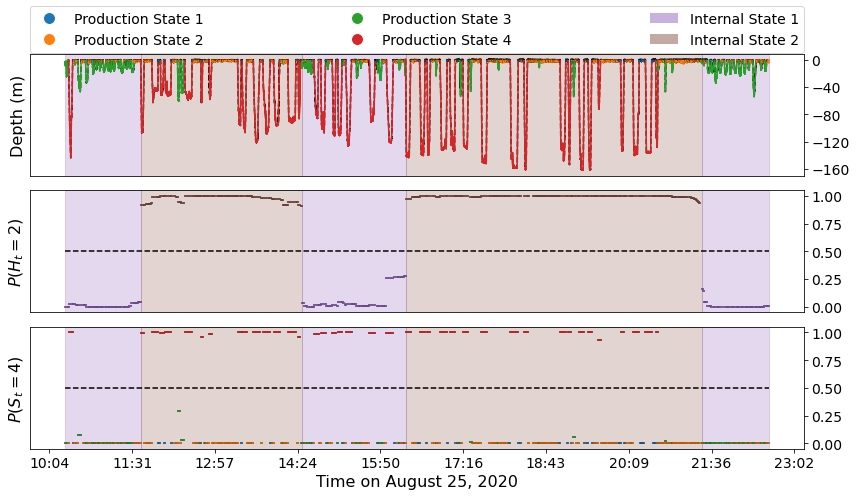

In [61]:
ind = 0
span = 1308

p_coarse = np.zeros((len(df),K[0]))
p_fine = np.zeros((len(df),K[1]))
for k0 in range(K[0]):
    p_coarse[:,k0] = np.sum(optims[model0].p_Xt[:,(k0*K[1]):((k0+1)*K[1])],1)
    
for k1 in range(K[1]):
    p_fine[:,k1] = np.sum(optims[model0].p_Xt[:,k1::K[1]],1)

# get the dive types
ML_divetype = np.argmax(p_fine,1)
ML_bouttype = np.argmax(p_coarse,1)

# define colors
coarse_colors = [cm.get_cmap('tab10')(i+K[1]) for i in range(K[0])]
fine_colors = [cm.get_cmap('tab10')(i) for i in range(K[1])]

fig,ax = plt.subplots(3,1,figsize=(12,7))

# get legend
labels = ['Production State 1','Production State 2','Production State 3','Production State 4',
          'Internal State 1','Internal State 2']
legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                  markerfacecolor=fine_colors[0], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label=labels[1],
                                  markerfacecolor=fine_colors[1], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label=labels[2],
                                  markerfacecolor=fine_colors[2], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label=labels[3],
                                  markerfacecolor=fine_colors[3], markersize=12),
                   Patch(facecolor=coarse_colors[0], alpha=0.5, label=labels[4]),
                   Patch(facecolor=coarse_colors[1], alpha=0.5, label=labels[5])]


s_bout = df["stime"].iloc[ind]
bouttype = ML_bouttype[ind]

for divenum in range(ind,ind+span):
    
    # plot dashed line
    dive_df = raw_df[raw_df["Time"] <= df["stime"].iloc[divenum+1]]
    dive_df = dive_df[dive_df["Time"] >= df["etime"].iloc[divenum-1]]
    dive_df = dive_df

    ax[0].plot(pd.to_datetime(dive_df["Time"]),
               dive_df["Elevation"],
             "k--")
    
    #ax[1].plot(pd.to_datetime(dive_df["Time"]),
    #           df.iloc[divenum]['avg_bot_htv']*np.ones(len(dive_df["Time"])),
    #           "k--")
    
    ax[1].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum]["etime"]]),
               [p_coarse[divenum,1],p_coarse[divenum,1]],
               "k-")
    
    ax[2].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum]["etime"]]),
               [p_fine[divenum,3],p_fine[divenum,3]],
               "k-")
    
    # show color of bout / dive type
    dive_df = raw_df[raw_df["divenum"] == df["divenum"].iloc[divenum]]
    
    if divenum == (ind+span-1) or ML_bouttype[divenum+1] != bouttype:
        
        for a in ax:
            a.axvspan(s_bout,
                      dive_df["Time"].iloc[-1],
                      color=coarse_colors[ML_bouttype[divenum]],
                      alpha = 0.25)
        
        bouttype = ML_bouttype[divenum+1]
        if divenum != (ind+span-1):
            s_bout = raw_df[raw_df["divenum"] == df["divenum"].iloc[divenum+1]]["Time"].iloc[0]
        
    
    ax[0].plot(pd.to_datetime(dive_df["Time"]),
               dive_df["Elevation"],
               color=fine_colors[ML_divetype[divenum]])
    
    #ax[1].plot(pd.to_datetime(dive_df["Time"]),
    #           df.iloc[divenum]['avg_bot_htv']*np.ones(len(dive_df["Time"])),
    #           color=fine_colors[ML_divetype[divenum]])
    
    ax[1].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum]["etime"]]),
               [p_coarse[divenum,1],p_coarse[divenum,1]],
               color=coarse_colors[ML_bouttype[divenum]])
    
    ax[2].plot(pd.to_datetime([df.iloc[divenum]["stime"],df.iloc[divenum]["etime"]]),
               [p_fine[divenum,3],p_fine[divenum,3]],
               color=fine_colors[ML_divetype[divenum]])
    
# fix formatting
ax[1].plot([df["stime"].iloc[ind],df["etime"].iloc[ind+span-1]],[0.5,0.5],'k--')
ax[2].plot([df["stime"].iloc[ind],df["etime"].iloc[ind+span-1]],[0.5,0.5],'k--')

ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                    bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')
    
for ax0 in ax:
    ax0.set_xticks([])

ax[0].set_ylabel('Depth (m)',fontsize=16)
#ax[1].set_ylabel(r'$\log(y^{(htv)}_t)$',fontsize=16)
ax[1].set_ylabel(r'$P(H_t = 2)$',fontsize=16)
ax[2].set_ylabel(r'$P(S_t = 4)$',fontsize=16)

ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))
ax[2].yaxis.set_major_locator(plt.MaxNLocator(5))
    
    
ax[-1].set_xlabel("Time on August 25, 2020",fontsize=16)
ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

for ax0 in ax:
    ax0.yaxis.tick_right()
    for item in ax0.get_yticklabels():
        item.set_fontsize(14)
    for item in ax0.get_xticklabels():
        item.set_fontsize(14)

plt.tight_layout()
plt.savefig('../plt0/decoded_dives_kw.png',dpi=300)
plt.show()

diveDuration
[2.07793514 2.93426508 4.58135781 5.67035718 2.07793514 2.93426508
 4.58135781 5.67035718]
[0.34791089 0.36256786 0.53612958 0.37304531 0.34791089 0.36256786
 0.53612958 0.37304531]
maxDepth
[0.42241004 0.97525224 2.8451605  4.68798897 0.42241004 0.97525224
 2.8451605  4.68798897]
[0.31045779 0.28526683 0.609792   0.33626122 0.31045779 0.28526683
 0.609792   0.33626122]
avg_bot_htv
[-2.03931895 -1.70336894 -1.71736441 -0.93579198 -2.03931895 -1.70336894
 -1.71736441 -0.93579198]
[0.45066014 0.66331603 0.62727915 0.6619206  0.45066014 0.66331603
 0.62727915 0.6619206 ]


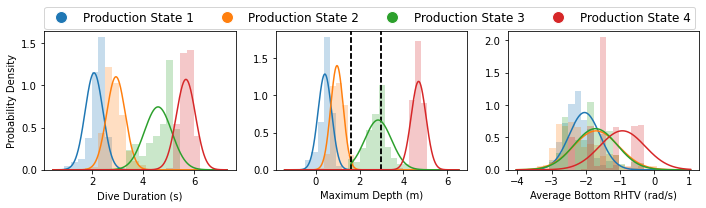

In [62]:
# plot the emission distributions
K_total = 4
optim = optims[model0]

fig,ax = plt.subplots(1,3,figsize=(10,3))
fignum = 0

# define labels
x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)"}

# make legend
leg_labels = ['Production State 1','Production State 2','Production State 3','Production State 4']
legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[0],
                                  markerfacecolor=fine_colors[0], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label=leg_labels[1],
                                  markerfacecolor=fine_colors[1], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label=leg_labels[2],
                                  markerfacecolor=fine_colors[2], markersize=12),
                   Line2D([0], [0], marker='o', color='w', label=leg_labels[3],
                                  markerfacecolor=fine_colors[3], markersize=12)]

for feature in features[1]:
    
    if features[1][feature]["f"] == "bern":
        continue
        
    print(feature)
    
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in optim.theta[1]])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in optim.theta[1]]))
    a = features[1][feature]["lower_bound"]
    b = features[1][feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([features[1][feature]["lower_bound"] for _ in optim.theta[1]])
    if not b is None:
        b = np.concatenate([features[1][feature]["upper_bound"] for _ in optim.theta[1]])
    
    print(mu)
    print(sig)
    
    colors = [cm.get_cmap('tab10')(i) for i in range(K_total)]
    legend = ['Dive type %d'%(x+1) for x in range(K_total)]
    
    for state in range(K_total):
        x = np.linspace(min(mu)-3*max(sig),max(mu)+3*max(sig),10000)
        if (not a is None) and (not b is None):
            y = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                b=(b[state]-mu[state])/sig[state],
                                loc=mu[state],scale=sig[state])
            if a[state] > -np.infty:
                ax[fignum].axvline(a[state],color='k',linestyle='--')
            if b[state] < np.infty:
                ax[fignum].axvline(b[state],color='k',linestyle='--')
        else:
            y = norm.pdf(x,mu[state],sig[state])
        ax[fignum].plot(x,y,color=fine_colors[state])
        
        # do the histogram
        feature_data = [datum[feature] for datum in data] 
        
        ax[fignum].hist(feature_data,weights=optim.p_Xt[:,state],
                        density=True,color=fine_colors[state],alpha=0.25,
                        bins = 20)
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")
        
    ax[fignum].set_xlabel(x_labels[feature])
    fignum += 1
        

ax[0].legend(handles=legend_elements,prop={'size': 12}, ncol=4, mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0., 1.01, 3.4, .2), loc='lower left')
plt.tight_layout()
plt.savefig('../plt0/emission_dists_kw.png',dpi=300)

In [30]:
ax[0]

<AxesSubplot:>